### Libraries

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from scipy.integrate import simps
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from sklearn import metrics
from tqdm import tqdm, trange
import datetime
import xgboost as xgb
import multiprocessing
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from joblib import dump, load
from sklearn.metrics import ConfusionMatrixDisplay



# plt.rcParams.update({
#     "font.weight": "bold",
#     "xtick.labelsize": 14,
#     "ytick.labelsize": 14,
#     'font.size': 18,
#     'axes.labelweight': 'bold',
#     'figure.dpi': 150.0,
#     'axes.linewidth':2.0,
# })

plt.rcParams.update({
    "font.weight": "bold",
    "xtick.labelsize": 30,
    "ytick.labelsize": 30,
    'font.size': 34,
    'axes.labelweight': 'bold',
    'figure.dpi': 350.0,
    'axes.linewidth':2.0,
})

# Important lists
lig = 'lignin'
features = ['A-A', 'B-B', 'A-B', 'A-A/B-B', 'A-A/(A-A + B-B)']
features_merged = ['A-A_n', 'B-B_n', 'A-B_n', 'A-A_n/B-B_n', 'A-B_n/(A-A_n + B-B_n)',
                   'A-A_l', 'B-B_l', 'A-B_l', 'A-A_l/B-B_l',
                   'A-B_l/(A-A_l + B-B_l)']


def autolabel(rects, ax, hnum=False):
    """Attach a text label above each bar in *rects*, displaying its height."""
    if hnum:
        offset = 0.65
    else:
        offset = 0.05


    for rect in rects:
        for x in rect:
            # print(x)
            height = x.get_height()
                
            if height==0:
                continue
            else:
                x1 = x.get_x() + offset
                
                ax.annotate(f'{int(height)}',
                            xy=(x1, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom',weight='bold',fontsize=16)
                            

def dirmaker(path):
    '''
    path is the folder path you want to make if it exists
    '''
    if os.path.isdir(path):
        pass
    else:
        os.mkdir(path)
        pass


### DES and non-DES hbond lifetimes
Creation and cleaning up of dataframes. These cells take in a path to GROMACS outputs from hydrogen bond calculations, and stores the 
A-A, B-B, and B-B lifetimes in a pandas dataframe. The dataframe can be stored as a csv for later use.


### Lignin DES

In [2]:
#DES
''' This function takes in a path to GROMACS outputs from hydrogen bond calculations, and stores the 
A-A, B-B, and B-B lifetimes in a pandas dataframe. The dataframe can be stored as a csv for later use.
'''

pathway = Path()

hlife_dict_lignin = {}

for folderz in pathway.glob('./desfiles-irc/des/*'):
    # print(folderz.stem)
    dict_key = folderz.stem  #[6:]
    hlife_list = []
    for file in pathway.glob(f"{folderz}/hbond-*"):
        # print(file)
        if len(os.listdir(file)) < 5:
            hlife_list.append(0)
            continue

        for txt in pathway.glob(f"{file}/hlife*.txt"):
            # print(txt)
            txtfile = txt.name
            data = pd.read_csv('{}'.format(txt), sep='\s+',
                               header=None, skiprows=[0, 1])
            data = pd.DataFrame(data)
            x = data[0]/1000
            y = data[2]
            area = 0
            # Change dx to 1 for files prior to 7 Sep 2020
            area = simps(y, dx=0.01)
            hlife_list.append(area)
            # print("The area of {thing} is {val}".format(thing= txt.stem, val=area))
            # print("\n")

    hlife_dict_lignin[f"{dict_key}"] = hlife_list
    # print(hlife_dict_lignin)
    # print("\n")

DES = []
AA = []
AB = []
BB = []

for i in list(hlife_dict_lignin.items()):
    # print(i)
    DES.append(i[0])
    AA.append(i[1][0])
    AB.append(i[1][1])
    BB.append(i[1][2])

des_dict = {
    "DES": DES,
    "A-A": AA,
    "A-B": AB,
    "B-B": BB
}
des_hlife_frame_lignin = pd.DataFrame(des_dict, columns=["DES", "A-A", "B-B", "A-B"])
aa_dlife_lignin = des_hlife_frame_lignin['A-A']
ab_dlife_lignin = des_hlife_frame_lignin['A-B']
bb_dlife_lignin = des_hlife_frame_lignin['B-B']
des_hlife_frame_lignin['A-A/B-B'] = aa_dlife_lignin/bb_dlife_lignin
# des_hlife_frame_lignin['BB/AA'] = bb_dlife_lignin/aa_dlife_lignin
des_hlife_frame_lignin['A-B/(A-A + B-B)'] = ab_dlife_lignin/(aa_dlife_lignin + bb_dlife_lignin)
des_hlife_frame_lignin.describe()


,A-A,B-B,A-B,A-A/B-B,A-B/(A-A + B-B)
count,17.000000,17.000000,17.000000,17.000000,17.000000
mean,1.879198,0.936694,1.683982,2.191885,0.597705
std,1.195965,0.725071,1.056821,1.044079,0.136038
min,0.232701,0.206614,0.256956,0.799192,0.376253
25%,0.928187,0.424842,0.797003,1.322662,0.514815
50%,1.420395,0.850050,1.556223,1.945682,0.565643
75%,2.762196,1.043621,2.767582,2.915546,0.710170
max,3.822261,3.311791,3.531654,4.476294,0.820397


In [3]:
''' This cell deletes the A-A, B-B, and B-B lifetimes with 0.00 values in a pandas dataframe. The dataframe can be stored as a csv for later use.
'''
des_hlife_lignin = des_hlife_frame_lignin[(des_hlife_frame_lignin['B-B'] > 0.0)]
des_hlife_lignin.reset_index(drop=True, inplace=True)

In [4]:
des_hlife_lignin

,DES,A-A,B-B,A-B,A-A/B-B,A-B/(A-A + B-B)
0,DEA-PNL11,1.420395,0.730024,1.664087,1.945682,0.773843
1,DEA-PNL12,1.381339,0.566631,1.556223,2.437813,0.798895
2,DEA-PNL21,1.827739,1.008626,2.014303,1.812108,0.710170
3,DMP-PNL11,0.897275,1.122728,1.142600,0.799192,0.565643
4,DMP-VAN21,2.219897,1.678356,3.198114,1.322662,0.820397
5,MEN-DMP11,1.058700,1.043621,0.791005,1.014449,0.376253
6,MEN-DMP21,0.928187,0.391961,0.944148,2.368062,0.715184
7,MEN-PNL11,0.493193,0.281440,0.398792,1.752393,0.514815
8,MEN-PNL12,0.232701,0.206614,0.256956,1.126258,0.584900
9,MEN-PNL21,0.547557,0.367481,0.474645,1.490031,0.518716


In [23]:
xdate = datetime.datetime.now().strftime("%m-%d-%Y")
des_hlife_lignin.describe().to_excel(f'./csv-files/lignin/des_lignin_hlife_summary_{xdate}.xlsx')
des_hlife_lignin.to_excel(f'./csv-files/lignin/des_lignin_hlife_{xdate}.xlsx')

In [ ]:
# DES non-overlapping histogram

xdate = datetime.datetime.now().strftime("%m-%d-%Y")
des_fig_lignin = plt.figure()
des_fig_lignin.set_size_inches(12, 8, forward=True)
des_ax_lignin = des_fig_lignin.add_subplot(1,1,1)
des_ax_lignin.set_xlabel("Hydrogen bond lifetime (ns)", weight='bold')
des_ax_lignin.set_ylabel("Number of systems", weight='bold')
ytick = np.arange(0,24, 2)
xtick = np.arange(0,5.5, 0.5)
plt.yticks(ytick,weight='bold')
plt.xticks(xtick,weight='bold')
# plt.title('DES', fontsize=22, weight='bold')
plt.ylim([0,12])

_, _, rects = plt.hist([des_hlife_frame_lignin['A-A'], des_hlife_frame_lignin['B-B'], des_hlife_frame_lignin['A-B']], bins=10, label=['A-A', 'B-B', 'A-B'])
autolabel(rects=rects, ax=des_ax_lignin)
# plt.hist([des_slice['A-A'], des_slice['B-B'], des_slice['A-B']], bins=binss, label=['A-A', 'B-B', 'A-B'])
plt.legend(loc='upper right')
dirmaker(f'plots/distributions/{xdate}')
des_fig_lignin.savefig(f'plots/distributions/{xdate}/des_hlife_frame_lignin_nonoverlap_{xdate}.tiff', dpi=350,facecolor='white', bbox_inches='tight')
plt.show()


### Lignin non-DES

In [5]:
# NON-DES
''' This function takes in a path to GROMACS outputs from hydrogen bond calculations, and stores the 
A-A, B-B, and B-B lifetimes in a pandas dataframe. The dataframe can be stored as a csv for later use.
'''

pathway = Path()

hlife_dict_nondes = {}

for folderz in pathway.glob('./desfiles-irc/nondes/*'):
    # print(folderz.stem)
    dict_key = folderz.stem
    hlife_list = []
    for file in pathway.glob(f"{folderz}/hbond-*-?-?"):
        # print(file)
        if len(os.listdir(file)) < 5:
            hlife_list.append(0)
            continue

        for txt in pathway.glob(f"{file}/hlife*.txt"):
            # print(txt)
            txtfile = txt.name
            data = pd.read_csv('{}'.format(txt), sep='\s+',
                               header=None, skiprows=[0, 1])
            data = pd.DataFrame(data)
            x = data[0]/1000
            y = data[2]
            area = 0
            # Change dx to 1 for files prior to 7 Sep 2020
            area = simps(y, dx=0.01)
            hlife_list.append(area)
            # print("The area of {thing} is {val}".format(thing= txt.stem, val=area))
            # print("\n")

    hlife_dict_nondes[f"{dict_key}"] = hlife_list
    # print(hlife_dict_nondes)
    # print("\n")

# print(hlife_dict_nondes)
NONDES = []
AA_ = []
AB_ = []
BB_ = []

for i in list(hlife_dict_nondes.items()):
    # print(i)
    NONDES.append(i[0])
    AA_.append(i[1][0])
    AB_.append(i[1][1])
    BB_.append(i[1][2])

nondes_dict_lignin = {
    "Non-DES": NONDES,
    "A-A": AA_,
    "A-B": AB_,
    "B-B": BB_
}
nondes_hlife_frame_lignin = pd.DataFrame(
    nondes_dict_lignin, columns=["Non-DES", "A-A", "B-B", "A-B"])
aa_nlife_lignin = nondes_hlife_frame_lignin['A-A']
ab_nlife_lignin = nondes_hlife_frame_lignin['A-B']
bb_nlife_lignin = nondes_hlife_frame_lignin['B-B']
nondes_hlife_frame_lignin['A-A/B-B'] = aa_nlife_lignin/bb_nlife_lignin
# nondes_hlife_frame_lignin['BB/AA'] = bb_nlife_lignin/aa_nlife_lignin
nondes_hlife_frame_lignin['A-B/(A-A + B-B)'] = ab_nlife_lignin/(aa_nlife_lignin + bb_nlife_lignin)
# nondes_hlife_frame_lignin


In [6]:
''' This cell deletes the A-A, B-B, and B-B lifetimes with 0.00 values in a pandas dataframe. The dataframe can be stored as a csv for later use.
'''
nondes_hlife_lignin = nondes_hlife_frame_lignin[(nondes_hlife_frame_lignin['B-B'] > 0.0)]
nondes_hlife_lignin.reset_index(drop=True, inplace=True)
nondes_hlife_lignin

,Non-DES,A-A,B-B,A-B,A-A/B-B,A-B/(A-A + B-B)
0,DEA-HDA11,2.548177,2.454365,1.991729,1.038223,0.398143
1,DEA-HDL11,1.591568,0.932191,1.228077,1.707342,0.486606
2,DEA-SGA11,3.592210,3.197229,2.905294,1.123539,0.427914
3,DEA-SYA11,3.059960,2.043980,2.156269,1.497060,0.422471
4,DEA-VAN11,2.283029,1.045423,1.294826,2.183833,0.389018
5,DEA-VNA11,3.076017,2.779366,3.105455,1.106733,0.530359
6,MEN-HDA11,2.682118,3.330352,3.830274,0.805356,0.637055
7,MEN-HDL11,2.734466,1.777658,3.015204,1.538241,0.668245
8,MEN-SYA11,1.785885,2.369956,1.975945,0.753552,0.475462
9,MEN-VAN21,0.575102,0.584354,1.007917,0.984166,0.869301


In [24]:
xdate = datetime.datetime.now().strftime("%m-%d-%Y")
nondes_hlife_lignin.describe().to_excel(f'./csv-files/lignin/nondes_lignin_hlife_summary_{xdate}.xlsx')
nondes_hlife_lignin.to_excel(f'./csv-files/lignin/nondes_lignin_hlife_{xdate}.xlsx')

In [ ]:
# NON-DES non-overlapping histo 
xdate = datetime.datetime.now().strftime("%m-%d-%Y")
non_des_fig_lignin = plt.figure()
non_des_fig_lignin.set_size_inches(12, 8, forward=True)
non_des_ax_lignin = non_des_fig_lignin.add_subplot(1,1,1)
non_des_ax_lignin.set_xlabel("Hydrogen bond lifetime (ns)",weight='bold')
non_des_ax_lignin.set_ylabel("Number of systems",weight='bold')
ytick = np.arange(0,24, 2)
xtick = np.arange(0,10, 0.5)
plt.yticks(ytick,weight='bold')
plt.xticks(xtick,weight='bold')
# plt.title('Non-DES', fontsize=22, weight='bold')
plt.ylim([0,12])
# non_des_hist = nondes_slice[['A-A', 'B-B', 'A-B']]
# non_des_hist.plot.hist(bins=20, alpha=0.5, ylim=[0,16], ax =non_des_ax_lignin) 
# binss = np.linspace(0.09871825, 4.54204605, 10)
# plt.hist([nondes_slice['A-A'], nondes_slice['B-B'], nondes_slice['A-B']], bins=binss, label=['A-A', 'B-B', 'A-B'])
_, _, rects = plt.hist([nondes_hlife_lignin['A-A'], nondes_hlife_lignin['B-B'], nondes_hlife_lignin['A-B']], bins=10, label=['A-A', 'B-B', 'A-B'])
autolabel(rects=rects, ax=non_des_ax_lignin)
plt.legend(loc='upper right')
dirmaker(f'plots/distributions/{xdate}')
non_des_fig_lignin.savefig(f'plots/distributions/{xdate}/nondes-ligninhlife_nonoverlap_{xdate}.tiff', dpi=350,facecolor='white', bbox_inches='tight')
plt.show()


### DES and non-DES hbond numbers
Creation and cleaning up of dataframes.

#### Lignin DES

In [8]:
''' This function takes in a path to GROMACS outputs from hydrogen bond calculations, and stores the 
A-A, B-B, and B-B numtimes in a pandas dataframe. The dataframe can be stored as a csv for later use.
'''

pathway = Path()

hnum_dict_lignin = {}

for folderz in pathway.glob('./desfiles-irc/des/*'):
    # print(folderz.stem)
    dict_key = folderz.stem
    hnum_list = []
    for file in pathway.glob(f"{folderz}/hbond-*"):
        # print(file)
        if len(os.listdir(file)) < 5:
            hnum_list.append(0)
            continue

        for txt in pathway.glob(f"{file}/hnum*.txt"):
            # print(txt)
            txtfile = txt.name
            data = pd.read_csv('{}'.format(txt), sep='\s+',
                               header=None, skiprows=[0, 1])
            data = pd.DataFrame(data)
            y = data[1]
            avg = 0
            avg = np.average(y)  # Change dx to 1 for files prior to 7 Sep 2020
            hnum_list.append(avg)
            # print("The avg of {thing} is {val}".format(thing= txt.stem, val=avg))
            # print("\n")

    hnum_dict_lignin[f"{dict_key}"] = hnum_list
    # print(hnum_dict_lignin)
    # print("\n")

DES = []
AA = []
AB = []
BB = []

for i in list(hnum_dict_lignin.items()):
    # print(i)
    DES.append(i[0])
    AA.append(i[1][0])
    AB.append(i[1][1])
    BB.append(i[1][2])

des_dict = {
    "DES": DES,
    "A-A": AA,
    "A-B": AB,
    "B-B": BB
}
des_hnum_frame_lignin = pd.DataFrame(des_dict, columns=["DES", "A-A", "B-B", "A-B"])
# des_hnum_frame_lignin
aa_dnum_lignin = des_hnum_frame_lignin['A-A']
ab_dnum_lignin = des_hnum_frame_lignin['A-B']
bb_dnum_lignin = des_hnum_frame_lignin['B-B']
des_hnum_frame_lignin['A-A/B-B'] = aa_dnum_lignin/bb_dnum_lignin
# des_hnum_frame_lignin['BB/AA'] = bb_dnum_lignin/aa_dnum_lignin
des_hnum_frame_lignin['A-B/(A-A + B-B)'] = ab_dnum_lignin/(aa_dnum_lignin + bb_dnum_lignin)
des_hnum_frame_lignin.describe()

,A-A,B-B,A-B,A-A/B-B,A-B/(A-A + B-B)
count,17.000000,17.000000,17.000000,17.000000,17.000000
mean,25.402362,14.040430,40.310337,3.604816,1.108419
std,24.974857,12.488954,29.826470,4.025143,0.395184
min,5.922078,3.147852,17.978022,0.202750,0.591553
25%,10.435564,5.783217,27.240759,0.640790,0.850253
50%,14.231768,10.493506,31.552448,1.972916,0.987652
75%,29.257742,16.748252,40.727273,4.262717,1.295652
max,103.439560,44.244755,148.755245,14.269438,2.261271


In [ ]:
des_hnum_frame_lignin

In [9]:
''' This cell deletes the A-A, B-B, and B-B lifetimes with 0.00 values in a pandas dataframe. The dataframe can be stored as a csv for later use.
'''
des_hnum_lignin = des_hnum_frame_lignin[(des_hnum_frame_lignin['B-B'] > 0.0)]
des_hnum_lignin.reset_index(drop=True, inplace=True)
des_hnum_lignin

,DES,A-A,B-B,A-B,A-A/B-B,A-B/(A-A + B-B)
0,DEA-PNL11,19.658342,11.382617,40.727273,1.727049,1.312049
1,DEA-PNL12,8.469530,33.392607,54.238761,0.253635,1.295652
2,DEA-PNL21,57.322677,5.783217,56.630370,9.911902,0.897386
3,DMP-PNL11,7.231768,11.285714,22.994006,0.640790,1.241746
4,DMP-VAN21,14.178821,3.991009,41.086913,3.552691,2.261271
5,MEN-DMP11,12.079920,6.122877,17.978022,1.972916,0.987652
6,MEN-DMP21,29.257742,3.379620,24.753247,8.657109,0.758433
7,MEN-PNL11,10.435564,10.493506,23.664336,0.994478,1.130692
8,MEN-PNL12,5.922078,29.208791,29.870130,0.202750,0.850253
9,MEN-PNL21,28.118881,7.314685,31.552448,3.844168,0.890468


In [ ]:
des_hnum_lignin.describe()

In [25]:
xdate = datetime.datetime.now().strftime("%m-%d-%Y")
des_hnum_lignin.describe().to_excel(f'./csv-files/lignin/des_lignin_hnum_summary_{xdate}.xlsx')
des_hnum_lignin.to_excel(f'./csv-files/lignin/des_lignin_hnum_{xdate}.xlsx')

In [ ]:
# non-overlapping histo DES
xdate = datetime.datetime.now().strftime("%m-%d-%Y")
des_fig_lignin = plt.figure()
des_fig_lignin.set_size_inches(12, 8, forward=True)
des_ax_lignin = des_fig_lignin.add_subplot(1,1,1)
des_ax_lignin.set_xlabel("Hydrogen bond number",weight='bold')
des_ax_lignin.set_ylabel("Number of systems",weight='bold')
ytick = np.arange(0,40, 2)
xtick = np.arange(0,150, 20)
plt.yticks(ytick,fontsize=22, weight='bold')
plt.xticks(xtick,fontsize=22, weight='bold')
# plt.title('DES', fontsize=22, weight='bold')
plt.ylim([0,14])
# des = des[['AA', 'BB', 'AB']]
# des.plot.hist(bins=20, alpha=0.5, ylim=[0,22], ax=des_ax_lignin)

_, _, rects = plt.hist([des_hnum_lignin['A-A'], des_hnum_lignin['B-B'], des_hnum_lignin['A-B']], bins=10, label=['A-A', 'B-B', 'A-B'])
autolabel(rects=rects, ax=des_ax_lignin, hnum=True)
# plt.hist([des['A-A'], des['B-B'], des['A-B']], bins=binss, label=['A-A', 'B-B', 'A-B'])
plt.legend(loc='upper right', prop={'weight':'bold'})
dirmaker(f'plots/distributions/{xdate}')
des_fig_lignin.savefig(f'plots/distributions/{xdate}/des_hnum_lignin_nonoverlap_{xdate}.tiff', dpi=350,facecolor='white', bbox_inches='tight')
plt.show()

#### Lignin non-DES

In [19]:
''' This function takes in a path to GROMACS outputs from hydrogen bond calculations, and stores the 
A-A, B-B, and B-B numtimes in a pandas dataframe. The dataframe can be stored as a csv for later use.
'''

pathway = Path()

hnum_dict_nondes_lignin = {}

for folderz in pathway.glob('./desfiles-irc/nondes/*'):
    # print(folderz.stem)
    dict_key = folderz.stem
    hnum_list_nondes = []
    for file in pathway.glob(f"{folderz}/hbond-???-*"):
        # print(file)
        if len(os.listdir(file)) < 3:
            hnum_list_nondes.append(0)
            continue

        for txt in pathway.glob(f"{file}/hnum*.txt"):
            # print(txt)
            txtfile = txt.name
            data = pd.read_csv('{}'.format(txt), sep='\s+',
                               header=None, skiprows=[0, 1])
            data = pd.DataFrame(data)
            y = data[1]
            avg = 0
            avg = np.average(y)  # Change dx to 1 for files prior to 7 Sep 2020
            hnum_list_nondes.append(avg)
            # print("The avg of {thing} is {val}".format(thing= txt.stem, val=avg))
            # print("\n")

    hnum_dict_nondes_lignin[f"{dict_key}"] = hnum_list_nondes
    # print(hnum_dict_nondes_lignin)
    # print("\n")

NONDES = []
AA = []
AB = []
BB = []

for i in list(hnum_dict_nondes_lignin.items()):
    # print(i)
    NONDES.append(i[0])
    AA.append(i[1][0])
    AB.append(i[1][1])
    BB.append(i[1][2])
    # try:
    #     BB.append(i[1][2])
    # except:
    #     BB.append(0)

nondes_dict_lignin = {
    "DES": NONDES,
    "A-A": AA,
    "A-B": AB,
    "B-B": BB
}
nondes_hnum_frame_lignin = pd.DataFrame(nondes_dict_lignin, columns=["DES", "A-A", "B-B", "A-B"])
# nondes_hnum_frame_lignin
aa_nnum_lignin = nondes_hnum_frame_lignin['A-A']
ab_nnum_lignin = nondes_hnum_frame_lignin['A-B']
bb_nnum_lignin = nondes_hnum_frame_lignin['B-B']
nondes_hnum_frame_lignin['A-A/B-B'] = aa_nnum_lignin/bb_nnum_lignin
# nondes_hnum_frame_lignin['BB/AA'] = bb_nnum_lignin/aa_nnum_lignin
nondes_hnum_frame_lignin['A-B/(A-A + B-B)'] = ab_nnum_lignin/(aa_nnum_lignin + bb_nnum_lignin)
nondes_hnum_frame_lignin.describe()

,A-A,B-B,A-B,A-A/B-B,A-B/(A-A + B-B)
count,17.000000,17.000000,17.000000,17.000000,17.000000
mean,16.747605,26.927073,42.132456,0.945807,0.983456
std,9.161003,11.014472,14.148587,1.005752,0.340176
min,4.645355,5.708292,14.866134,0.122597,0.460512
25%,8.237762,14.524476,35.677323,0.291767,0.805261
50%,12.703297,30.829171,47.306693,0.592641,0.939760
75%,23.880120,35.942058,53.111888,1.175172,1.271860
max,31.319680,39.716284,58.141858,3.878894,1.697535


In [26]:
xdate = datetime.datetime.now().strftime("%m-%d-%Y")
nondes_hnum_frame_lignin.to_excel(f'./csv-files/lignin/nondes_lignin_hnum_{xdate}.xlsx')
nondes_hnum_frame_lignin.describe().to_excel(f'./csv-files/lignin/nondes_lignin_hnum_summary_{xdate}.xlsx')

In [20]:
''' This cell deletes the A-A, B-B, and B-B lifetimes with 0.00 values in a pandas dataframe. The dataframe can be stored as a csv for later use.
'''
nondes_hnum_lignin = nondes_hnum_frame_lignin[(nondes_hnum_frame_lignin['B-B'] > 0.0)]
nondes_hnum_lignin.reset_index(drop=True, inplace=True)
nondes_hnum_lignin

,DES,A-A,B-B,A-B,A-A/B-B,A-B/(A-A + B-B)
0,DEA-HDA11,29.220779,35.496503,53.883117,0.823202,0.832592
1,DEA-HDL11,23.880120,36.495504,52.185814,0.654330,0.864352
2,DEA-SGA11,19.677323,33.202797,53.625375,0.592641,1.014093
3,DEA-SYA11,28.627373,14.524476,24.582418,1.970975,0.569672
4,DEA-VAN11,31.319680,13.295704,20.875125,2.355624,0.467891
5,DEA-VNA11,28.134865,23.941059,47.306693,1.175172,0.908418
6,MEN-HDA11,4.645355,37.891109,55.707293,0.122597,1.309636
7,MEN-HDL11,8.237762,33.521479,53.111888,0.245746,1.271860
8,MEN-SYA11,11.348651,12.844156,19.481518,0.883565,0.805261
9,MEN-VAN21,22.141858,5.708292,35.677323,3.878894,1.281046


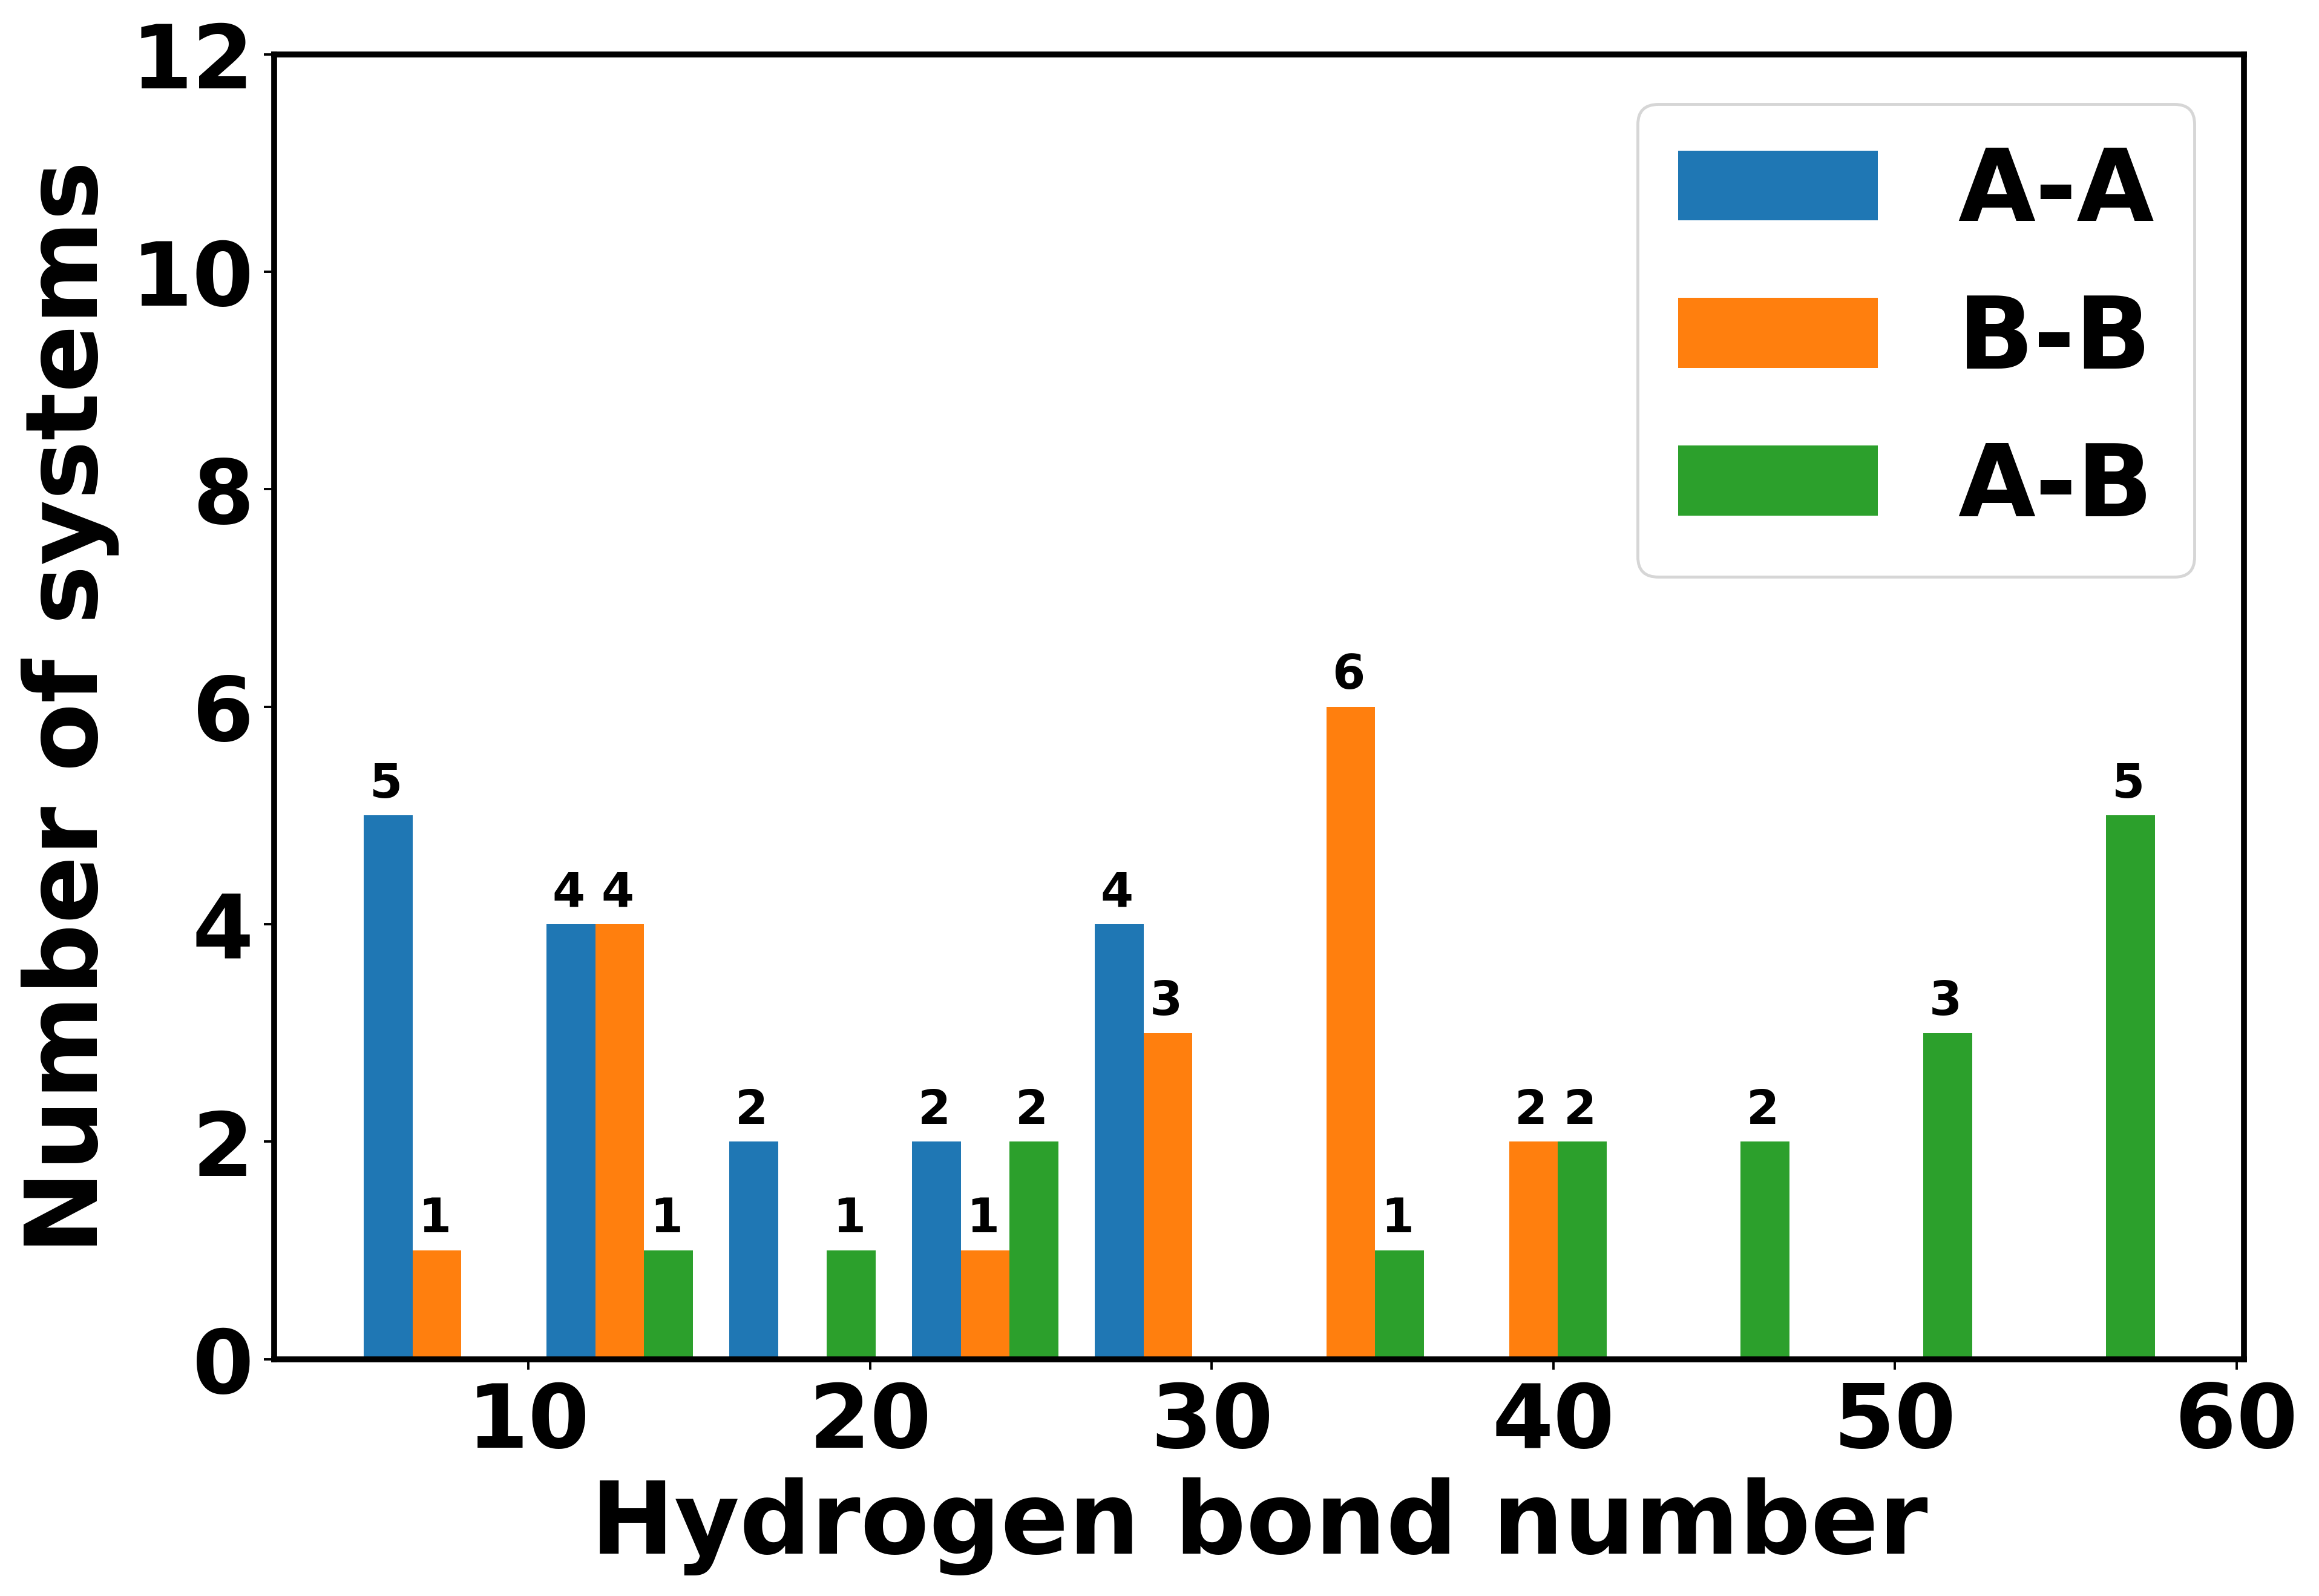

In [21]:
# non-overlapping histo NON-DES
xdate = datetime.datetime.now().strftime("%m-%d-%Y")
non_des_fig_lignin = plt.figure()
non_des_fig_lignin.set_size_inches(12, 8, forward=True)
non_des_ax_lignin = non_des_fig_lignin.add_subplot(1,1,1)
non_des_ax_lignin.set_xlabel("Hydrogen bond number", weight='bold')
non_des_ax_lignin.set_ylabel("Number of systems", weight='bold')
ytick = np.arange(0,40, 2)
xtick = np.arange(0,90, 10)
plt.yticks(ytick, weight='bold')
plt.xticks(xtick, weight='bold')
# plt.title('Non-DES', fontsize=22, weight='bold')
plt.ylim([0,12])
# non_des_hist = non_des[['AA', 'BB', 'AB']]
# non_des_hist.plot.hist(bins=20, alpha=0.5, ylim=[0,22], ax =non_des_ax_lignin) # ylim=[0,22], 

# plt.hist([des['A-A'], des['B-B'], des['A-B']], bins=binss, label=['A-A', 'B-B', 'A-B'])
_, _, rects = plt.hist([nondes_hnum_lignin['A-A'], nondes_hnum_lignin['B-B'], nondes_hnum_lignin['A-B']], bins=10, label=['A-A', 'B-B', 'A-B'])
autolabel(rects=rects, ax=non_des_ax_lignin, hnum=True)
plt.legend(loc='upper right', prop={'weight':'bold'})
dirmaker(f'plots/distributions/{xdate}')
non_des_fig_lignin.savefig(f'plots/distributions/{xdate}/nondes_hnum_lignin_nonoverlap_{xdate}.tiff', dpi=350,facecolor='white', bbox_inches='tight')
plt.show()


### Utility functions

In [15]:
def dirmaker(path):
    '''
    path is the folder path you want to make if it exists
    '''
    if os.path.isdir(path):
        pass
    else:
        os.mkdir(path)
        pass


#### data generation for hnum or hlife or merged data
This generates random data samples of training and testing set for hnum or hlife or merged scenarios.

In [16]:
def data_validate(des, nondes, batch_size=19, random_state=1):
    '''
    This generates batches of equally sized data samples from two dataframes
    and returns training datasets.
    '''
    des_batch_df = des.sample(n=batch_size, replace=False, random_state=random_state)
    df = [des_batch_df, nondes]
    df_train = pd.concat(df).drop_duplicates(keep=False)
    df_train = df_train.reset_index()

    X_train = np.array(df_train.drop(columns=['output', 'index']))
    y_train = np.array(df_train['output'])

    # if folder_type == 'hlife' or folder_type == 'hnum':
    #     X_train = np.array(df_train.drop(columns=['output', 'index']))
    #     y_train = np.array(df_train['output'])
    # elif folder_type == 'merged':
    #     X_train = np.array(df_train.drop(columns=['output_l', 'output_n', 'index']))
    #     y_train = np.array(df_train['output'])
    # else:
    #     print('Something is wrong somewhere')            

    return X_train, y_train


#### Validation functions
Functions for validating different model types.

In [17]:
def validate_trained_models(model, X, y, file_name, folder_type='unclassified', num=100, rand_seed=1000):
    '''
    This function validates a saved model on hnum/hlife/merged data.
    Works with sklearn GradBoost, AdaBoost, RandomForest,
    ExtraTreesForest, and DecisionTrees. 

    model is the model instance,
    X is the input and y is the output
    file_name is the txt file for logs,
    folder_type can be hlife, hnum, merged, or unclassified.
    n_repeats is passed to grid search,
    rand_seed ensures replicability of CV.
    '''
    xdate = datetime.datetime.now().strftime("%m-%d-%Y")
    # print(xdate)

    roc_auc_list = []
    folder_name = folder_type
    model_name = model.__str__().split('(')[0]
    if model_name.__contains__("XGBClassifier"):
        model_name = "XGBClassifier"

        
    # file = open(f"./model-logs/hlife_{num}_{xdate}.txt", "w+")
    file = file_name

    X_test = X
    y_test = y
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)  # roc_auc_score needs probabilities
    print(f'Prediction probabilities: \n{y_pred_proba}', file=file)
    # print('Prediction probabilities: \n', y_pred_proba)
    print(f'Predictions: {y_pred}', file=file)
    # print('Predictions: ', y_pred)
    target_names = ['non-DES', 'DES']  # non-DES is 0, DES is 1
    print(metrics.classification_report(y_test, y_pred,
        target_names=target_names), file=file)
    roc_auc = metrics.roc_auc_score(y_test, y_pred_proba[:,1])
    print(f"roc_auc_score: {roc_auc}", file=file)
    roc_auc_list.append(roc_auc)
    # print(model.feature_importances_, file=file)
    print('\n', file=file)
    # print(model_feature_df, file=file)
    print('\n'*2, file=file)


    # plotting roc_auc score
    fig = plt.figure()
    fig.set_size_inches(12, 10, forward=True)
    fig_ax = fig.add_subplot(1, 1, 1)
    fig_ax.set_xlabel("Number of iterations", fontsize=24, weight='bold')
    fig_ax.set_ylabel("ROC_AUC Score", fontsize=24, weight='bold')

    if folder_name == 'hlife':
        title_tag = 'lifetimes'
    elif folder_name == 'hnum':
        title_tag = 'numbers'
    elif folder_name == 'merged':
        title_tag = 'numbers + lifetimes'
    else:
        title_tag = ''  # this could be an indication that the folder_type was not set properly


    ytick = np.arange(0, 1.2, 0.2)
    xtick = np.arange(0, 2.2, 1.0)
    plt.yticks(ytick, fontsize=22, weight='bold')
    plt.xticks(xtick, fontsize=22, weight='bold')
    fig_ax.set_ylim(0, 1.0)
    fig_ax.set_xlim(0, 2.0)
    plt.title(f'{model_name} hbond {title_tag}', fontsize=22, weight='bold')


    roc = [z for z in range(1, num+1)]
    print(f"roc_auc scores: {roc_auc_list}", file=file)
    print(
        f"Average roc_auc scores: {np.average(roc_auc_list)}", file=file)
    print(
        f"std dev of roc_auc scores: {np.std(roc_auc_list)}", file=file)
    print(
        f"Best roc_auc score: {max(roc_auc_list)} at index {roc_auc_list.index(max(roc_auc_list)) + 1}", file=file)
    print('\n', file=file)
    plt.plot(roc, roc_auc_list, '-o', linewidth=2, markersize=8.0, label=f"avg roc_auc: {round(np.average(roc_auc_list),2)}\nstd roc_auc : {round(np.std(roc_auc_list),2)}")
    plt.legend(loc='lower left', fontsize=16)    
    dirmaker(f'./plots/validation/{folder_name}/{xdate}')
    fig.savefig(f'plots/validation/{folder_name}/{xdate}/{model_name}_{lig}_{folder_name}_{num}-{xdate}.png', dpi=350, facecolor='white', bbox_inches='tight')
    plt.show()
    file.close()


### histogram heights

In [18]:
def histlabel(rects, ax, model_name, folder_type):
    """Attach a text label above each bar in *rects*, displaying its height."""
    if 'hlife' in folder_type:
        if 'XGBRF' in model_name:
            offset = 0.00008
        elif 'XGBC' in model_name:
            offset = 0.0005
        elif 'Extra' in model_name or 'Logis' in model_name:
            offset = 0.008
        elif 'Grad' in model_name:
            offset = 0.003
        else:
            offset = 0.015

    elif 'hnum' in folder_type:
        if 'XGBRF' in model_name:
            offset = 0.0001
        elif 'XGBC' in model_name or 'Logis' in model_name:
            offset = 0.018
        elif 'Extra' in model_name:
            offset = 0.008
        elif 'KN' in model_name or 'Deci' in model_name:
            offset = 0.018
        elif 'Grad' in model_name:
            offset = 0.0009
        else:
            offset = 0.0085

    elif 'merged' in folder_type:
        if 'XGBRF' in model_name:
            offset = 0.00008
        elif 'Extra' in model_name or 'Ada' in model_name:
            offset = 0.0075
        elif 'SVC' in model_name or 'Rand' in model_name:
            offset = 0.009
        elif 'Grad' in model_name:
            offset = 0.0009
        else:
            offset = 0.015


    for rect in rects:
        for hist_bar in rect:
            # print(x)
            height = hist_bar.get_height()
                
            if height==0:
                continue
            else:
                x1 = hist_bar.get_x() + offset
                
                ax.annotate(f'{int(height)}',
                            xy=(x1, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom',weight='bold',fontsize=36)

### prediction probabilities plotter

In [61]:
def validation_proba_plotter(folder_type='hlife', overlapping=True, true_label='yes', annotate=True):
    '''
    This function grabs prediction probabilities of models from a path and plots them
    on a histogram.
    folder_type can be hnum, hlife or merged.
    overlapping controls whether the histogram has overlapping bars or not.
    '''
    for file in pathway.glob(f'./model-logs/validation/{folder_type}/02-21-2023/*.txt'):
        model_name = str(file.stem).split('_')[0] 
        print(model_name)
        xdate = datetime.datetime.now().strftime("%m-%d-%Y")
        des_fig_proba = plt.figure()
        des_fig_proba.set_size_inches(24, 14, forward=True)
        des_ax_proba = des_fig_proba.add_subplot(1,1,1)   
        des = []
        nondes = []
        true_labels = true_label
        index=0
        
        with open(file, 'r+') as r:
            lines = r.readlines()
            # print(lines[0:39])
            print(lines[0:35])
            # proba = lines[1:39]
            proba = lines[1:35]

            for line in proba:                
                # print(line)
                splitted = line.strip(' []\n').split()
                # print(splitted)
                # print(float(splitted[0]))
                if true_labels[index]==0:
                    nondes.append(float(splitted[1]))  # select 0 if you want to see probability of being non-DES, 1 for DES probability.
                elif true_labels[index]==1:
                    des.append(float(splitted[1]))
                
                index += 1

        print(f'des: {des}')
        print(f'nondes: {nondes}')
        # des_ax_proba.set_xlabel('Prediction confidence', weight='bold')
        des_ax_proba.set_xlabel('Probability of being DES', weight='bold')
        des_ax_proba.set_ylabel("Number of systems", weight='bold')

        plt.ylim(top=int(16))
        # plt.xlim(left=0.495, right=0.505)

        if overlapping:
            if annotate:                                
                _, _, hists1 = plt.hist(des, bins=20, label='DESs', edgecolor='black')
                histlabel(rects=hists1, ax=des_ax_proba, model_name=model_name, folder_type=folder_type)
                _, _, hists2 = plt.hist(nondes, bins=20, label='non-DESs', alpha=0.7, edgecolor='black') #, color='r')
                # histlabel(rects=hists1, ax=des_ax_proba, model_name=model_name, folder_type=folder_type)
                # histlabel(rects=hists2, ax=des_ax_proba, model_name=model_name, folder_type=folder_type)
                tag='overlap-annotated'
            else:
                plt.hist(des, bins=20, label='DESs', edgecolor='black')
                plt.hist(nondes, bins=20, label='non-DESs', alpha=0.7, edgecolor='black') #, color='r')
                tag='overlap'
        else:
            if annotate:
                _, _, hists = plt.hist([nondes, des], bins=10, label=['non-DES', 'DES'], edgecolor='black') # non-overlapping
                histlabel(rects=hists, ax=des_ax_proba, model_name=model_name, folder_type=folder_type)
                tag='non-overlap-annotated'
            else:
                plt.hist([nondes, des], bins=10, label=['non-DES', 'DES'], edgecolor='black') # non-overlapping
                tag='non-overlap'

        plt.axvline(x=0.5, color = 'g', linestyle = '--', lw=3)  # use total-res median as cut-off 90.63
        plt.legend(loc='upper right')
        dirmaker(f'./plots/validation_proba/{folder_type}/{xdate}')
        des_fig_proba.savefig(f'plots/validation_proba/{folder_type}/{xdate}/{model_name}_{folder_type}_{tag}_{xdate}.tiff', dpi=350,facecolor='white', bbox_inches='tight')
        plt.show()

## hbond lifetimes
Train models using hlife data alone.

#### hlife house cleaning

In [20]:
nondes_df_hlife = nondes_hlife_lignin.drop(columns=['Non-DES'])
nondes_df_hlife['output'] = 0
nondes_df_hlife

,A-A,B-B,A-B,A-A/B-B,A-B/(A-A + B-B),output
0,2.548177,2.454365,1.991729,1.038223,0.398143,0
1,1.591568,0.932191,1.228077,1.707342,0.486606,0
2,3.592210,3.197229,2.905294,1.123539,0.427914,0
3,3.059960,2.043980,2.156269,1.497060,0.422471,0
4,2.283029,1.045423,1.294826,2.183833,0.389018,0
5,3.076017,2.779366,3.105455,1.106733,0.530359,0
6,2.682118,3.330352,3.830274,0.805356,0.637055,0
7,2.734466,1.777658,3.015204,1.538241,0.668245,0
8,1.785885,2.369956,1.975945,0.753552,0.475462,0
9,0.575102,0.584354,1.007917,0.984166,0.869301,0


In [21]:
des_df_hlife = des_hlife_lignin.drop(columns=['DES'])
des_df_hlife['output'] = 1
des_df_hlife

,A-A,B-B,A-B,A-A/B-B,A-B/(A-A + B-B),output
0,1.420395,0.730024,1.664087,1.945682,0.773843,1
1,1.381339,0.566631,1.556223,2.437813,0.798895,1
2,1.827739,1.008626,2.014303,1.812108,0.710170,1
3,0.897275,1.122728,1.142600,0.799192,0.565643,1
4,2.219897,1.678356,3.198114,1.322662,0.820397,1
5,1.058700,1.043621,0.791005,1.014449,0.376253,1
6,0.928187,0.391961,0.944148,2.368062,0.715184,1
7,0.493193,0.281440,0.398792,1.752393,0.514815,1
8,0.232701,0.206614,0.256956,1.126258,0.584900,1
9,0.547557,0.367481,0.474645,1.490031,0.518716,1


## Validation

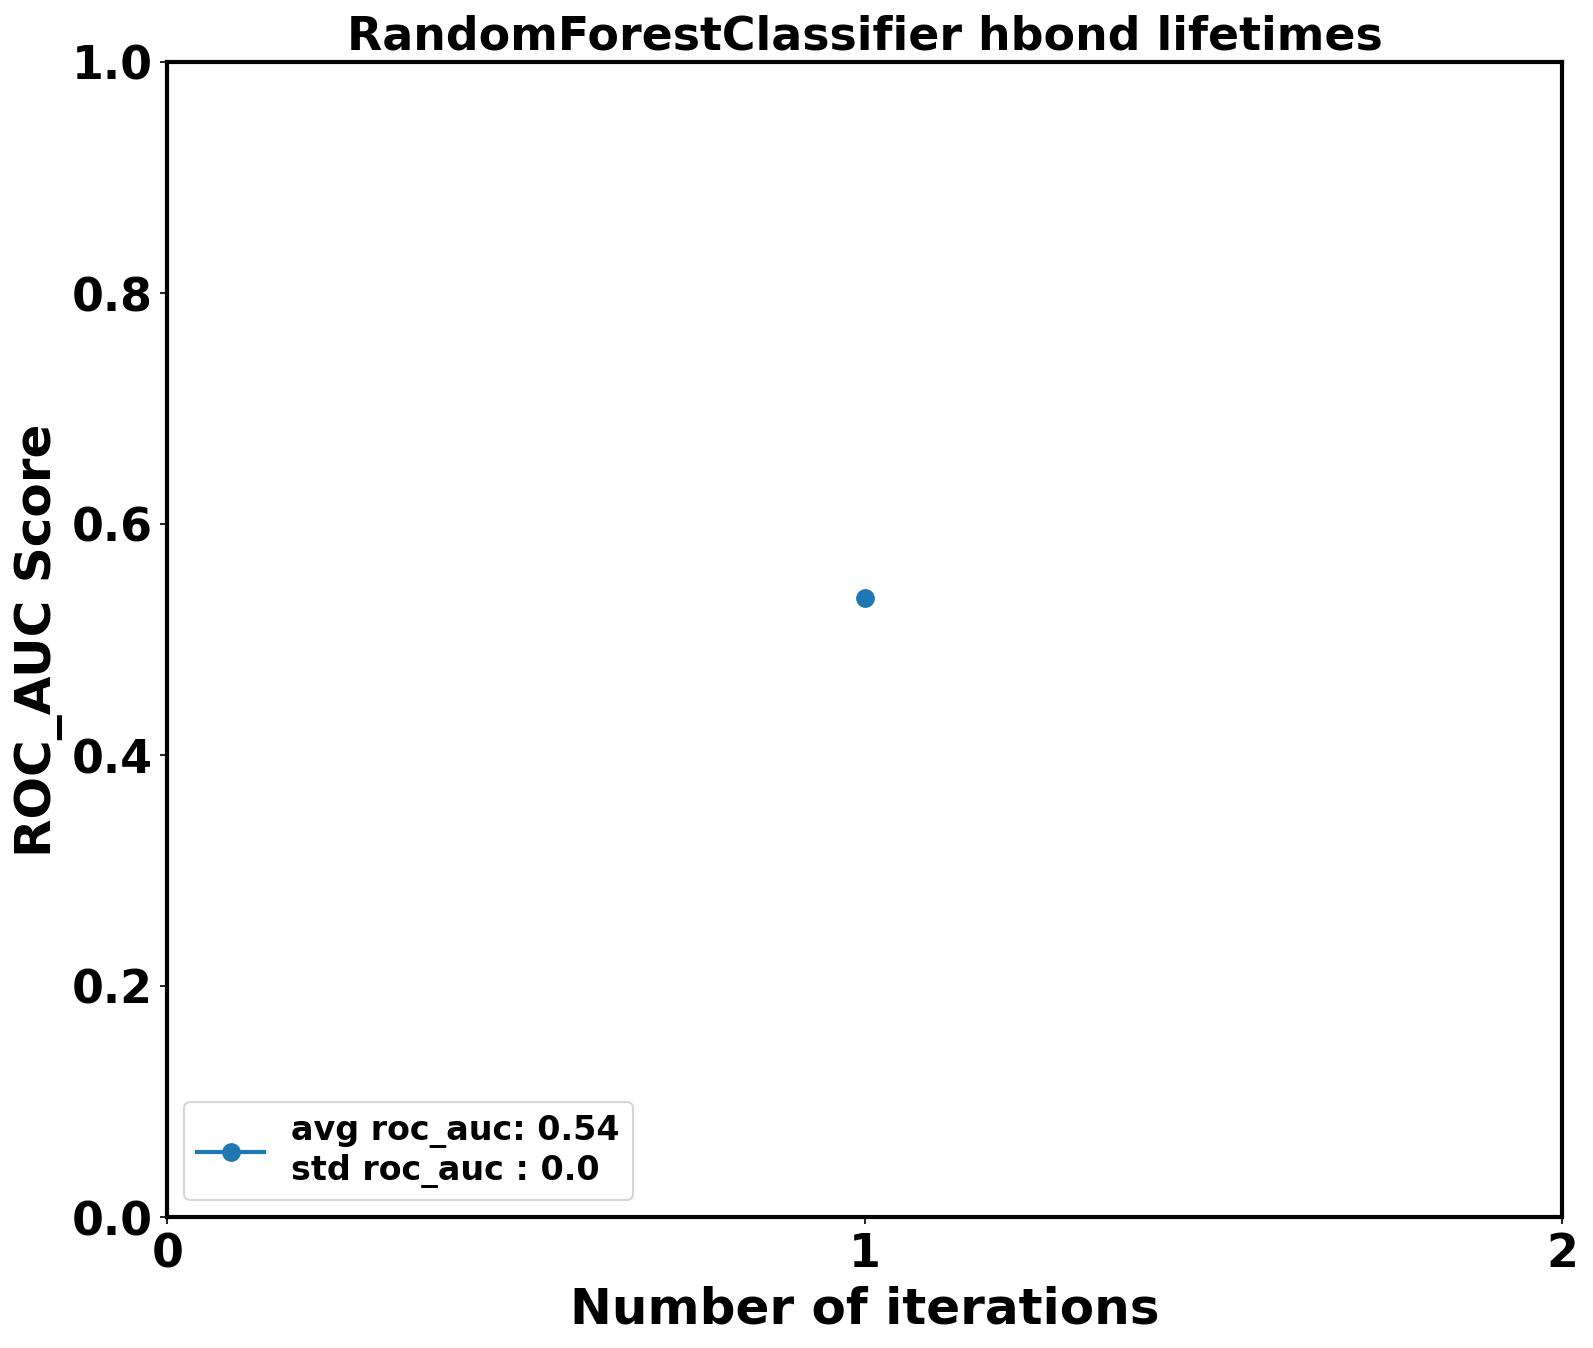

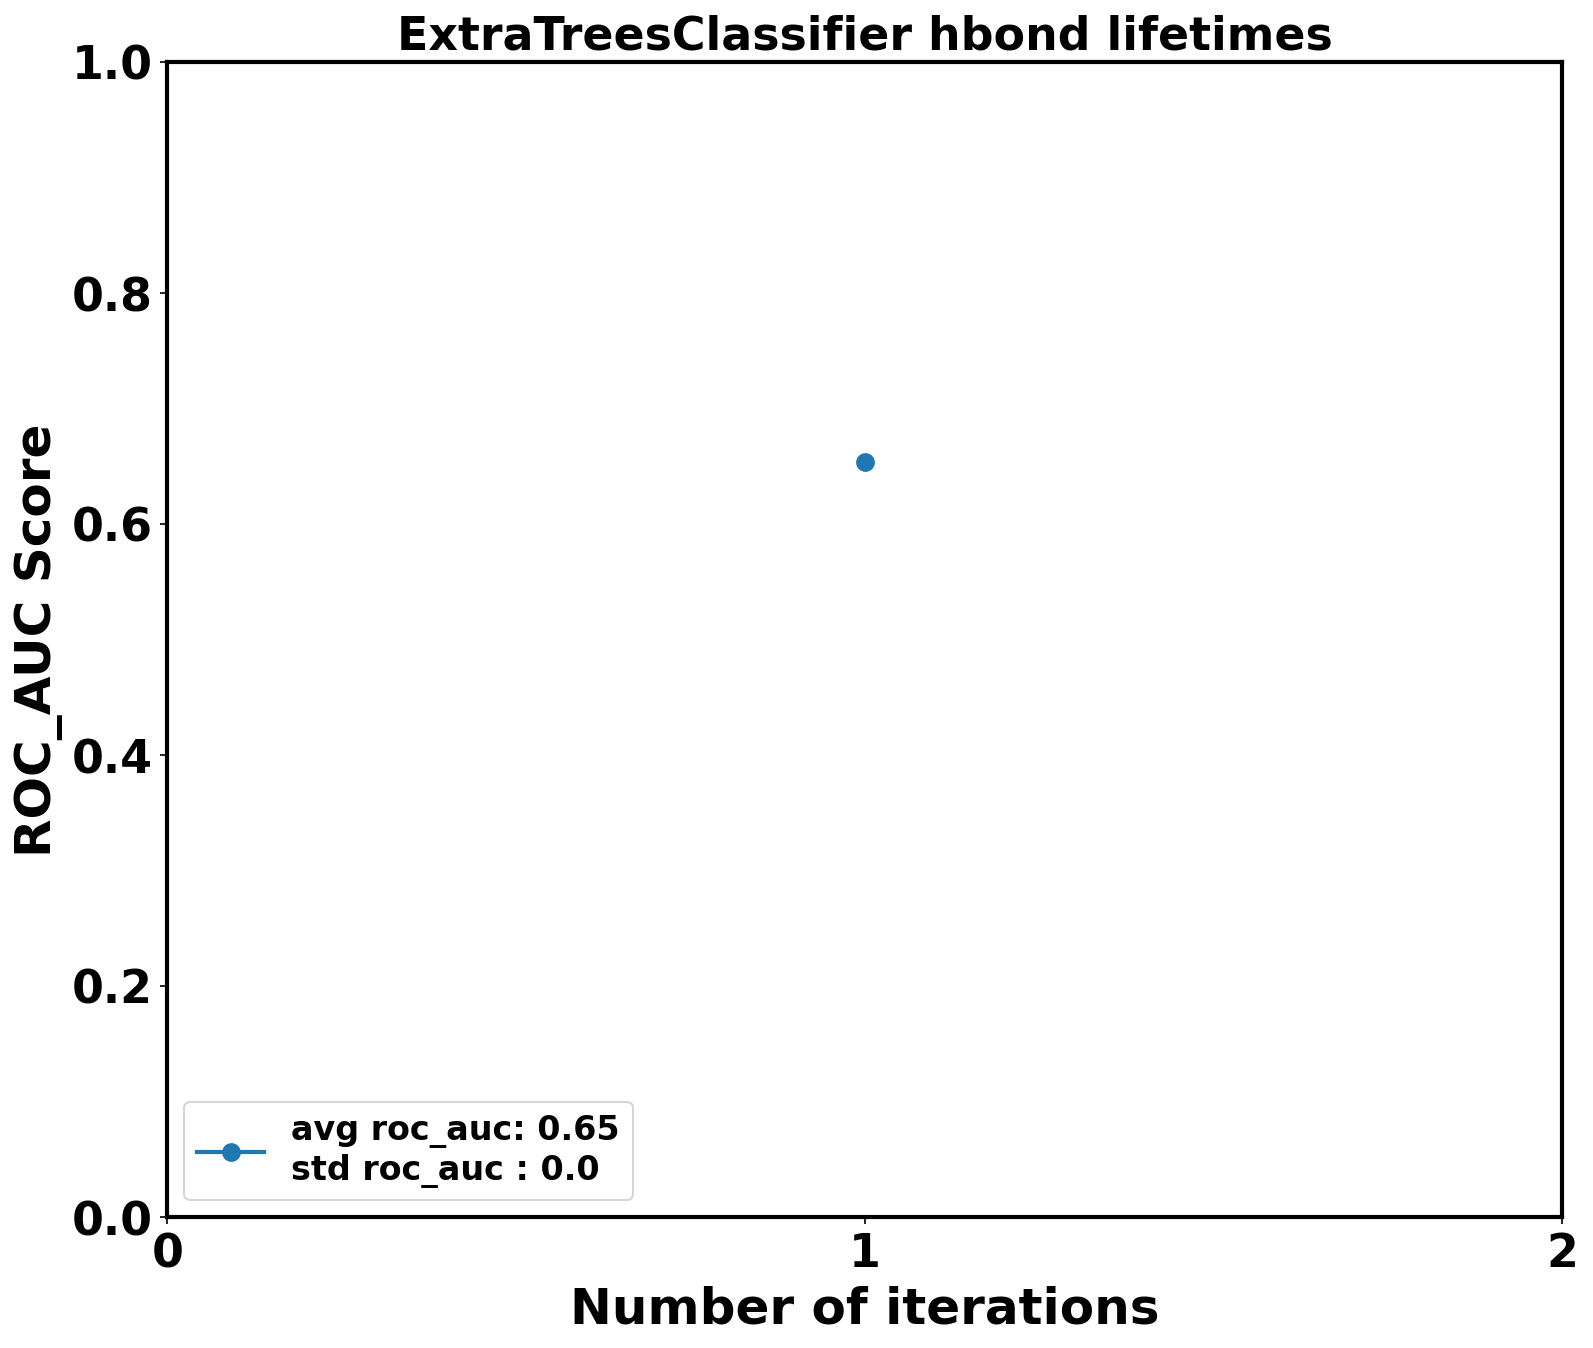

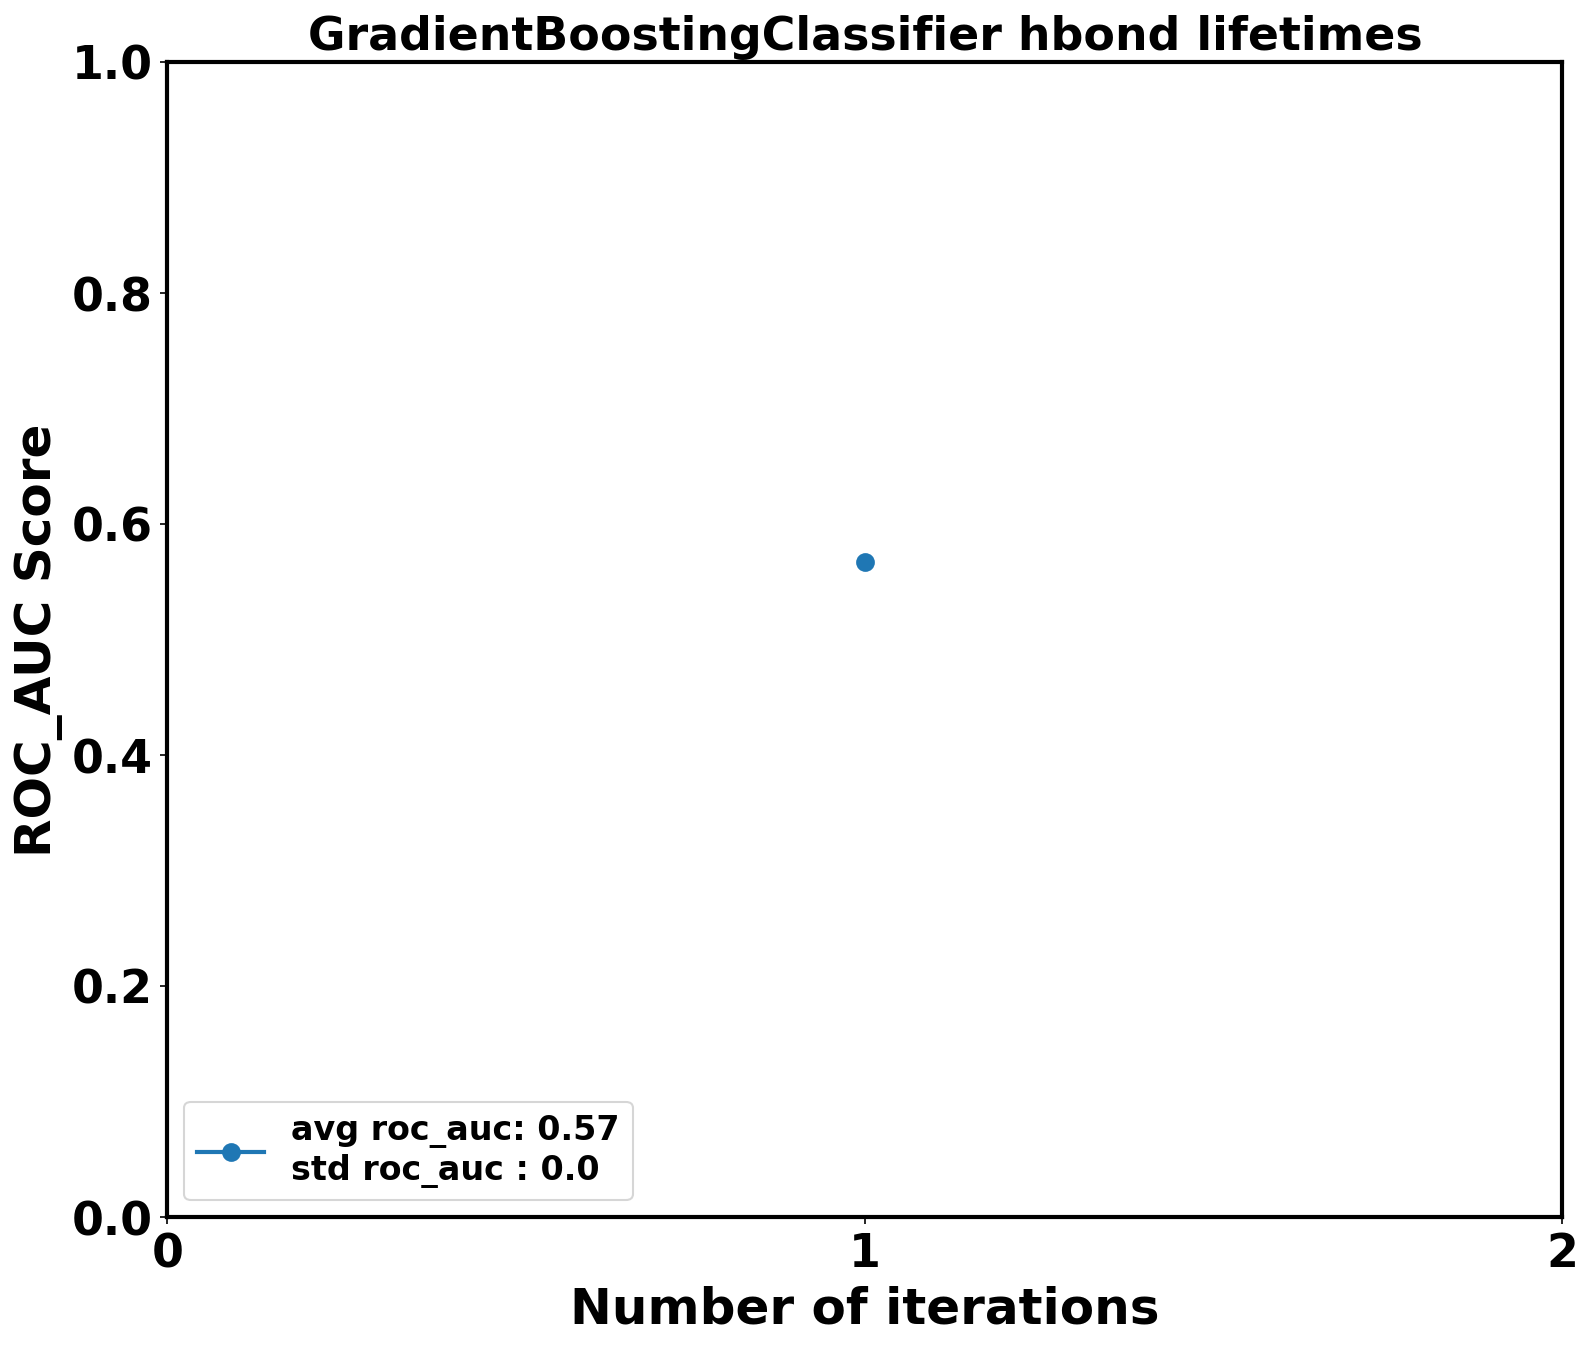

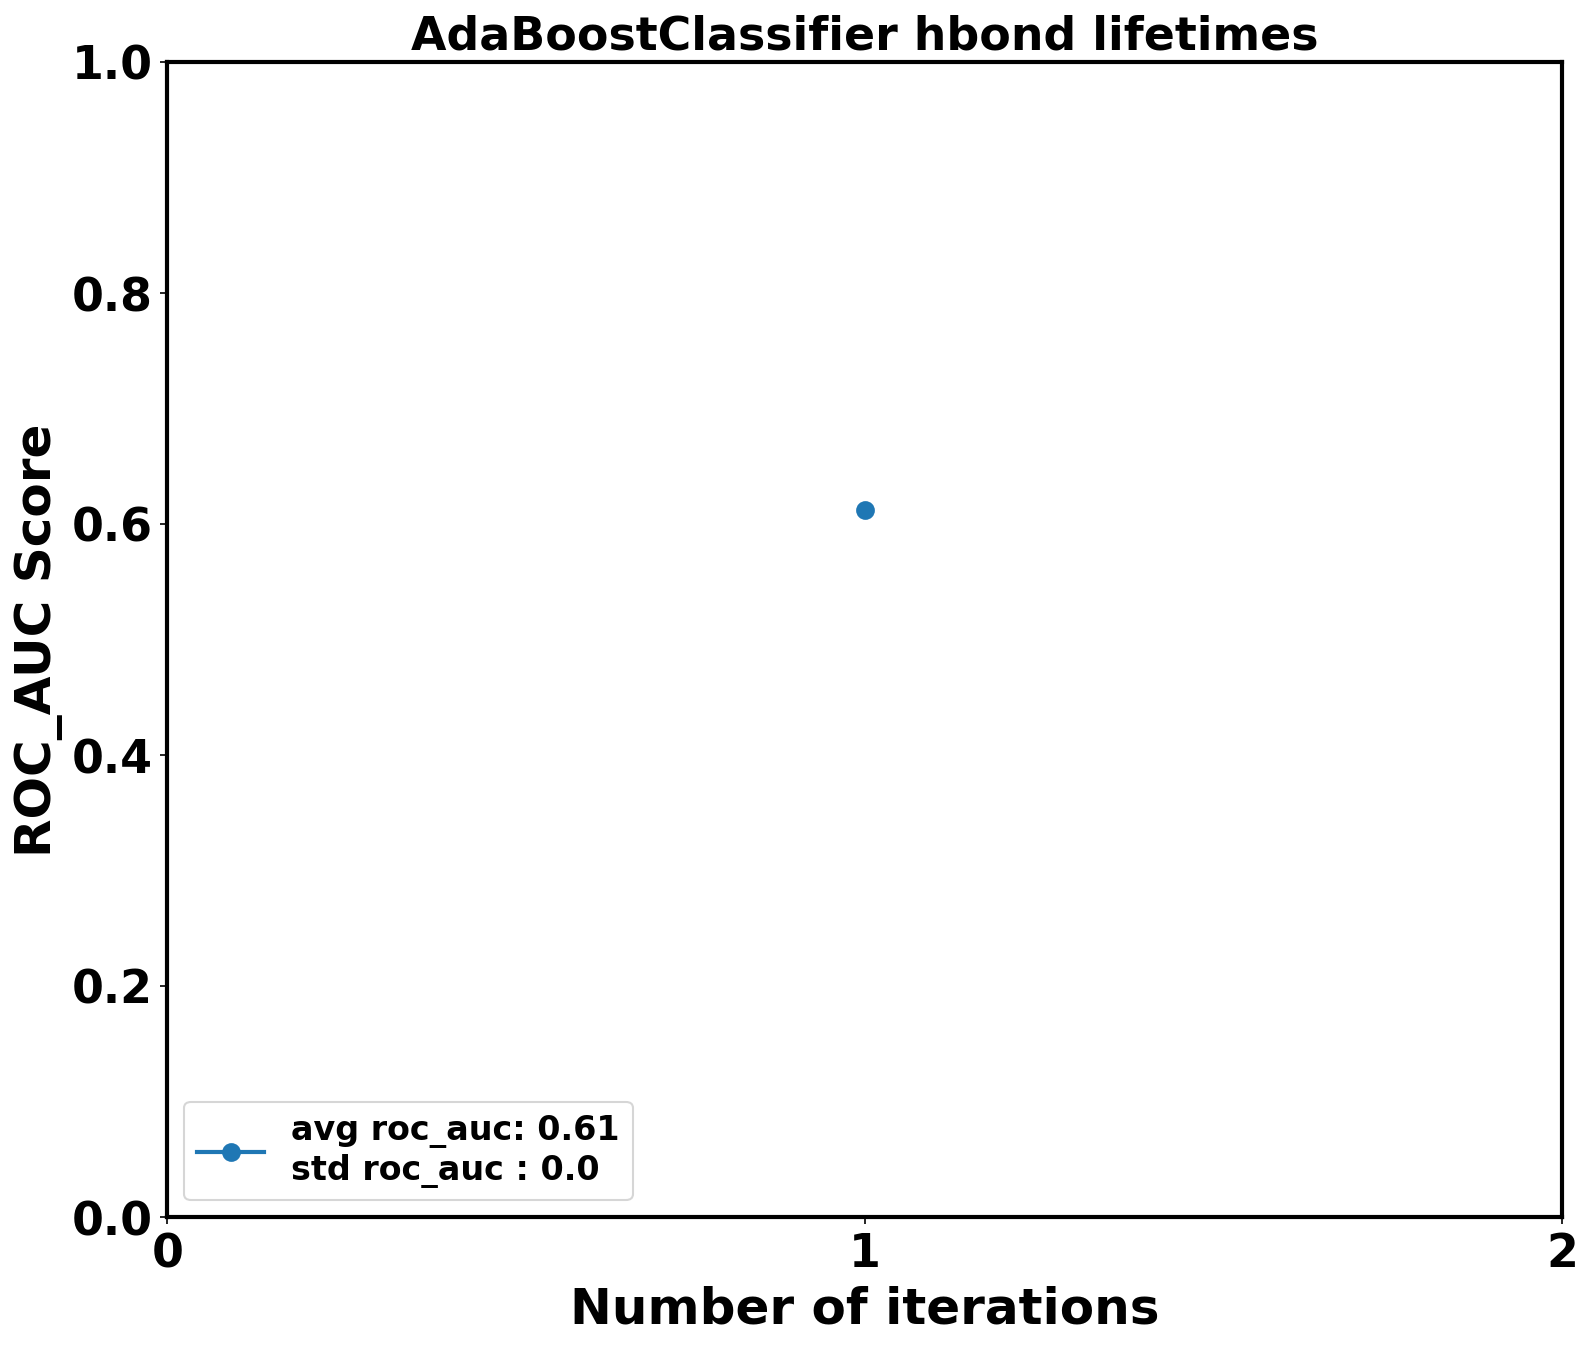

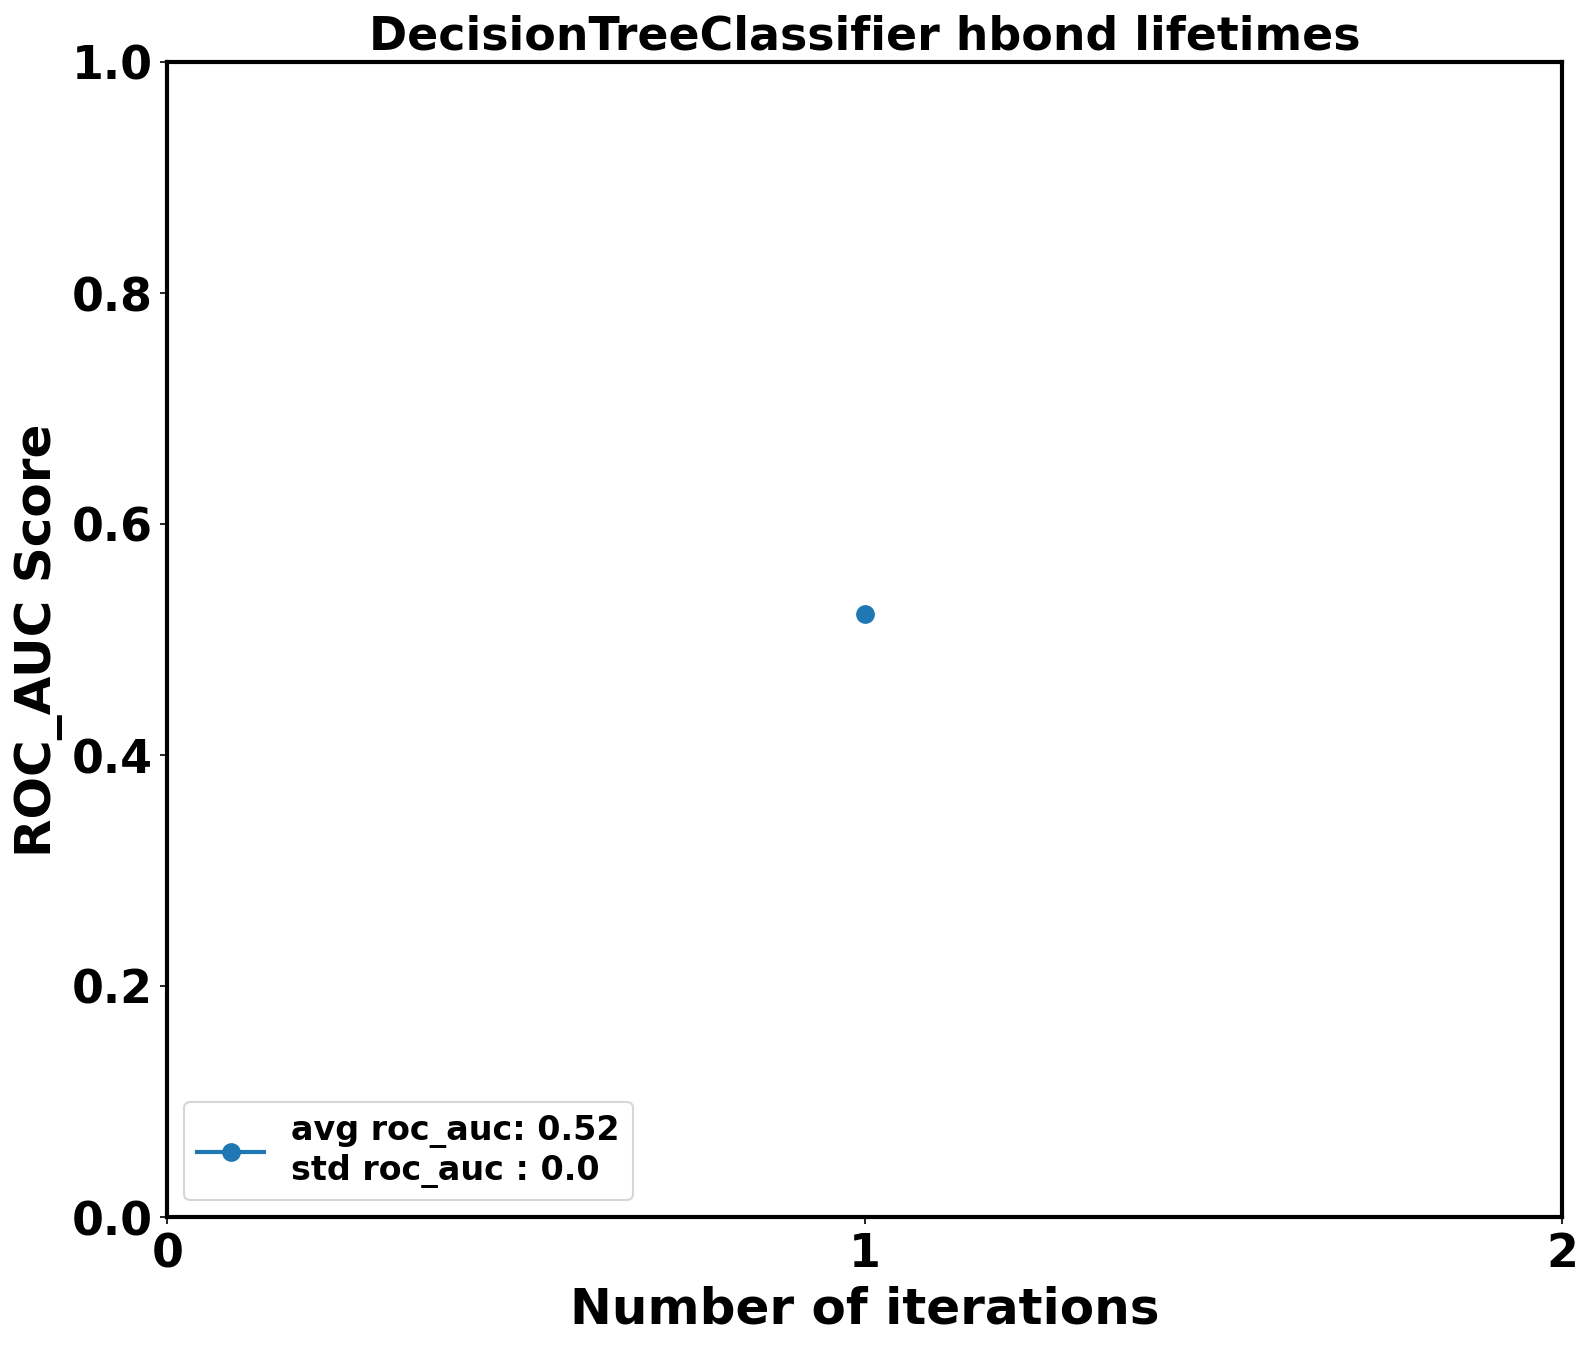

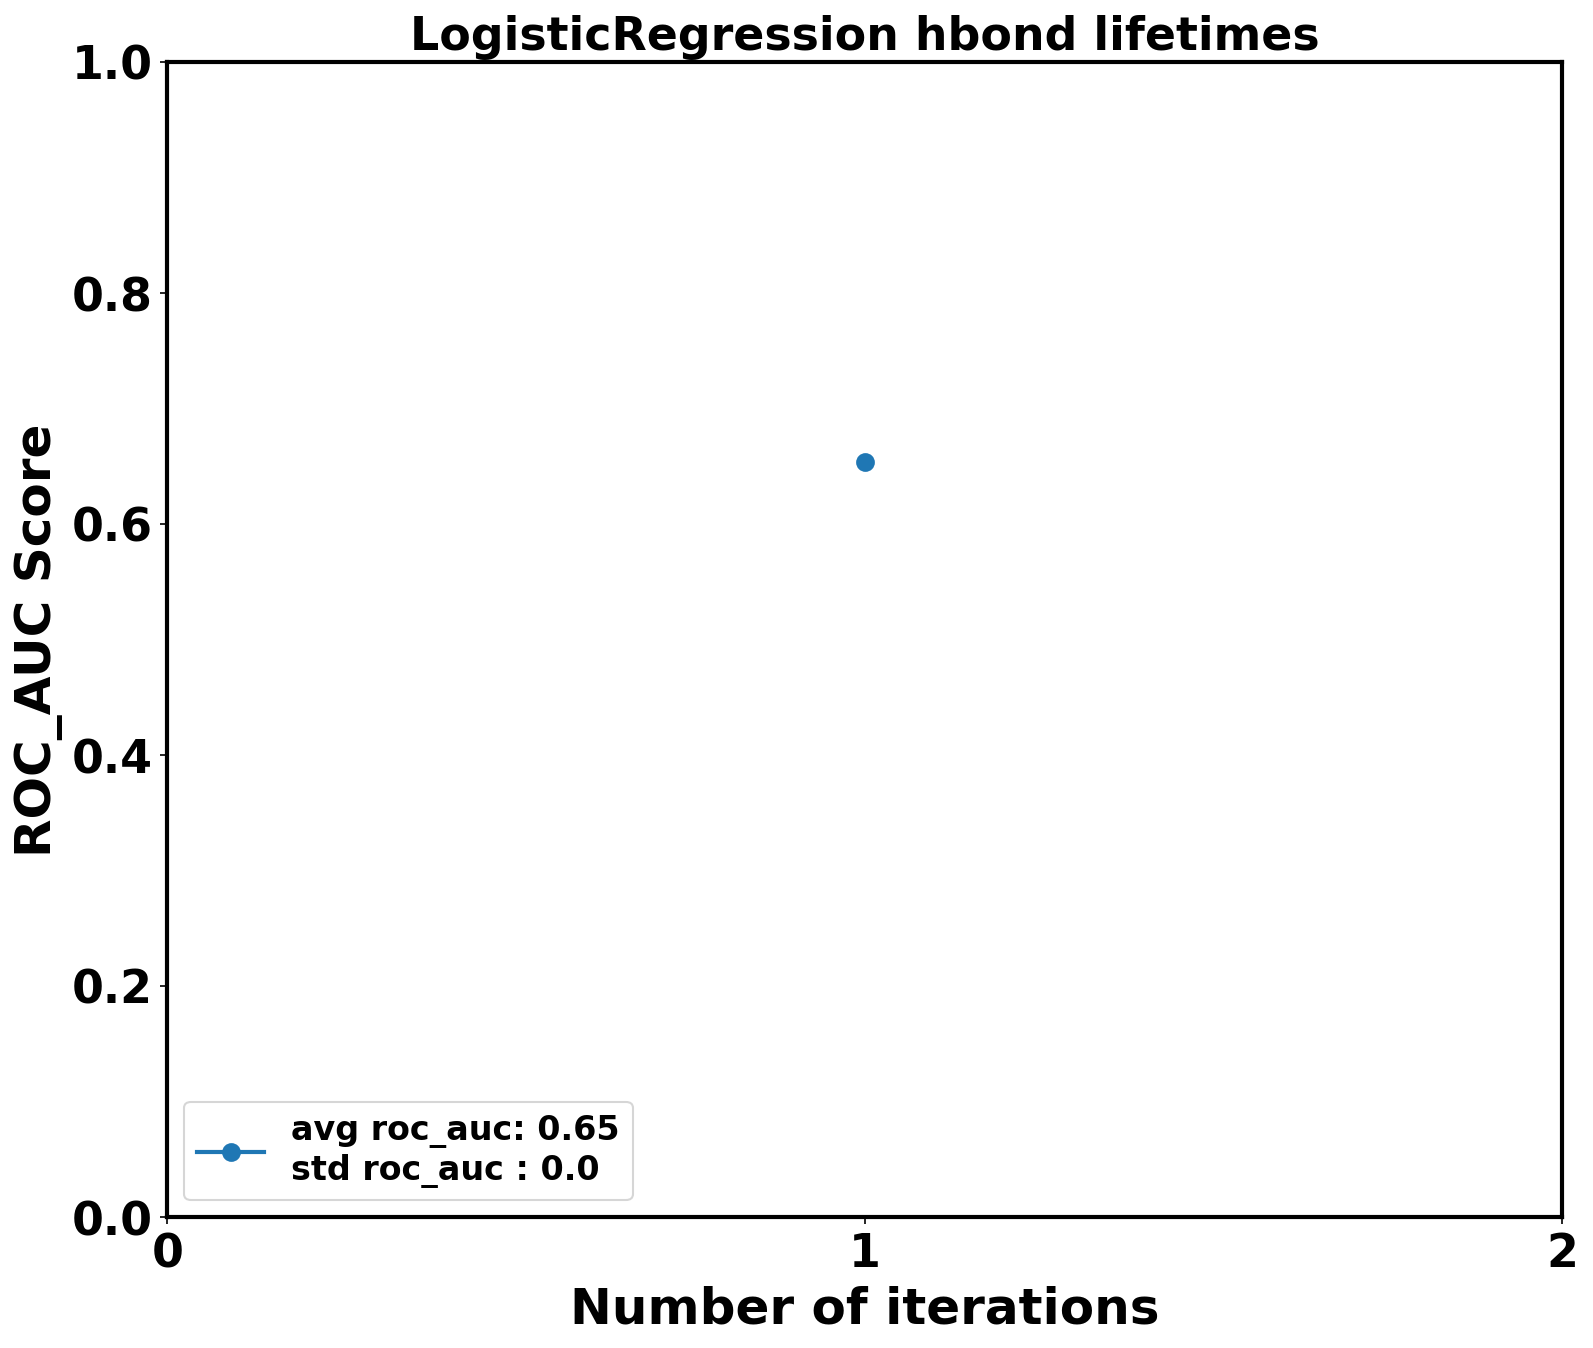

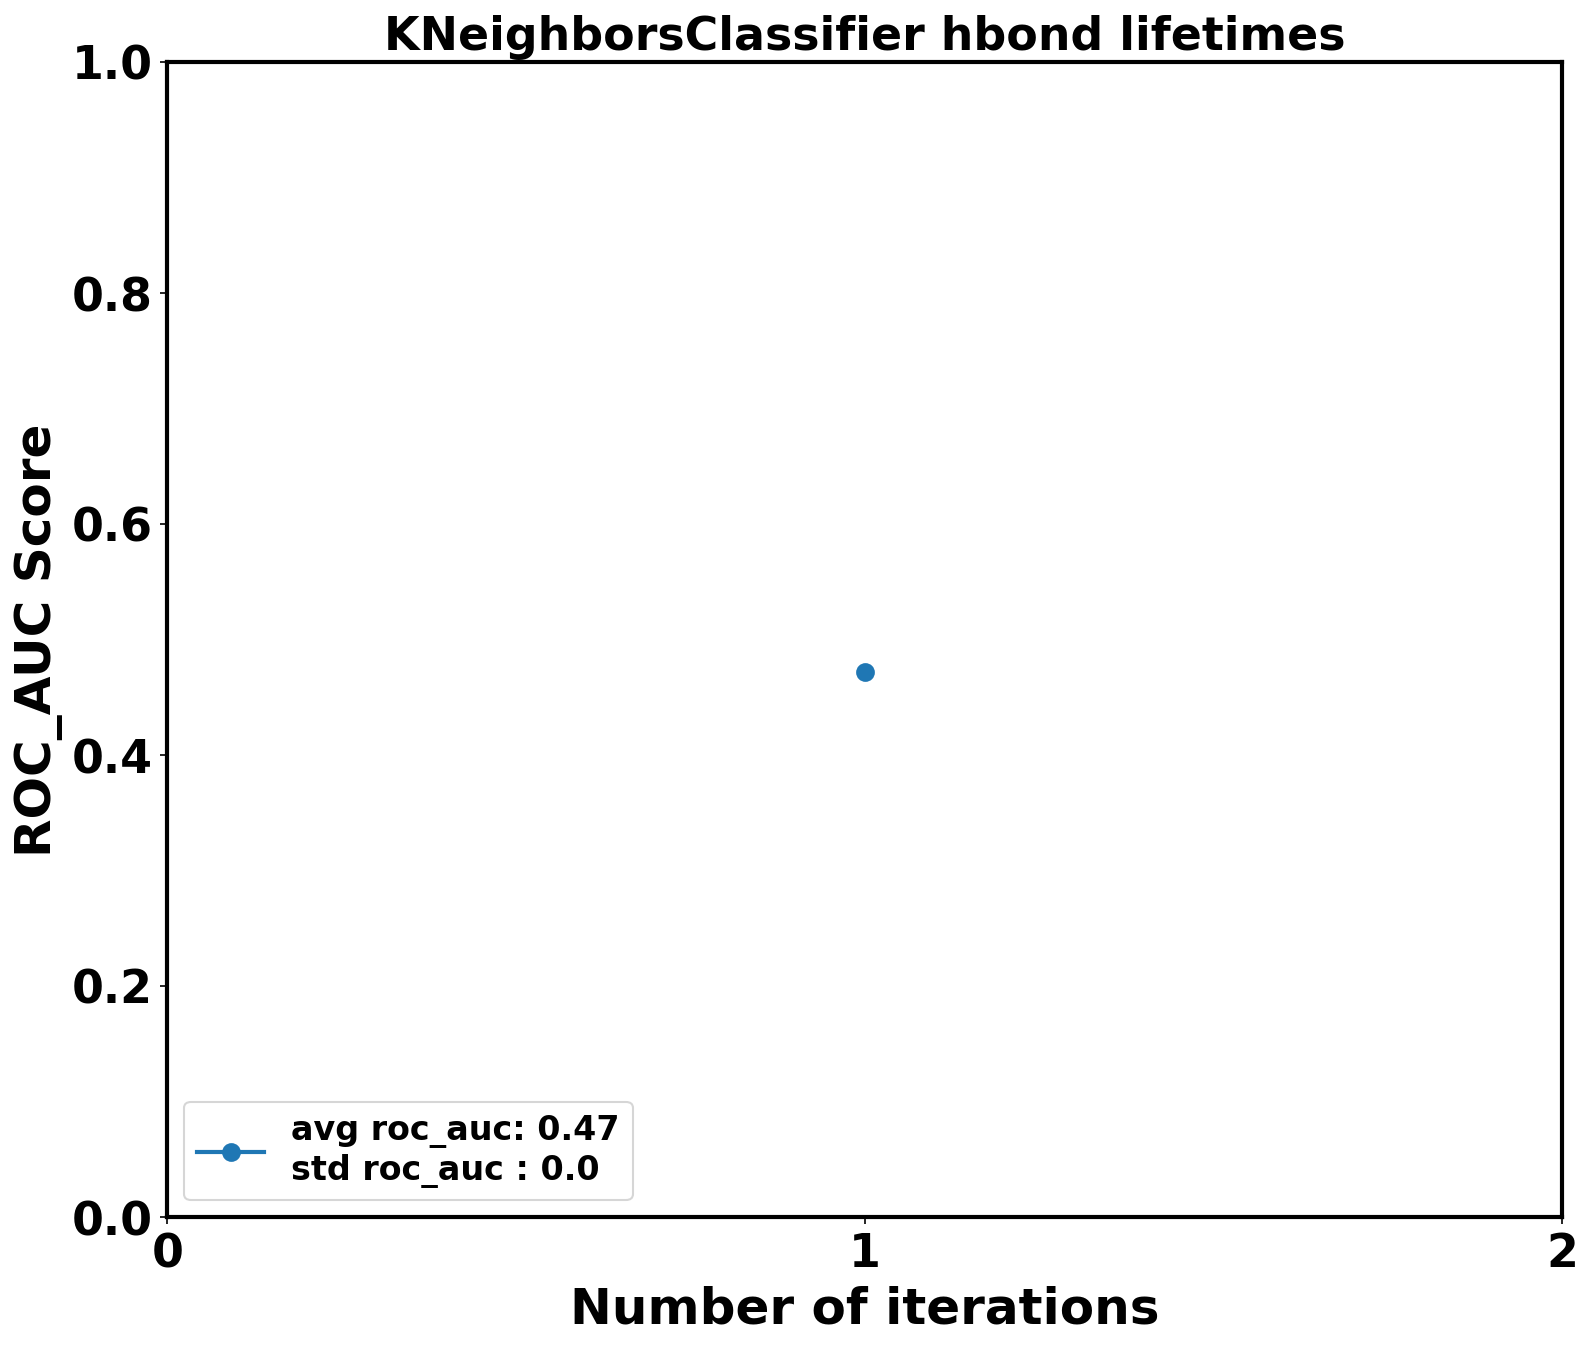

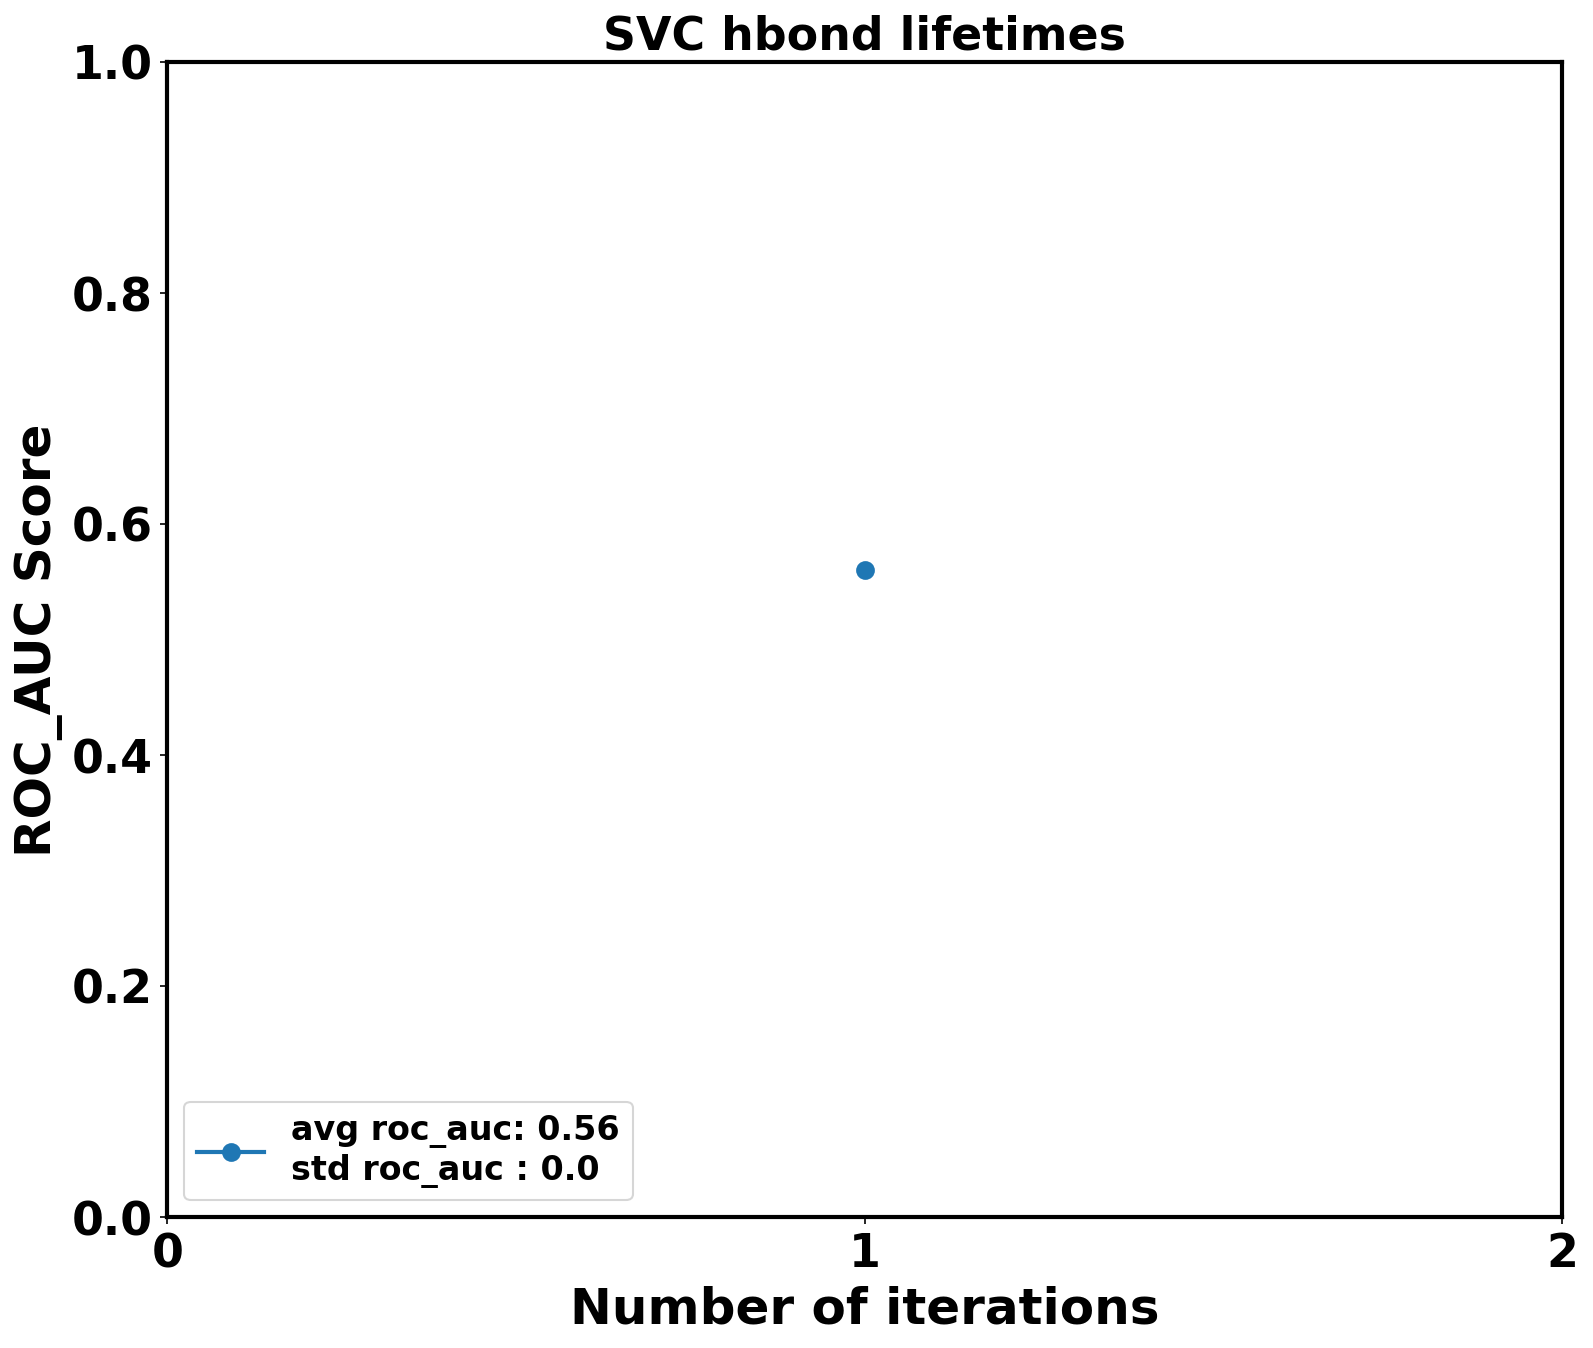

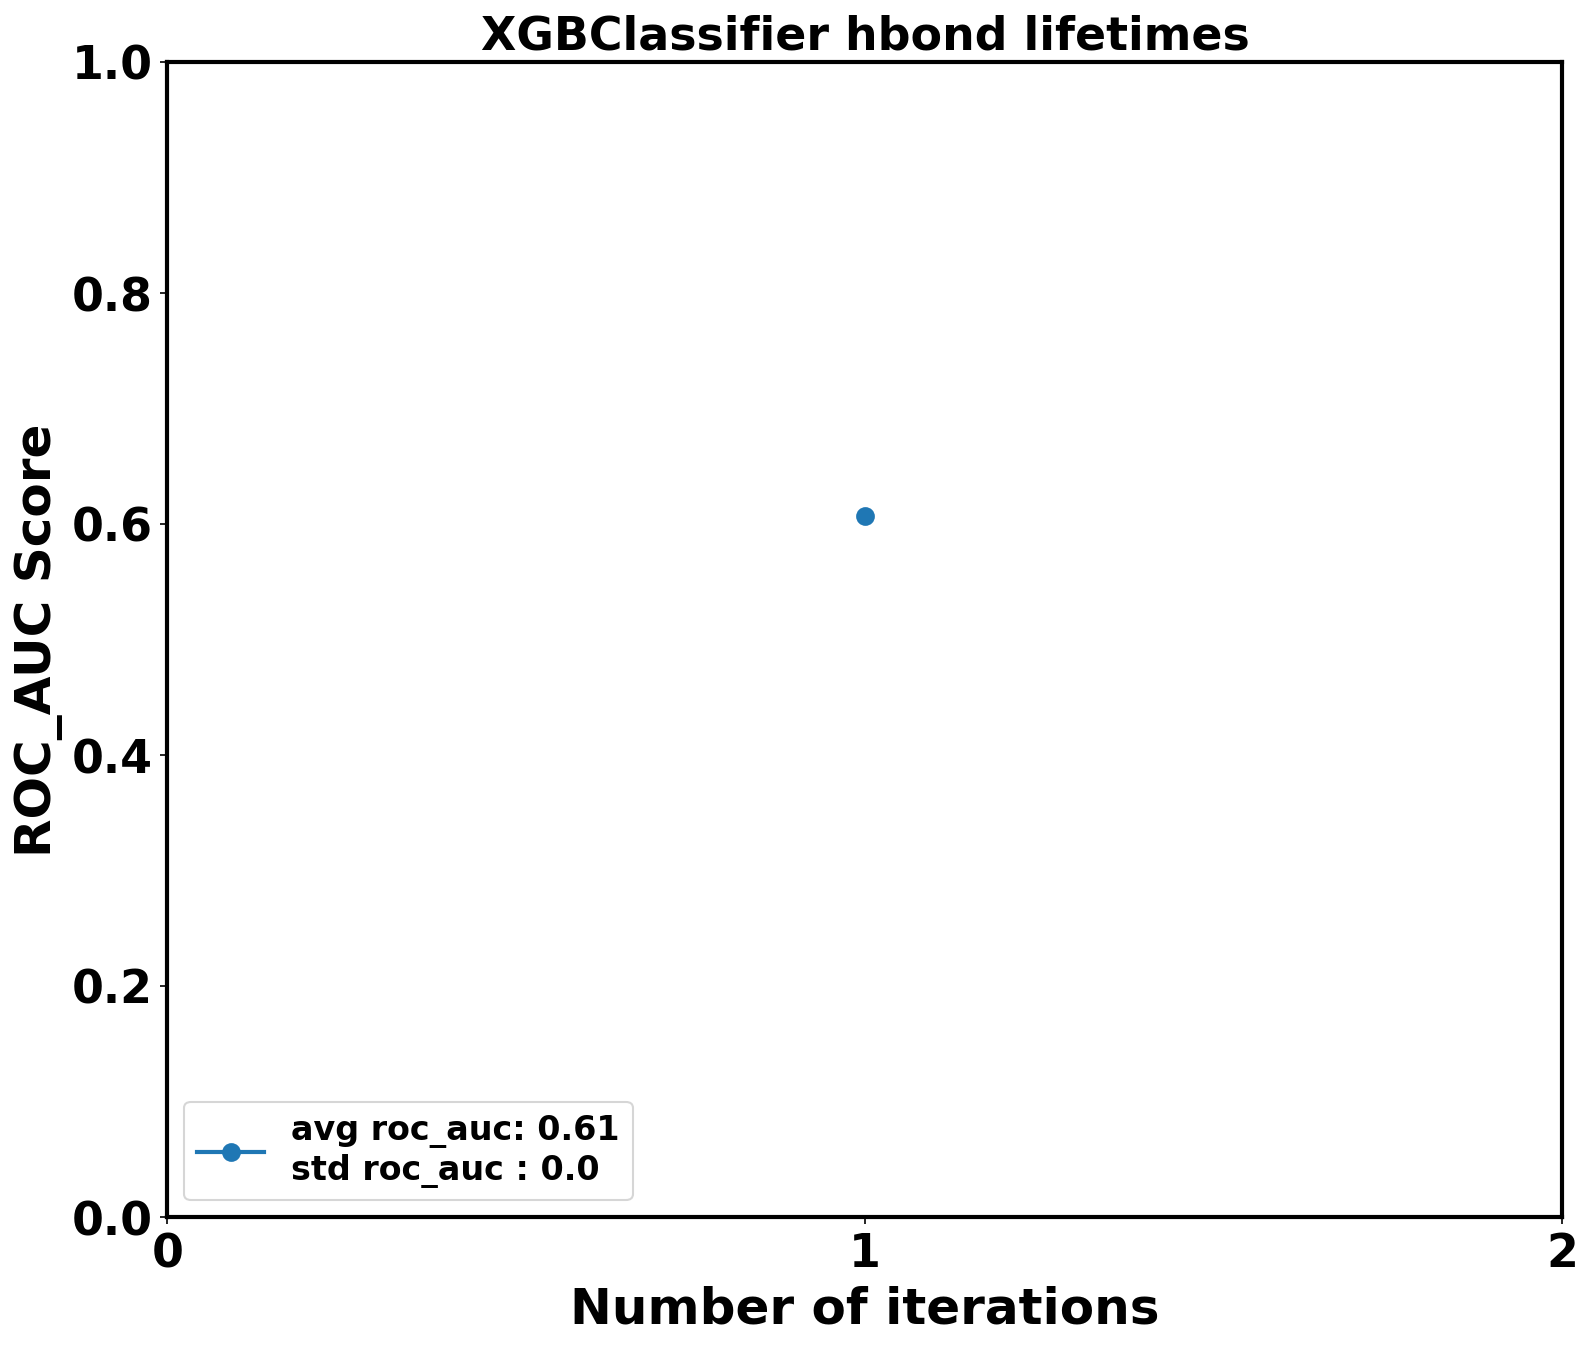

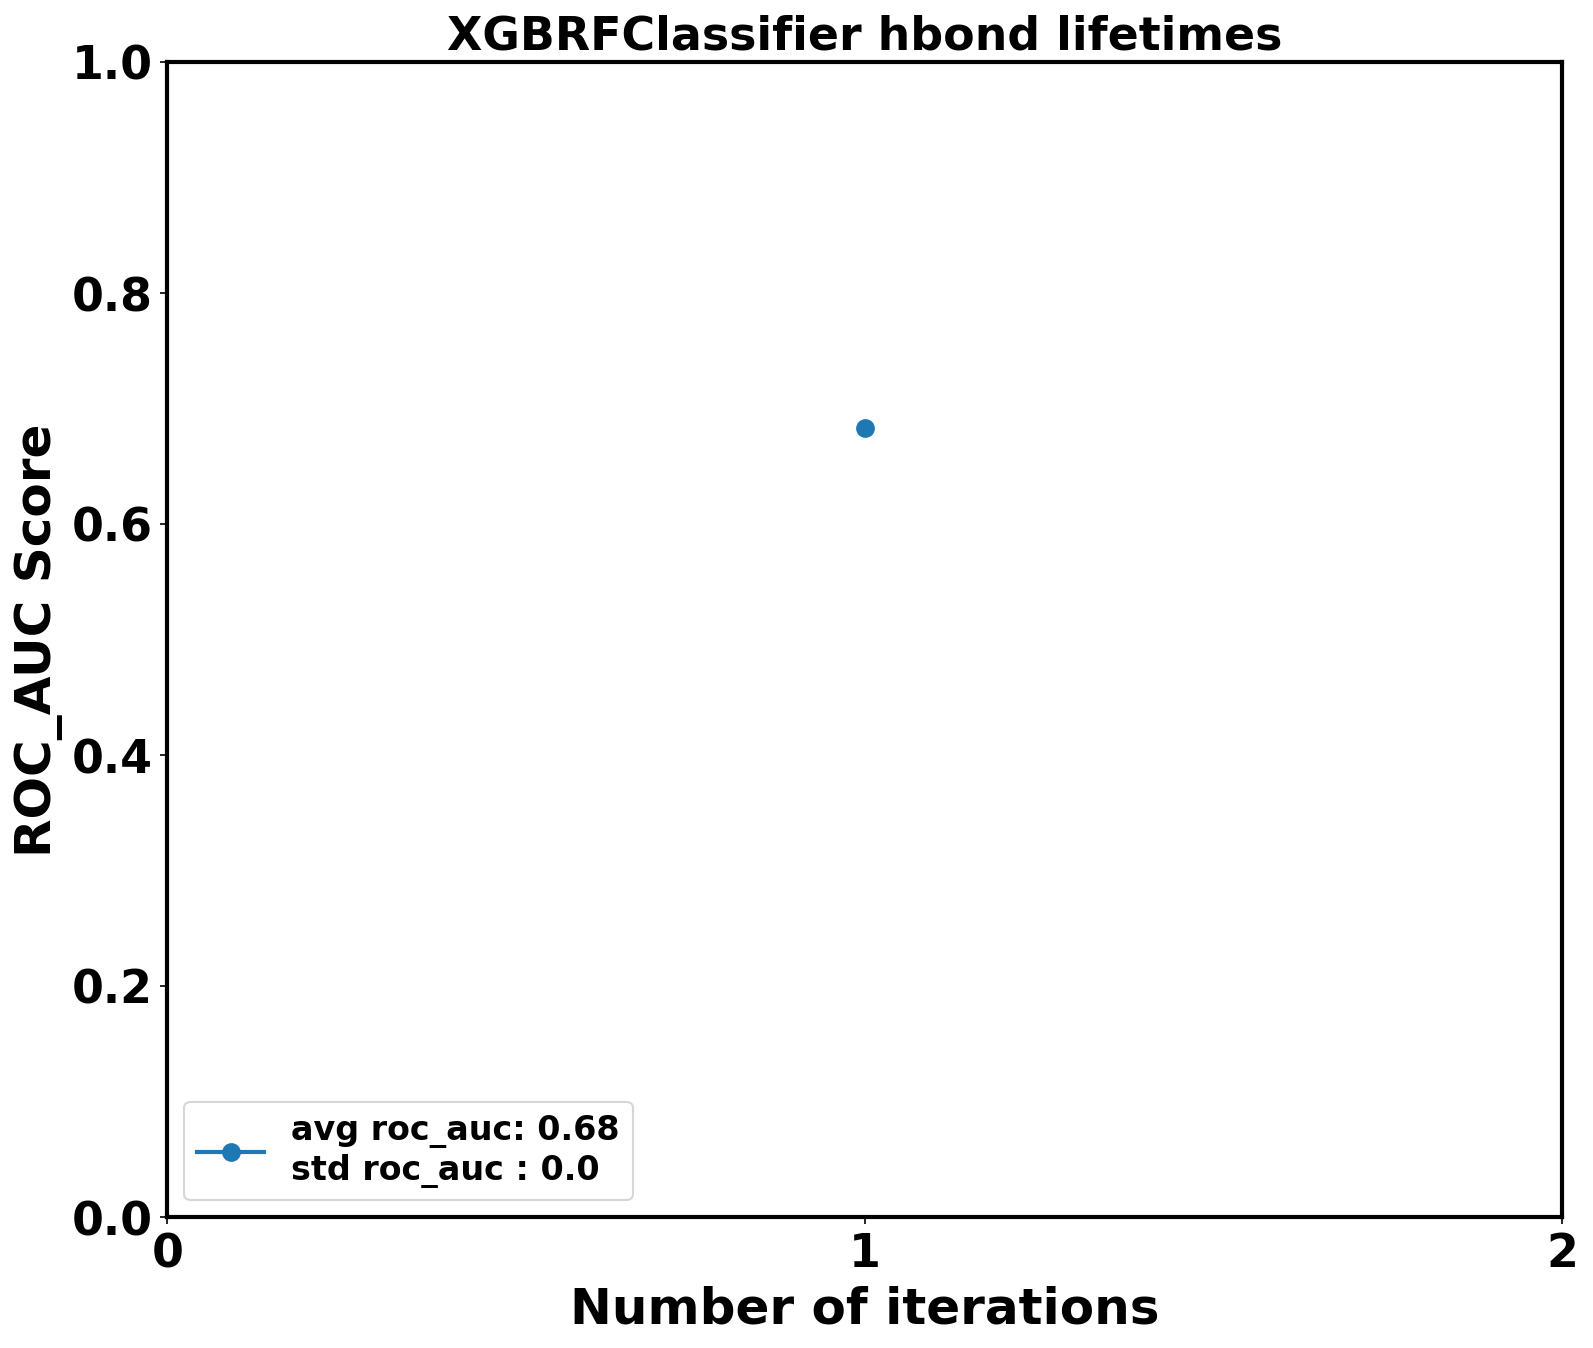

In [23]:
# Validation with lignin dataset

plt.rcParams.update({
    "font.weight": "bold",
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    'font.size': 18,
    'axes.labelweight': 'bold',
    'figure.dpi': 150.0,
})

xdate = datetime.datetime.now().strftime("%m-%d-%Y")
rand_seed = 100
n_repeat = 1
folder_type='hlife'
folder_types = ['hlife', 'hnum', 'merged']
tag = "LR"

models = {
    "RF": "RandomForestClassifier",
    "EF": "ExtraTreesClassifier",
    "GB": "GradientBoostingClassifier",
    "AB": "AdaBoostClassifier",
    "DT": "DecisionTreeClassifier",
    "LR": "LogisticRegression",
    "KNN": "KNeighborsClassifier",
    "SVC": "SVC",
    "XGB": "XGBClassifier",
    "XGBRF": "XGBRFClassifier"

}


for model_tag in models.keys():
    model = models[model_tag]
    model_type = load(f'./saved-models/{folder_type}/{model}_{folder_type}.joblib')
    model_name = model_type.__str__().split('(')[0]
    # print(f"{tag} training for {n_repeat} runs")

    dirmaker(f'./model-logs/validation/{folder_type}/{xdate}')
    file_name = open(f"./model-logs/validation/{folder_type}/{xdate}/{model_name}_{lig}_{folder_type}_{n_repeat}_{xdate}_{rand_seed}.txt", "w+")     

    X, Y = data_validate(des_df_hlife, nondes_df_hlife, batch_size=17)   
    validate_trained_models(model_type, X, Y,file_name=file_name, folder_type=folder_type, num=n_repeat, rand_seed=rand_seed)

## hnumber only

#### non-des hnum

In [24]:
nondes_df_hnum = nondes_hnum_lignin.drop(columns=['DES'])  # should change this to non-DES
nondes_df_hnum['output'] = 0
nondes_df_hnum

,A-A,B-B,A-B,A-A/B-B,A-B/(A-A + B-B),output
0,29.220779,35.496503,53.883117,0.823202,0.832592,0
1,23.880120,36.495504,52.185814,0.654330,0.864352,0
2,19.677323,33.202797,53.625375,0.592641,1.014093,0
3,28.627373,14.524476,24.582418,1.970975,0.569672,0
4,31.319680,13.295704,20.875125,2.355624,0.467891,0
5,28.134865,23.941059,47.306693,1.175172,0.908418,0
6,4.645355,37.891109,55.707293,0.122597,1.309636,0
7,8.237762,33.521479,53.111888,0.245746,1.271860,0
8,11.348651,12.844156,19.481518,0.883565,0.805261,0
9,22.141858,5.708292,35.677323,3.878894,1.281046,0


#### des hnum

In [25]:
des_df_hnum = des_hnum_lignin.drop(columns=['DES'])  # should change this to DES
des_df_hnum['output'] = 1
des_df_hnum

,A-A,B-B,A-B,A-A/B-B,A-B/(A-A + B-B),output
0,19.658342,11.382617,40.727273,1.727049,1.312049,1
1,8.469530,33.392607,54.238761,0.253635,1.295652,1
2,57.322677,5.783217,56.630370,9.911902,0.897386,1
3,7.231768,11.285714,22.994006,0.640790,1.241746,1
4,14.178821,3.991009,41.086913,3.552691,2.261271,1
5,12.079920,6.122877,17.978022,1.972916,0.987652,1
6,29.257742,3.379620,24.753247,8.657109,0.758433,1
7,10.435564,10.493506,23.664336,0.994478,1.130692,1
8,5.922078,29.208791,29.870130,0.202750,0.850253,1
9,28.118881,7.314685,31.552448,3.844168,0.890468,1


## Validation

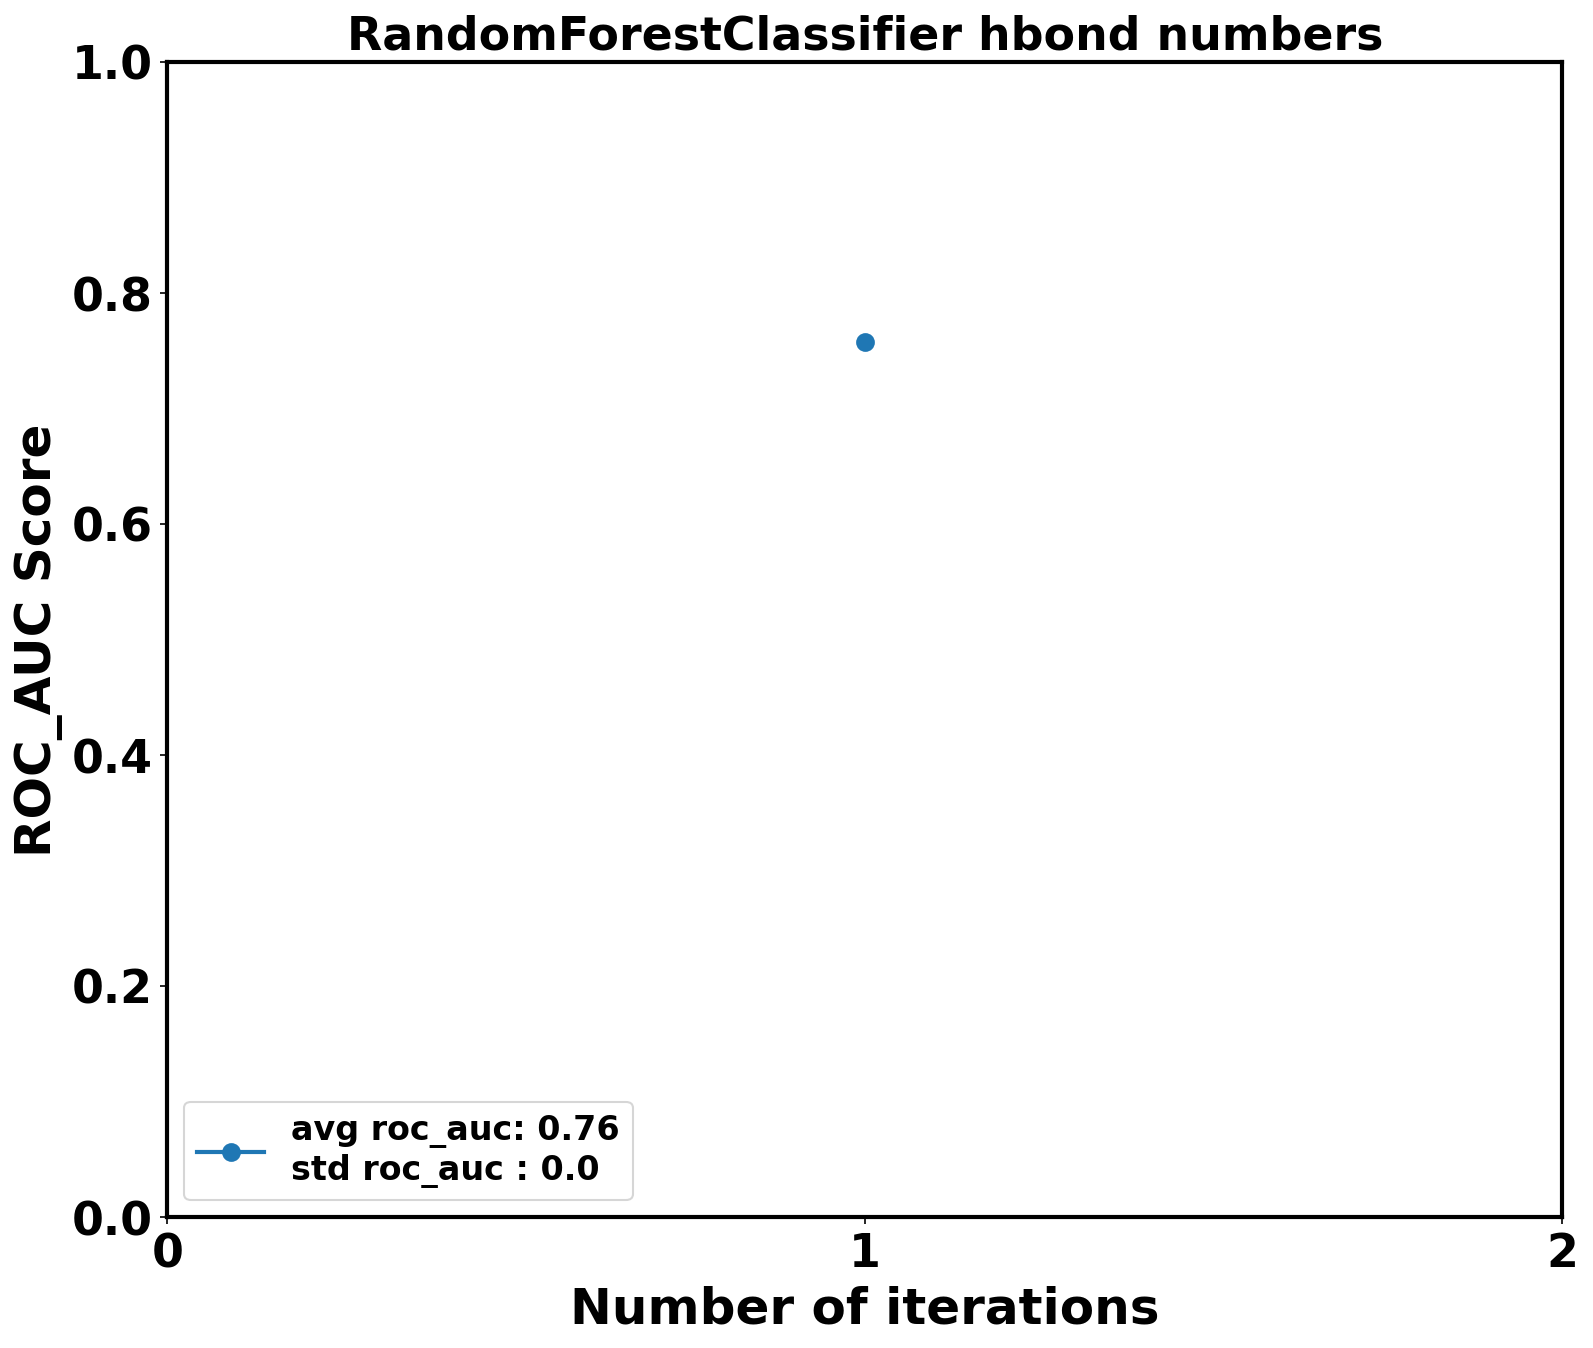

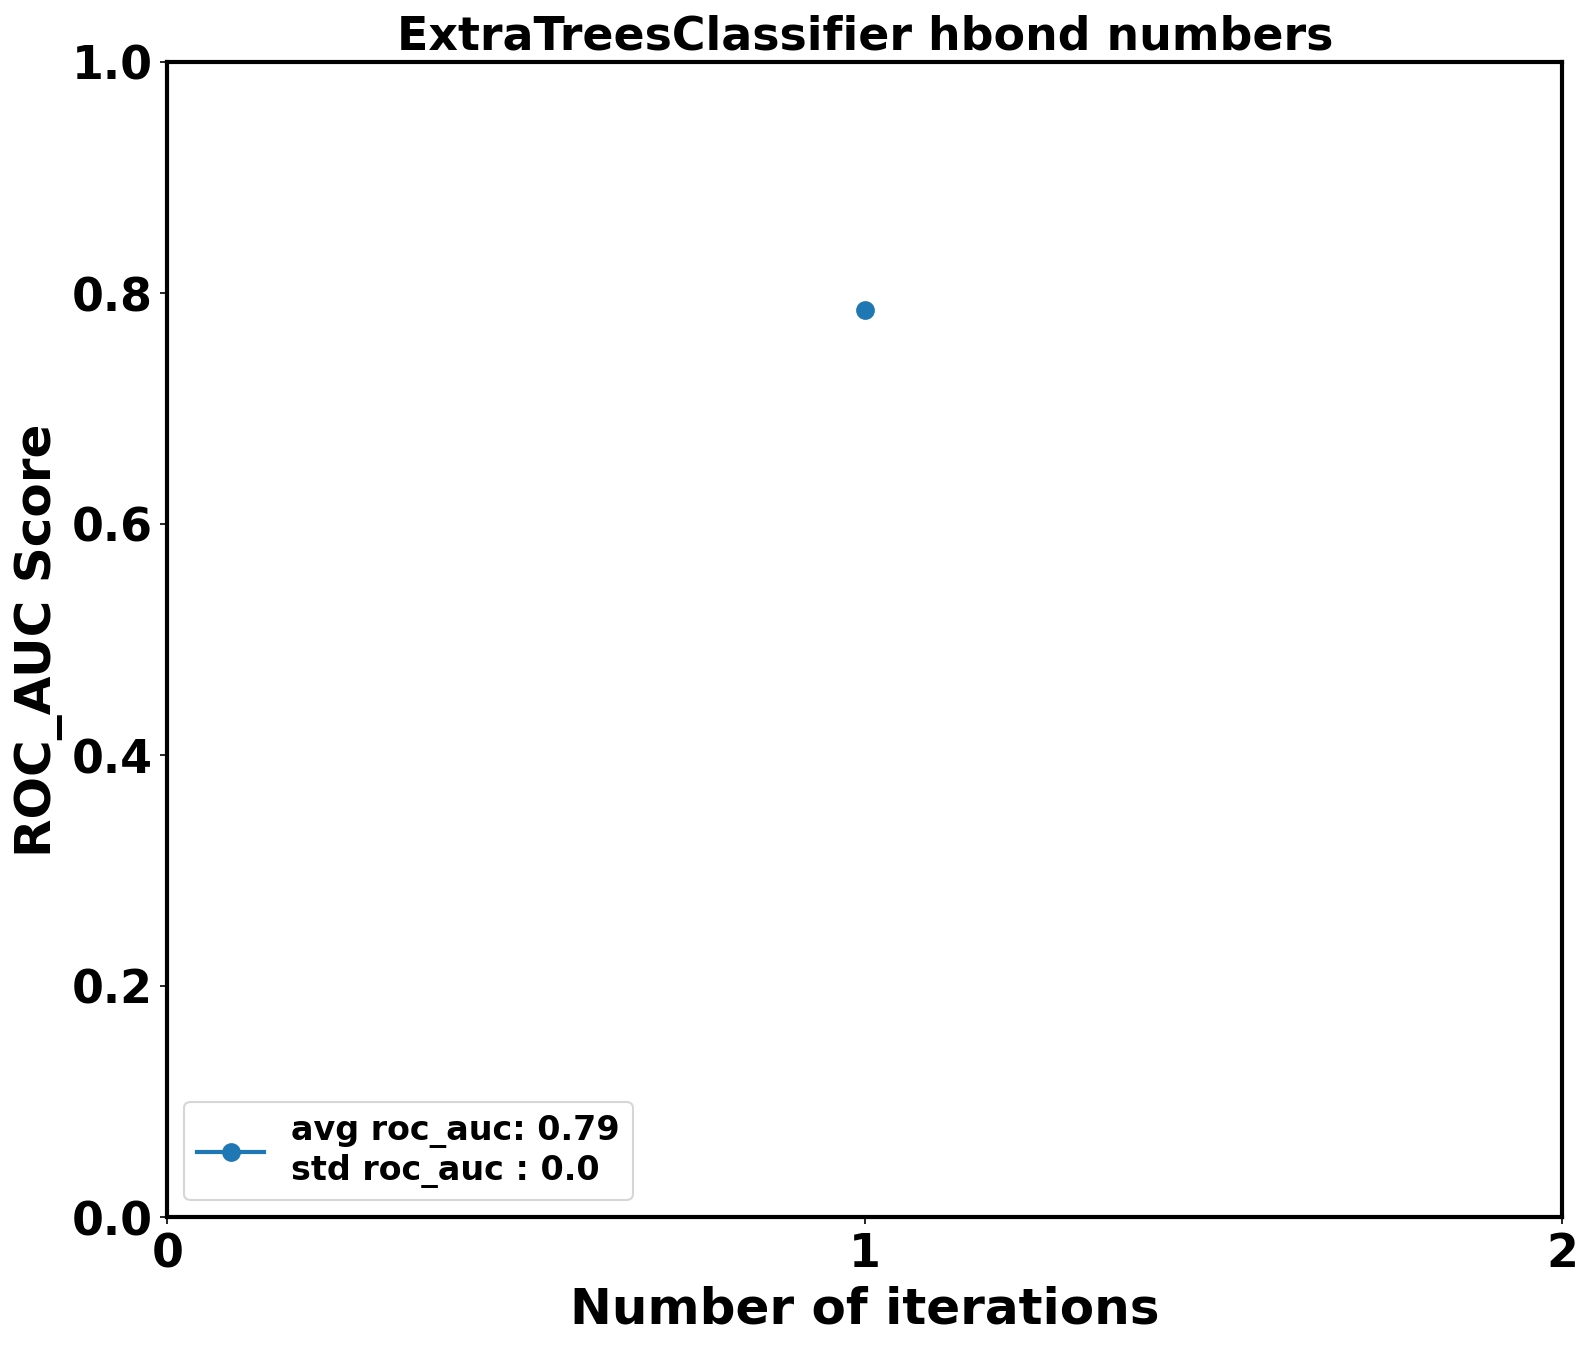

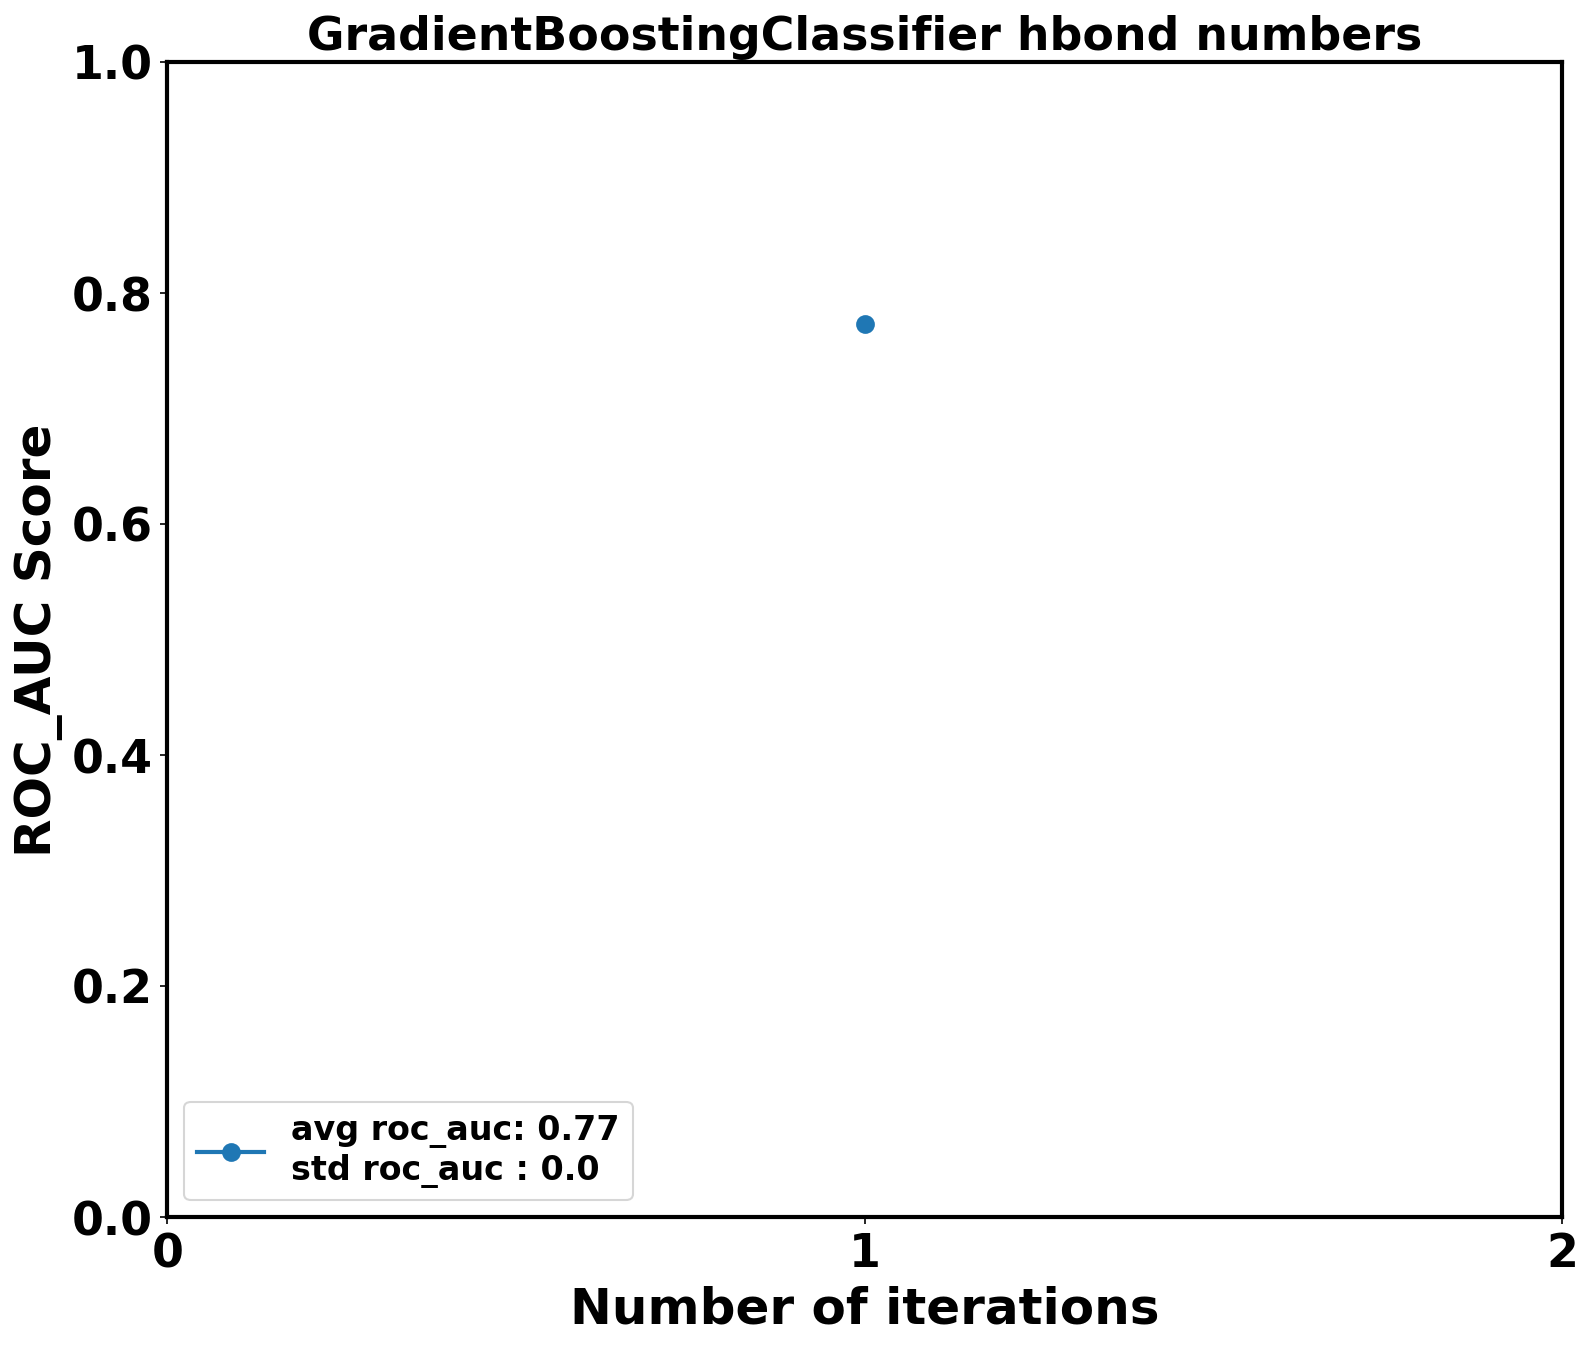

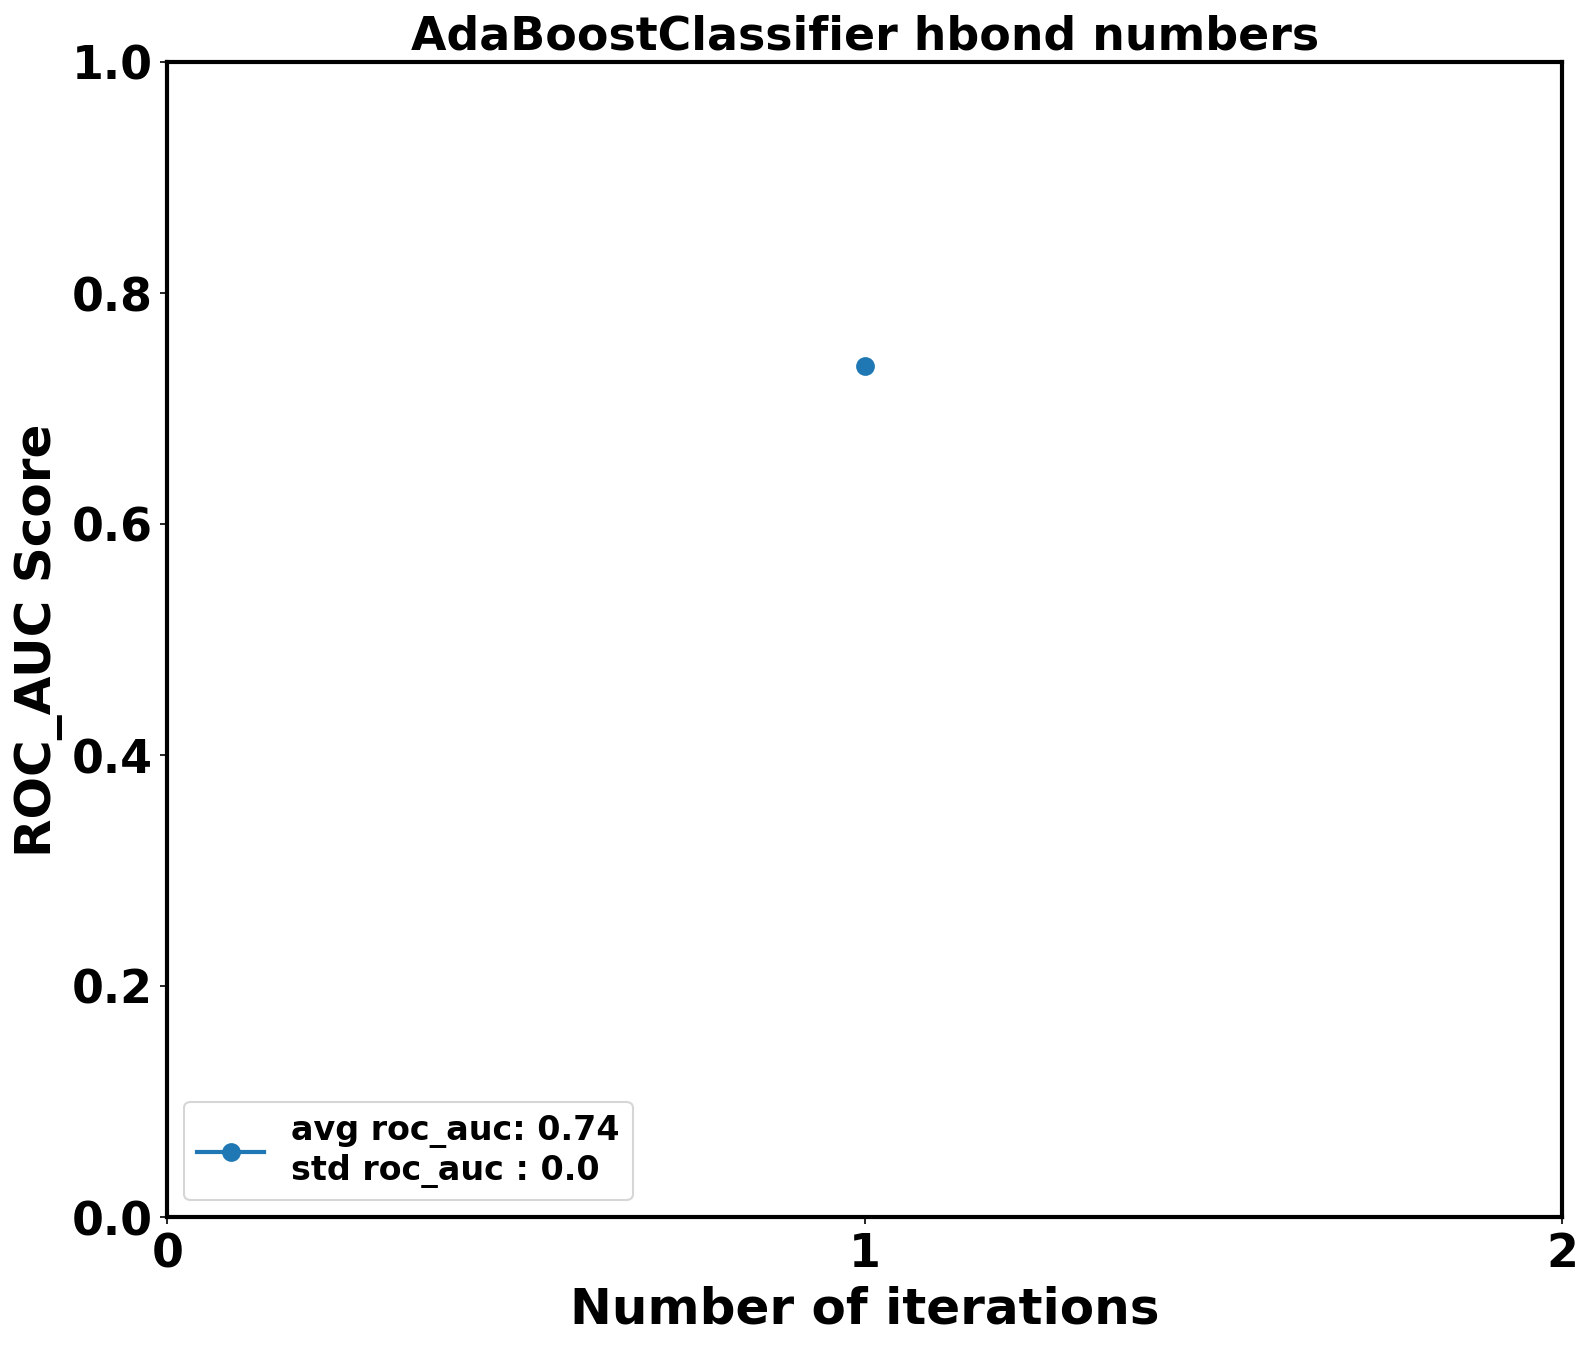

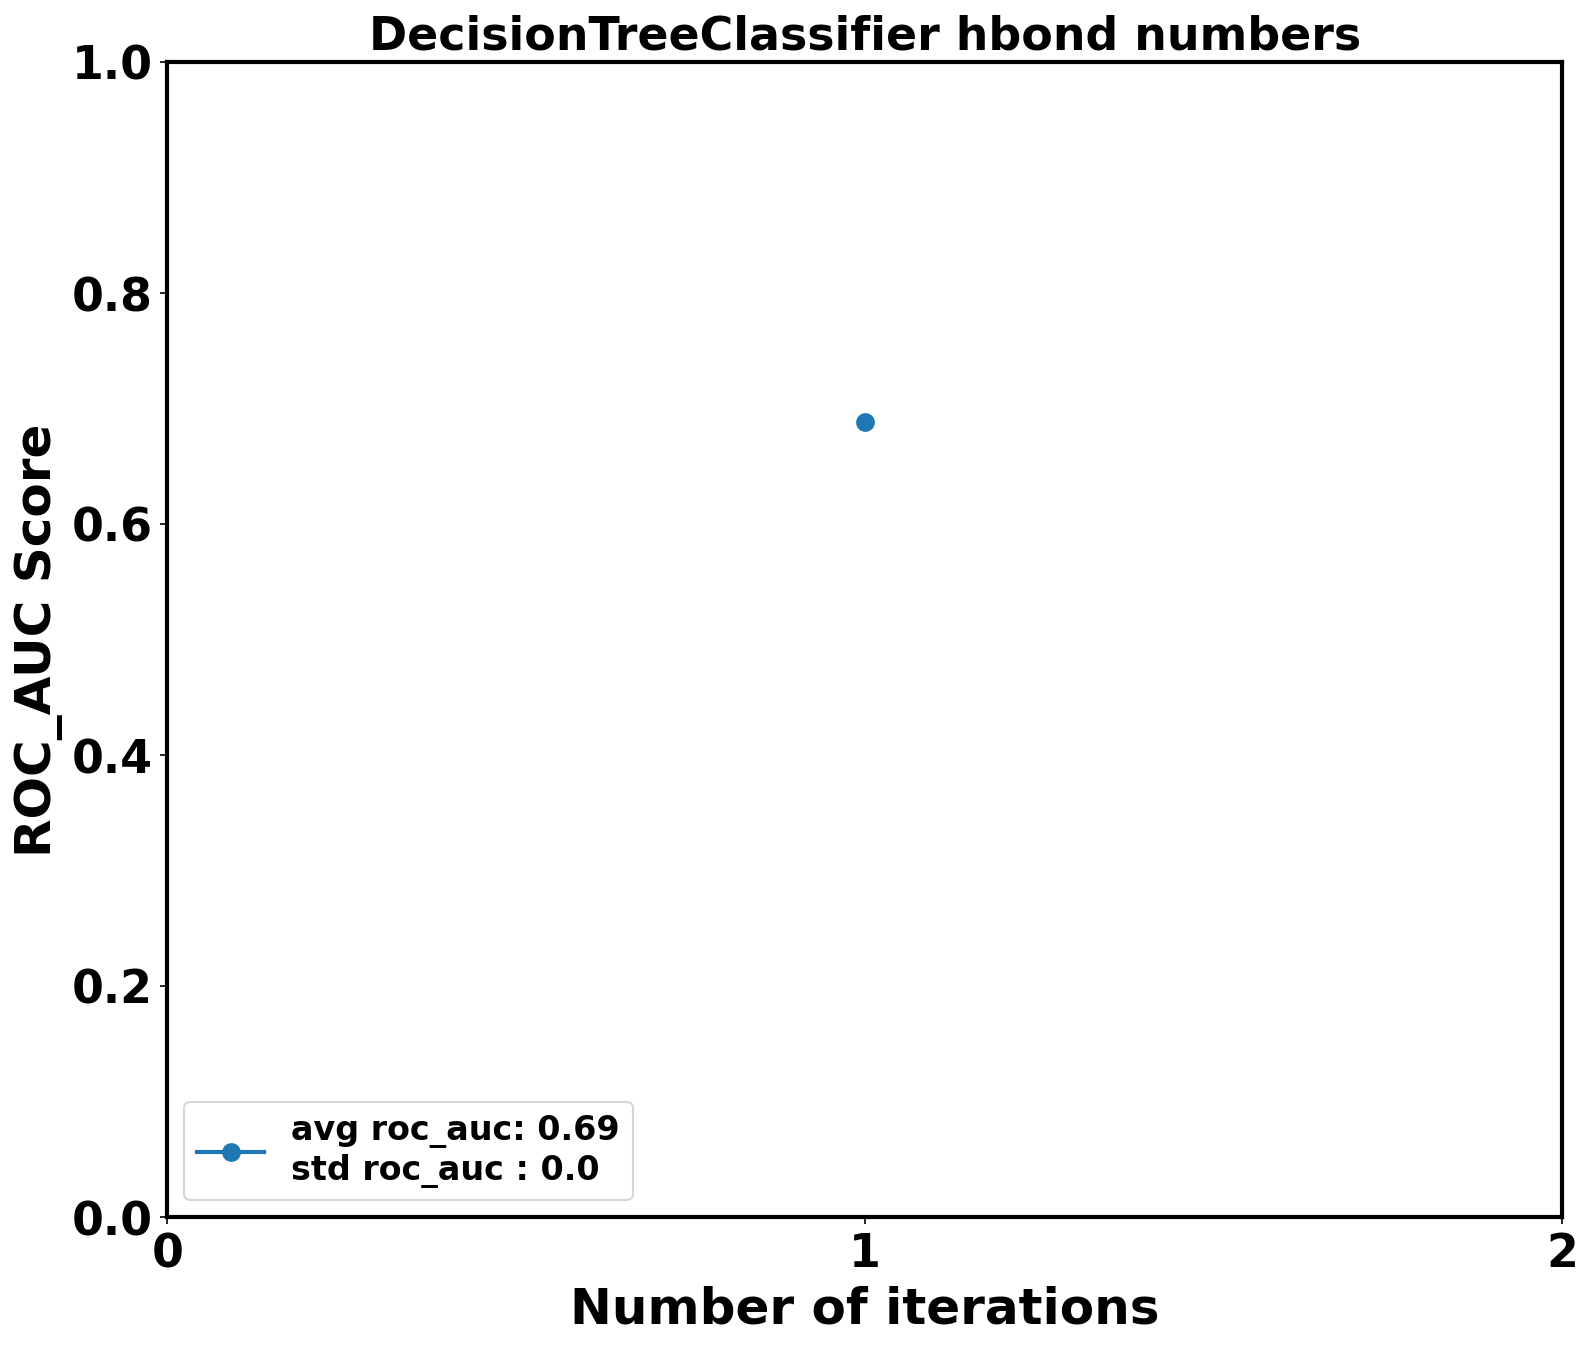

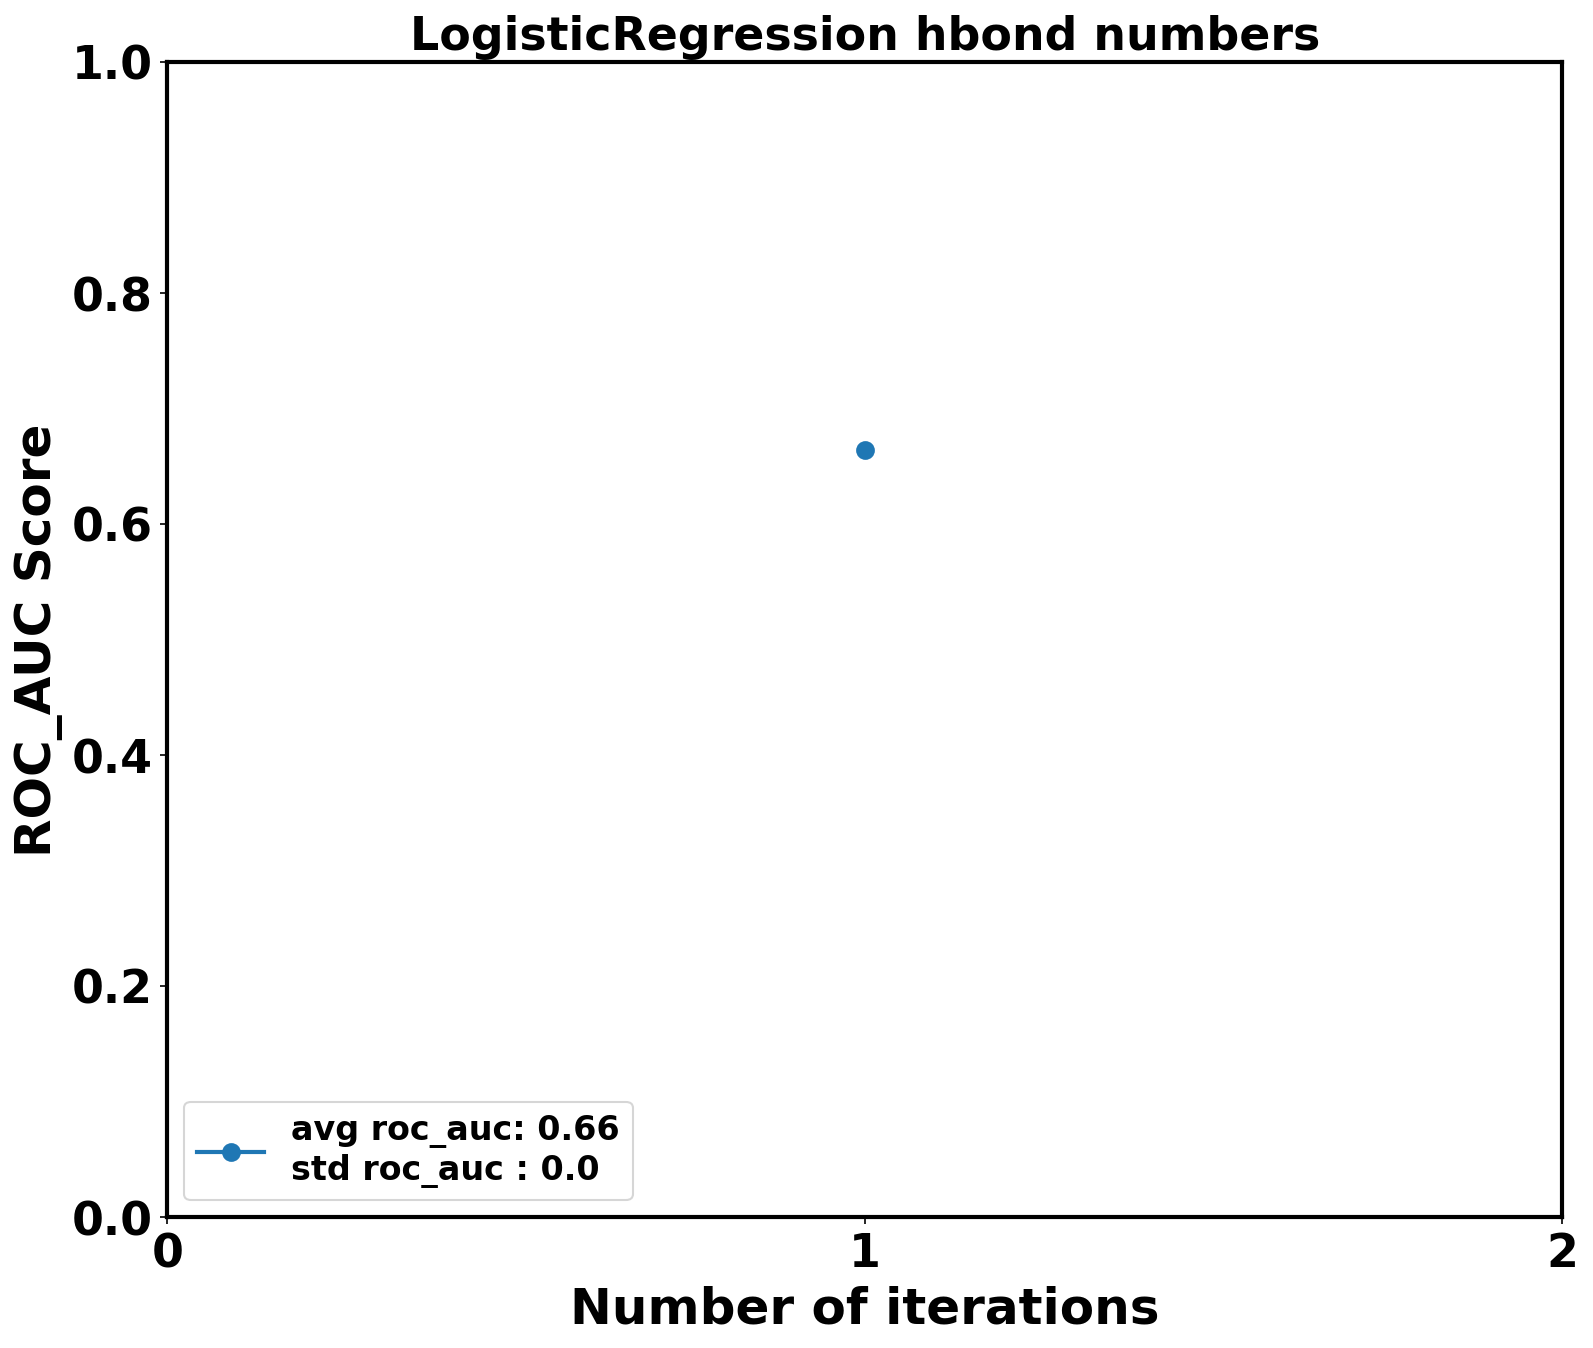

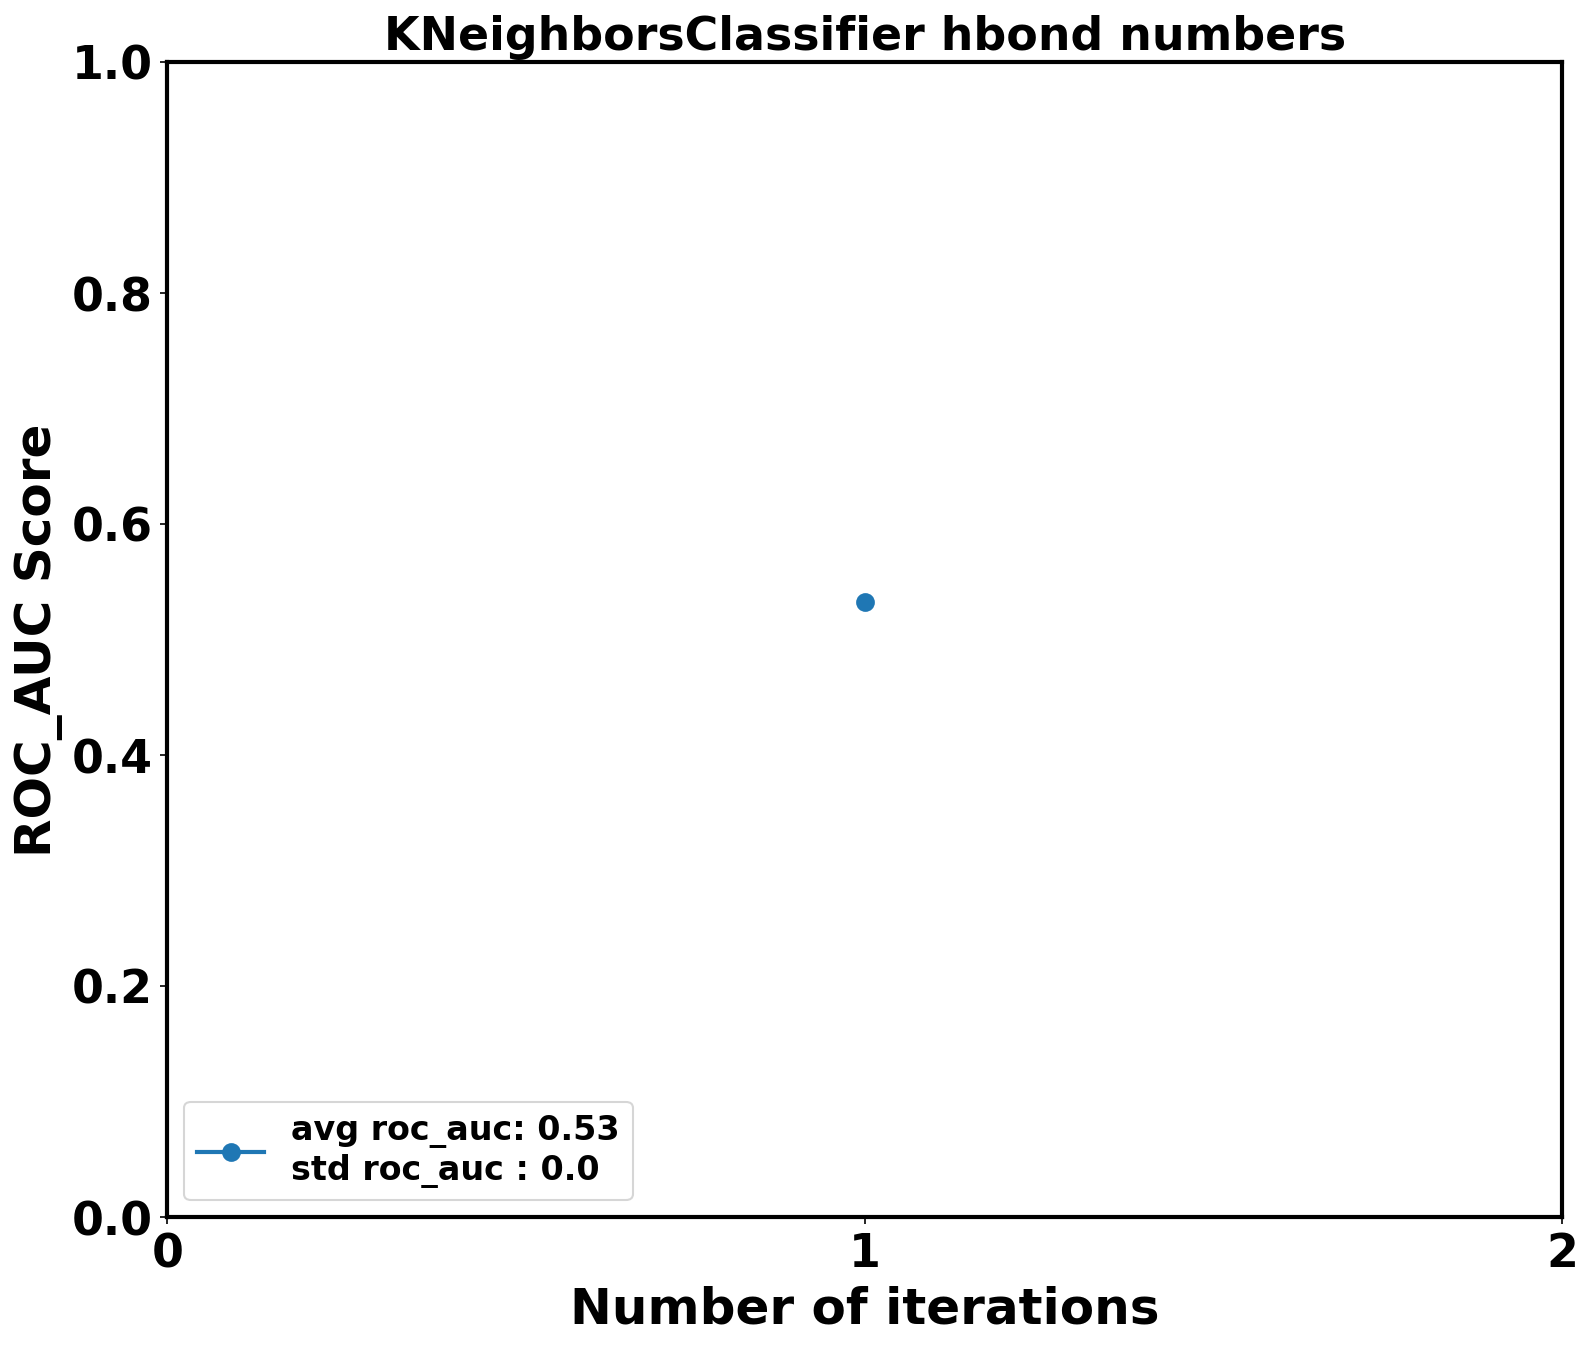

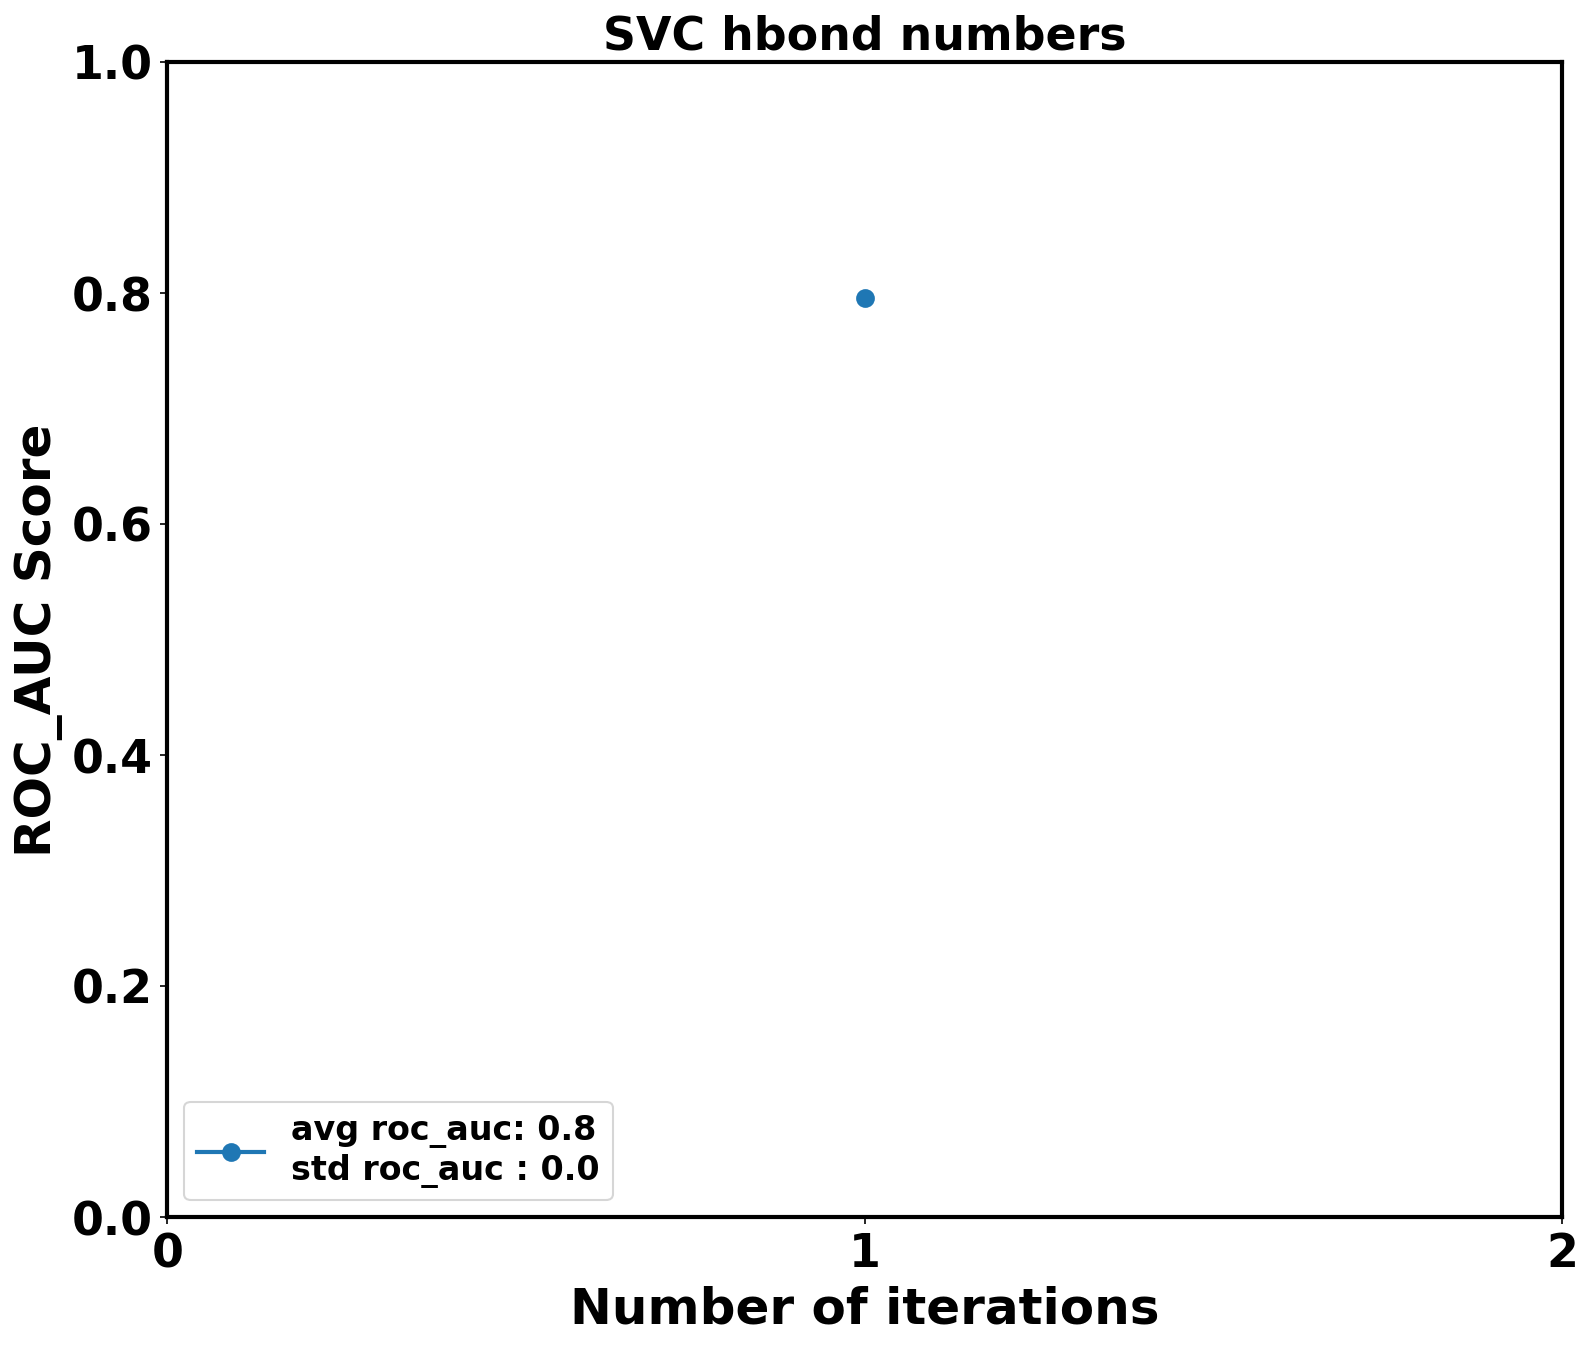

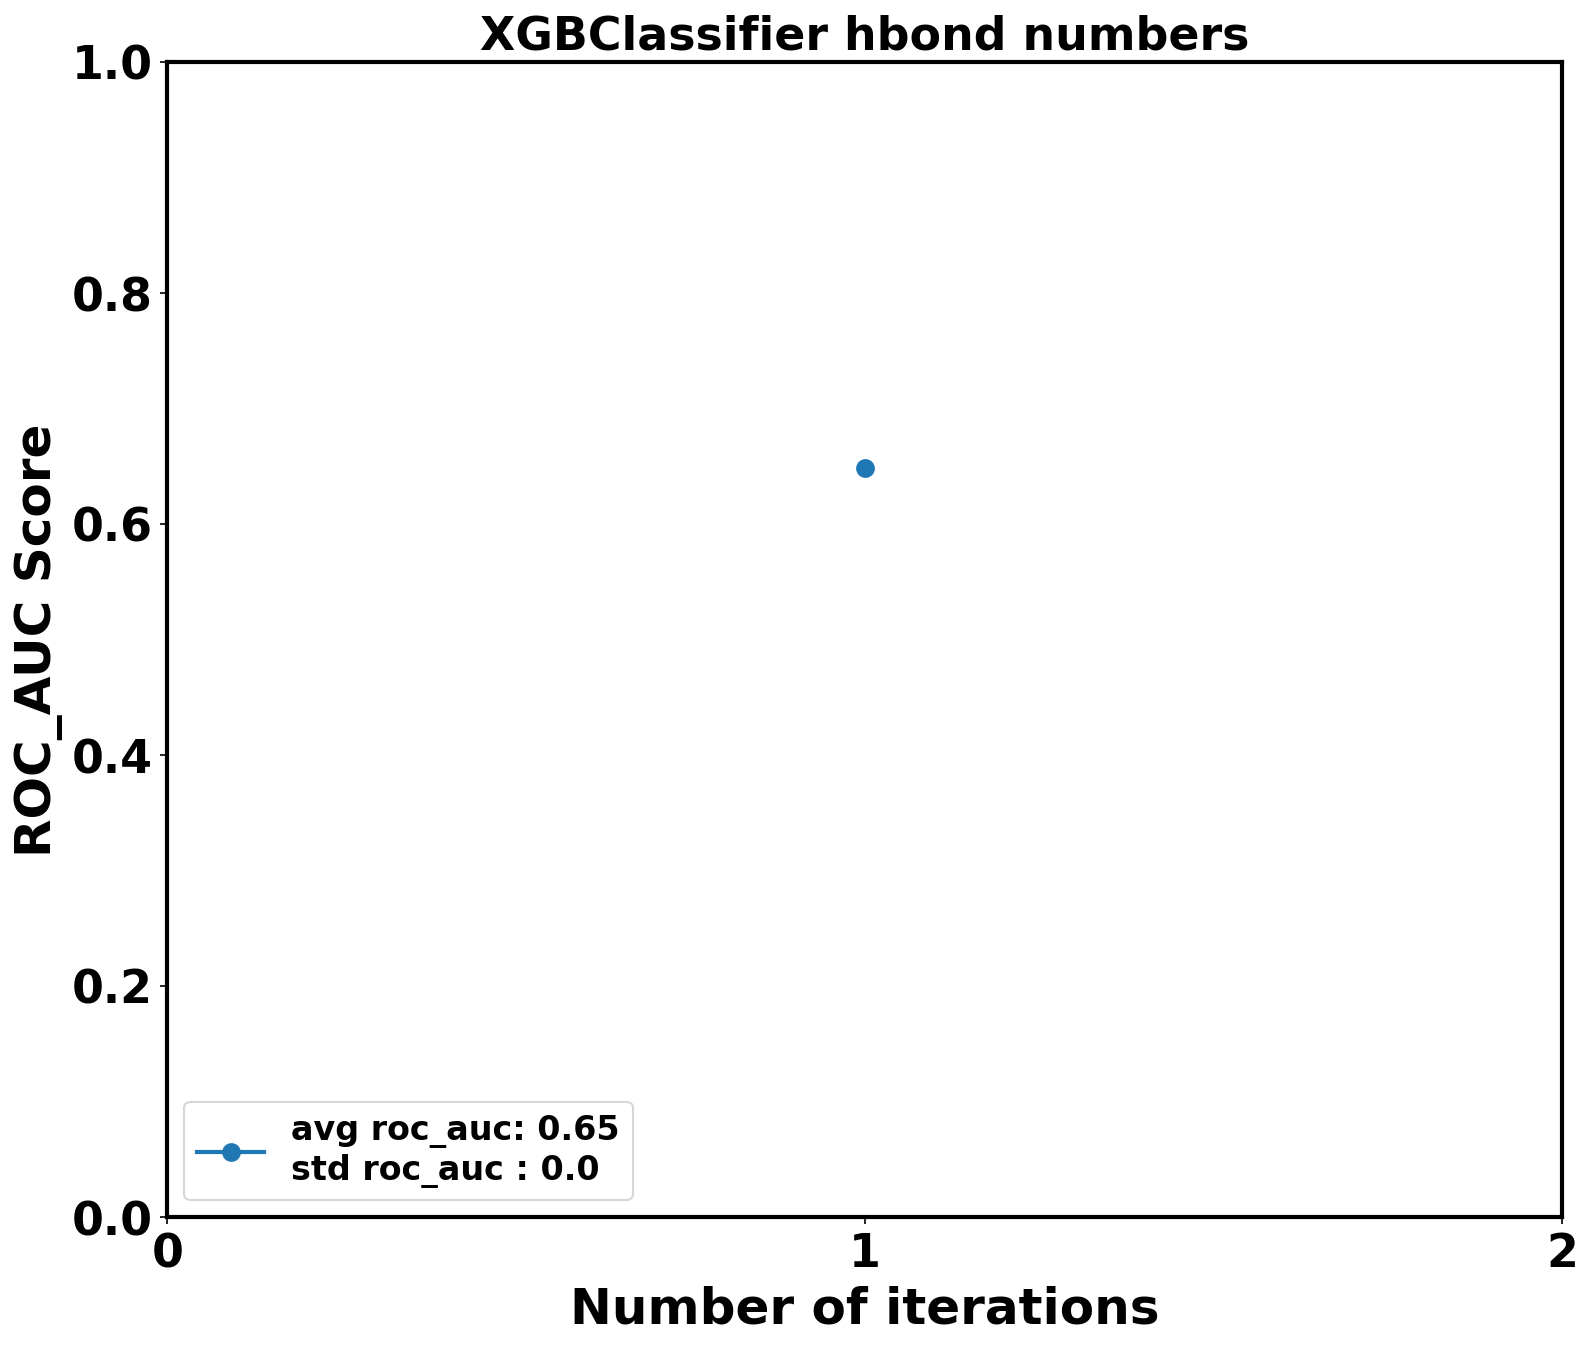

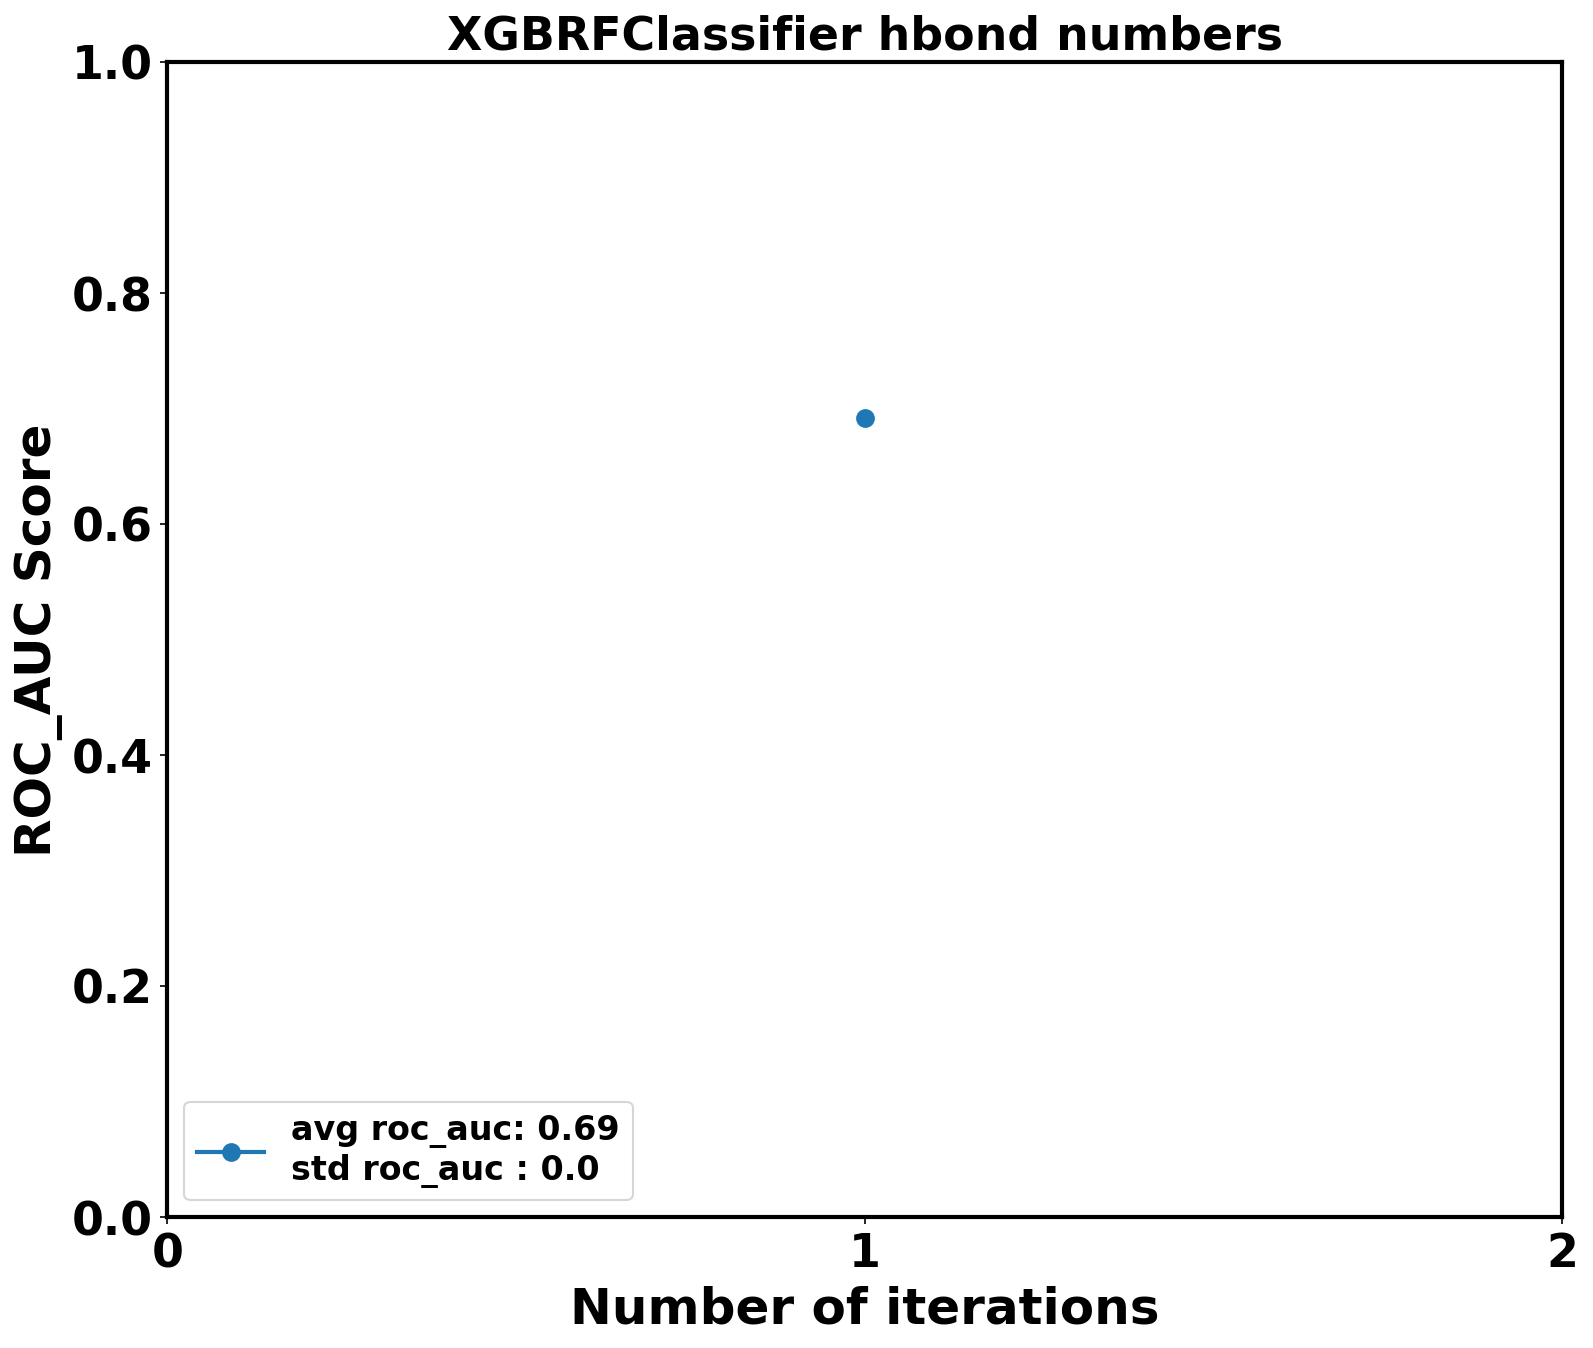

In [26]:
# Validation with lignin

plt.rcParams.update({
    "font.weight": "bold",
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    'font.size': 18,
    'axes.labelweight': 'bold',
    'figure.dpi': 150.0,
})

xdate = datetime.datetime.now().strftime("%m-%d-%Y")
rand_seed = 100
n_repeat = 1
folder_type='hnum'
folder_types = ['hlife', 'hnum', 'merged']
tag = "LR"

models = {
    "RF": "RandomForestClassifier",
    "EF": "ExtraTreesClassifier",
    "GB": "GradientBoostingClassifier",
    "AB": "AdaBoostClassifier",
    "DT": "DecisionTreeClassifier",
    "LR": "LogisticRegression",
    "KNN": "KNeighborsClassifier",
    "SVC": "SVC",
    "XGB": "XGBClassifier",
    "XGBRF": "XGBRFClassifier"

}


for model_tag in models.keys():
    model = models[model_tag]
    model_type = load(f'./saved-models/{folder_type}/{model}_{folder_type}.joblib')
    model_name = model_type.__str__().split('(')[0]
    # print(f"{tag} training for {n_repeat} runs")

    dirmaker(f'./model-logs/validation/{folder_type}/{xdate}')
    file_name = open(f"./model-logs/validation/{folder_type}/{xdate}/{model_name}_{lig}_{folder_type}_{n_repeat}_{xdate}_{rand_seed}.txt", "w+")     

    X, Y = data_validate(des_df_hnum, nondes_df_hnum, batch_size=17)   
    validate_trained_models(model_type, X, Y,file_name=file_name, folder_type=folder_type, num=n_repeat, rand_seed=rand_seed)

## Hbond number + lifetime
Models are trained n merged hbond number and lifetime data

#### des

In [27]:
des_df_hlife_edited = des_df_hlife.rename(columns={'A-A': 'A-A_l', 'B-B': 'B-B_l', 'A-B': 'A-B_l',
                                          'A-A/B-B': 'A-A_l/B-B_l', 'A-B/(A-A + B-B)': 'A-B_l/(A-A_l + B-B_l)'})
# des_df_hlife_edited

In [28]:
des_df_hnum_edited = des_df_hnum.rename(columns={'A-A': 'A-A_n', 'B-B': 'B-B_n', 'A-B': 'A-B_n',
                                        'A-A/B-B': 'A-A_n/B-B_n', 'A-B/(A-A + B-B)': 'A-B_n/(A-A_n + B-B_n)'})
# des_df_hnum_edited

#### nondes

In [29]:
nondes_df_hlife_edited = nondes_df_hlife.rename(
    columns={'A-A': 'A-A_l', 'B-B': 'B-B_l', 'A-B': 'A-B_l', 'A-A/B-B': 'A-A_l/B-B_l', 'A-B/(A-A + B-B)': 'A-B_l/(A-A_l + B-B_l)'})
# nondes_df_hlife_edited

In [30]:
nondes_df_hnum_edited = nondes_df_hnum.rename(
    columns={'A-A': 'A-A_n', 'B-B': 'B-B_n', 'A-B': 'A-B_n', 'A-A/B-B': 'A-A_n/B-B_n', 'A-B/(A-A + B-B)': 'A-B_n/(A-A_n + B-B_n)'})
# nondes_df_hnum_edited

#### merged

In [31]:
des_df_hnum_edited = des_df_hnum_edited.drop(columns=['output'])
des_df_merged_list = [des_df_hnum_edited, des_df_hlife_edited]
des_df_merged = pd.concat(des_df_merged_list, axis=1)
des_df_merged

,A-A_n,B-B_n,A-B_n,A-A_n/B-B_n,A-B_n/(A-A_n + B-B_n),A-A_l,B-B_l,A-B_l,A-A_l/B-B_l,A-B_l/(A-A_l + B-B_l),output
0,19.658342,11.382617,40.727273,1.727049,1.312049,1.420395,0.730024,1.664087,1.945682,0.773843,1
1,8.469530,33.392607,54.238761,0.253635,1.295652,1.381339,0.566631,1.556223,2.437813,0.798895,1
2,57.322677,5.783217,56.630370,9.911902,0.897386,1.827739,1.008626,2.014303,1.812108,0.710170,1
3,7.231768,11.285714,22.994006,0.640790,1.241746,0.897275,1.122728,1.142600,0.799192,0.565643,1
4,14.178821,3.991009,41.086913,3.552691,2.261271,2.219897,1.678356,3.198114,1.322662,0.820397,1
5,12.079920,6.122877,17.978022,1.972916,0.987652,1.058700,1.043621,0.791005,1.014449,0.376253,1
6,29.257742,3.379620,24.753247,8.657109,0.758433,0.928187,0.391961,0.944148,2.368062,0.715184,1
7,10.435564,10.493506,23.664336,0.994478,1.130692,0.493193,0.281440,0.398792,1.752393,0.514815,1
8,5.922078,29.208791,29.870130,0.202750,0.850253,0.232701,0.206614,0.256956,1.126258,0.584900,1
9,28.118881,7.314685,31.552448,3.844168,0.890468,0.547557,0.367481,0.474645,1.490031,0.518716,1


In [32]:
nondes_df_hnum_edited = nondes_df_hnum_edited.drop(columns=['output'])
nondes_df_merged_list = [nondes_df_hnum_edited, nondes_df_hlife_edited]
nondes_df_merged = pd.concat(nondes_df_merged_list, axis=1)
nondes_df_merged

,A-A_n,B-B_n,A-B_n,A-A_n/B-B_n,A-B_n/(A-A_n + B-B_n),A-A_l,B-B_l,A-B_l,A-A_l/B-B_l,A-B_l/(A-A_l + B-B_l),output
0,29.220779,35.496503,53.883117,0.823202,0.832592,2.548177,2.454365,1.991729,1.038223,0.398143,0
1,23.880120,36.495504,52.185814,0.654330,0.864352,1.591568,0.932191,1.228077,1.707342,0.486606,0
2,19.677323,33.202797,53.625375,0.592641,1.014093,3.592210,3.197229,2.905294,1.123539,0.427914,0
3,28.627373,14.524476,24.582418,1.970975,0.569672,3.059960,2.043980,2.156269,1.497060,0.422471,0
4,31.319680,13.295704,20.875125,2.355624,0.467891,2.283029,1.045423,1.294826,2.183833,0.389018,0
5,28.134865,23.941059,47.306693,1.175172,0.908418,3.076017,2.779366,3.105455,1.106733,0.530359,0
6,4.645355,37.891109,55.707293,0.122597,1.309636,2.682118,3.330352,3.830274,0.805356,0.637055,0
7,8.237762,33.521479,53.111888,0.245746,1.271860,2.734466,1.777658,3.015204,1.538241,0.668245,0
8,11.348651,12.844156,19.481518,0.883565,0.805261,1.785885,2.369956,1.975945,0.753552,0.475462,0
9,22.141858,5.708292,35.677323,3.878894,1.281046,0.575102,0.584354,1.007917,0.984166,0.869301,0


In [ ]:
data_validate(des_df_merged, nondes_df_merged) 

## Validation

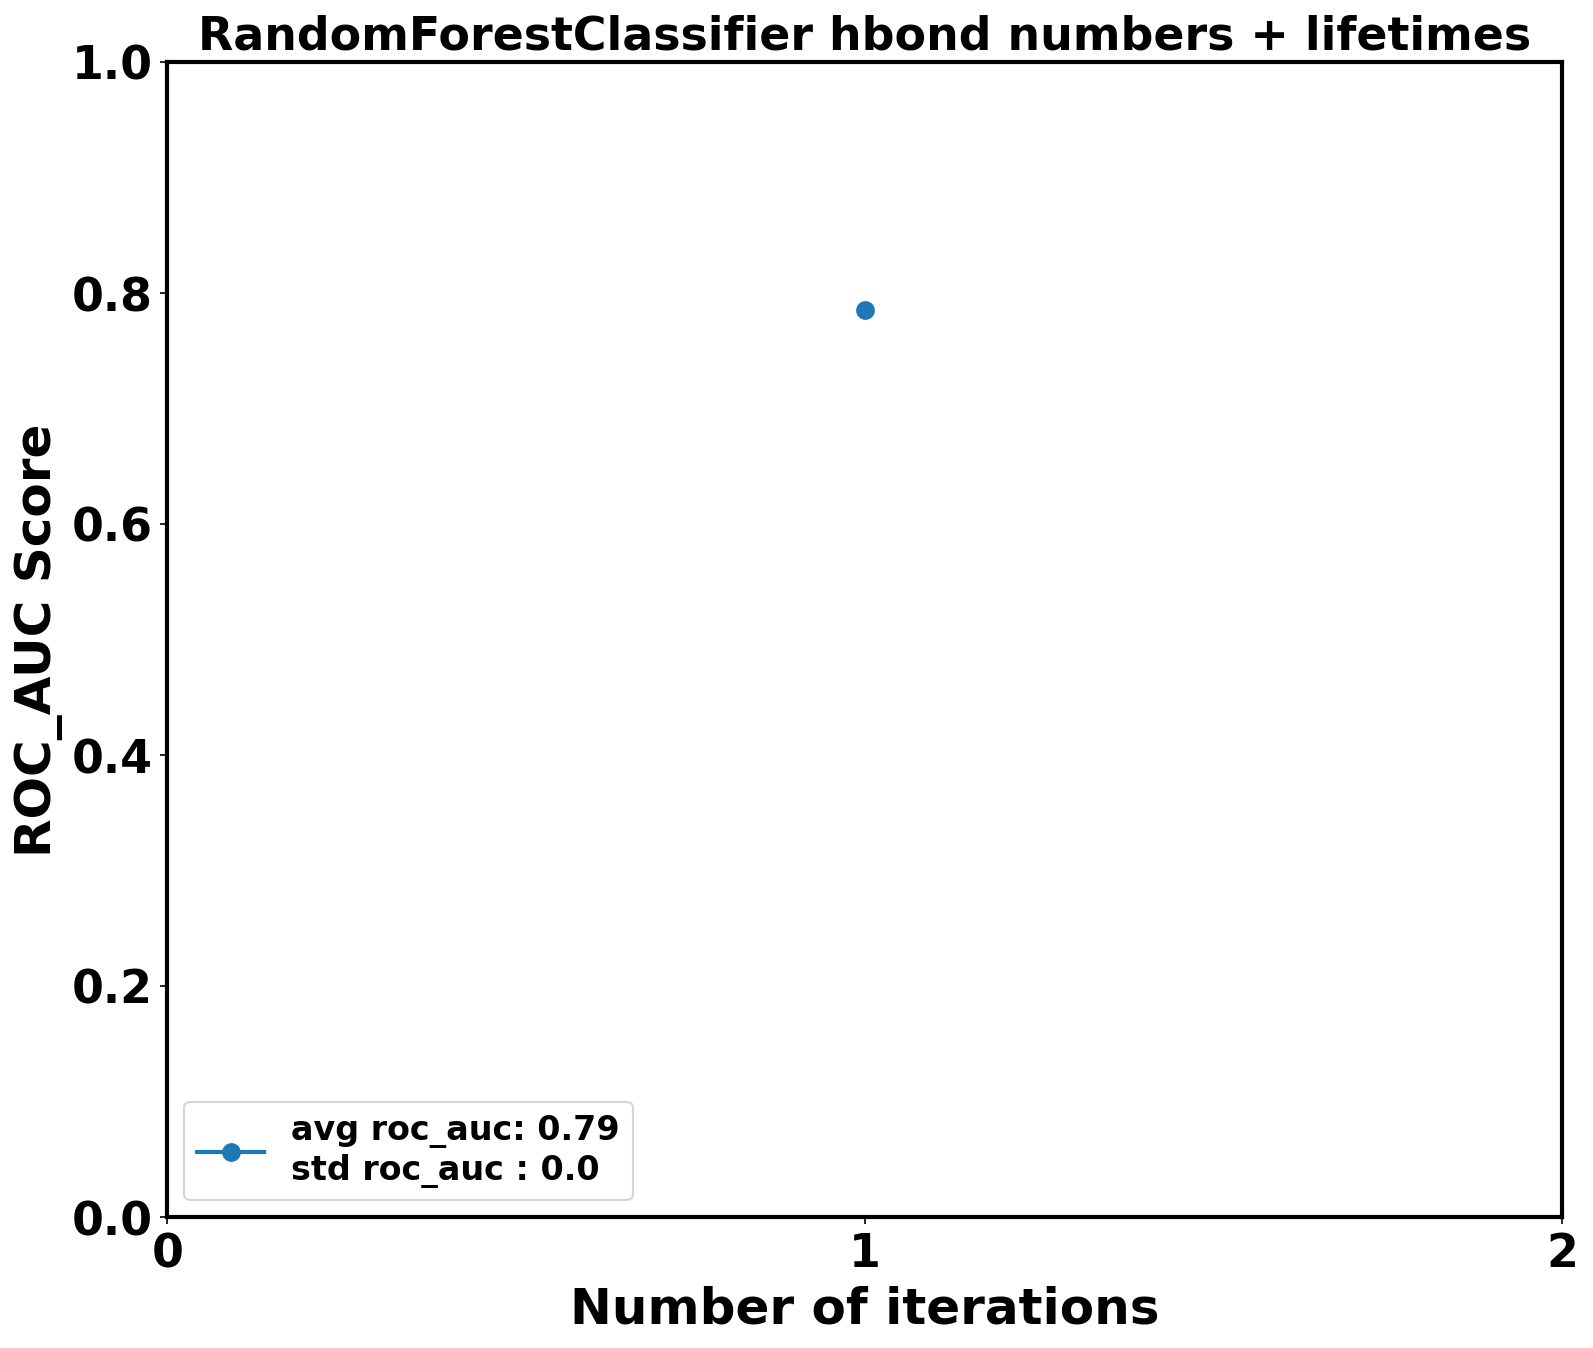

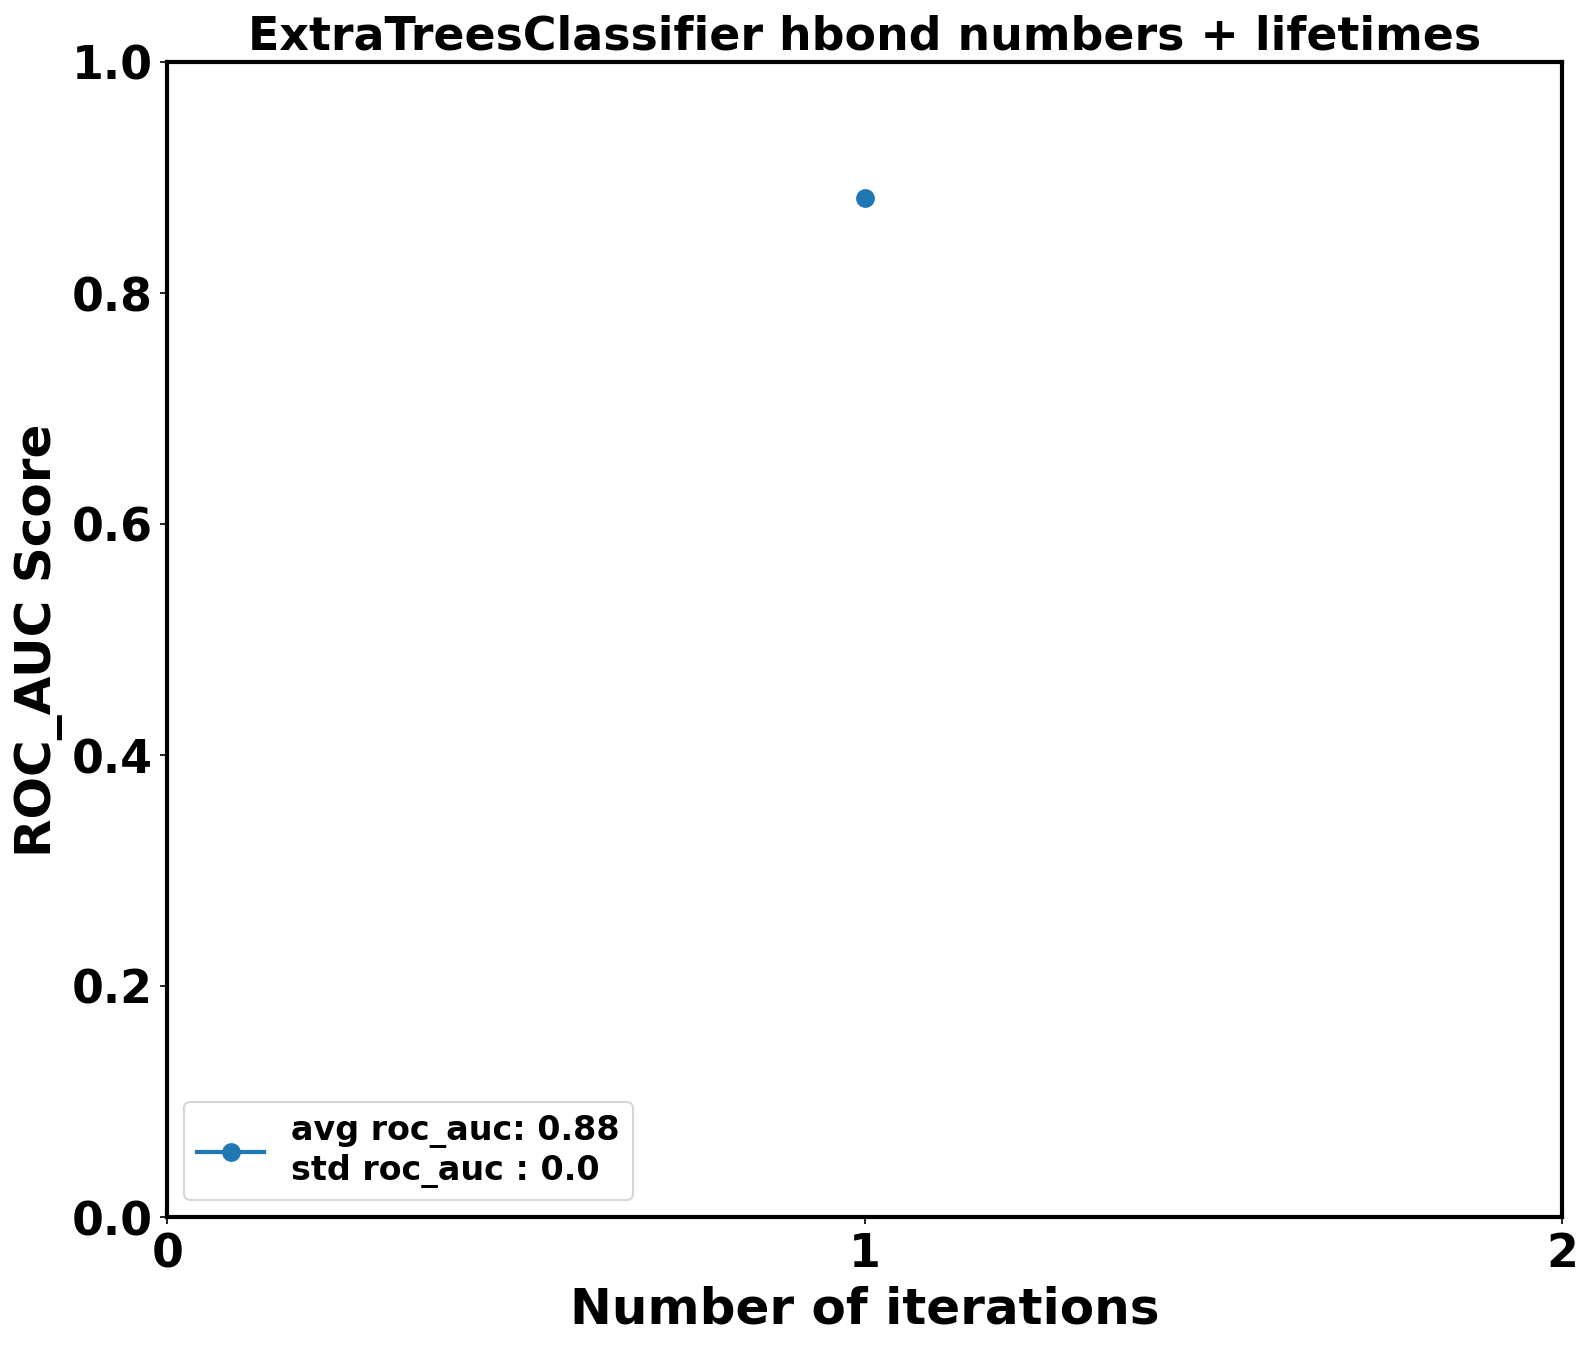

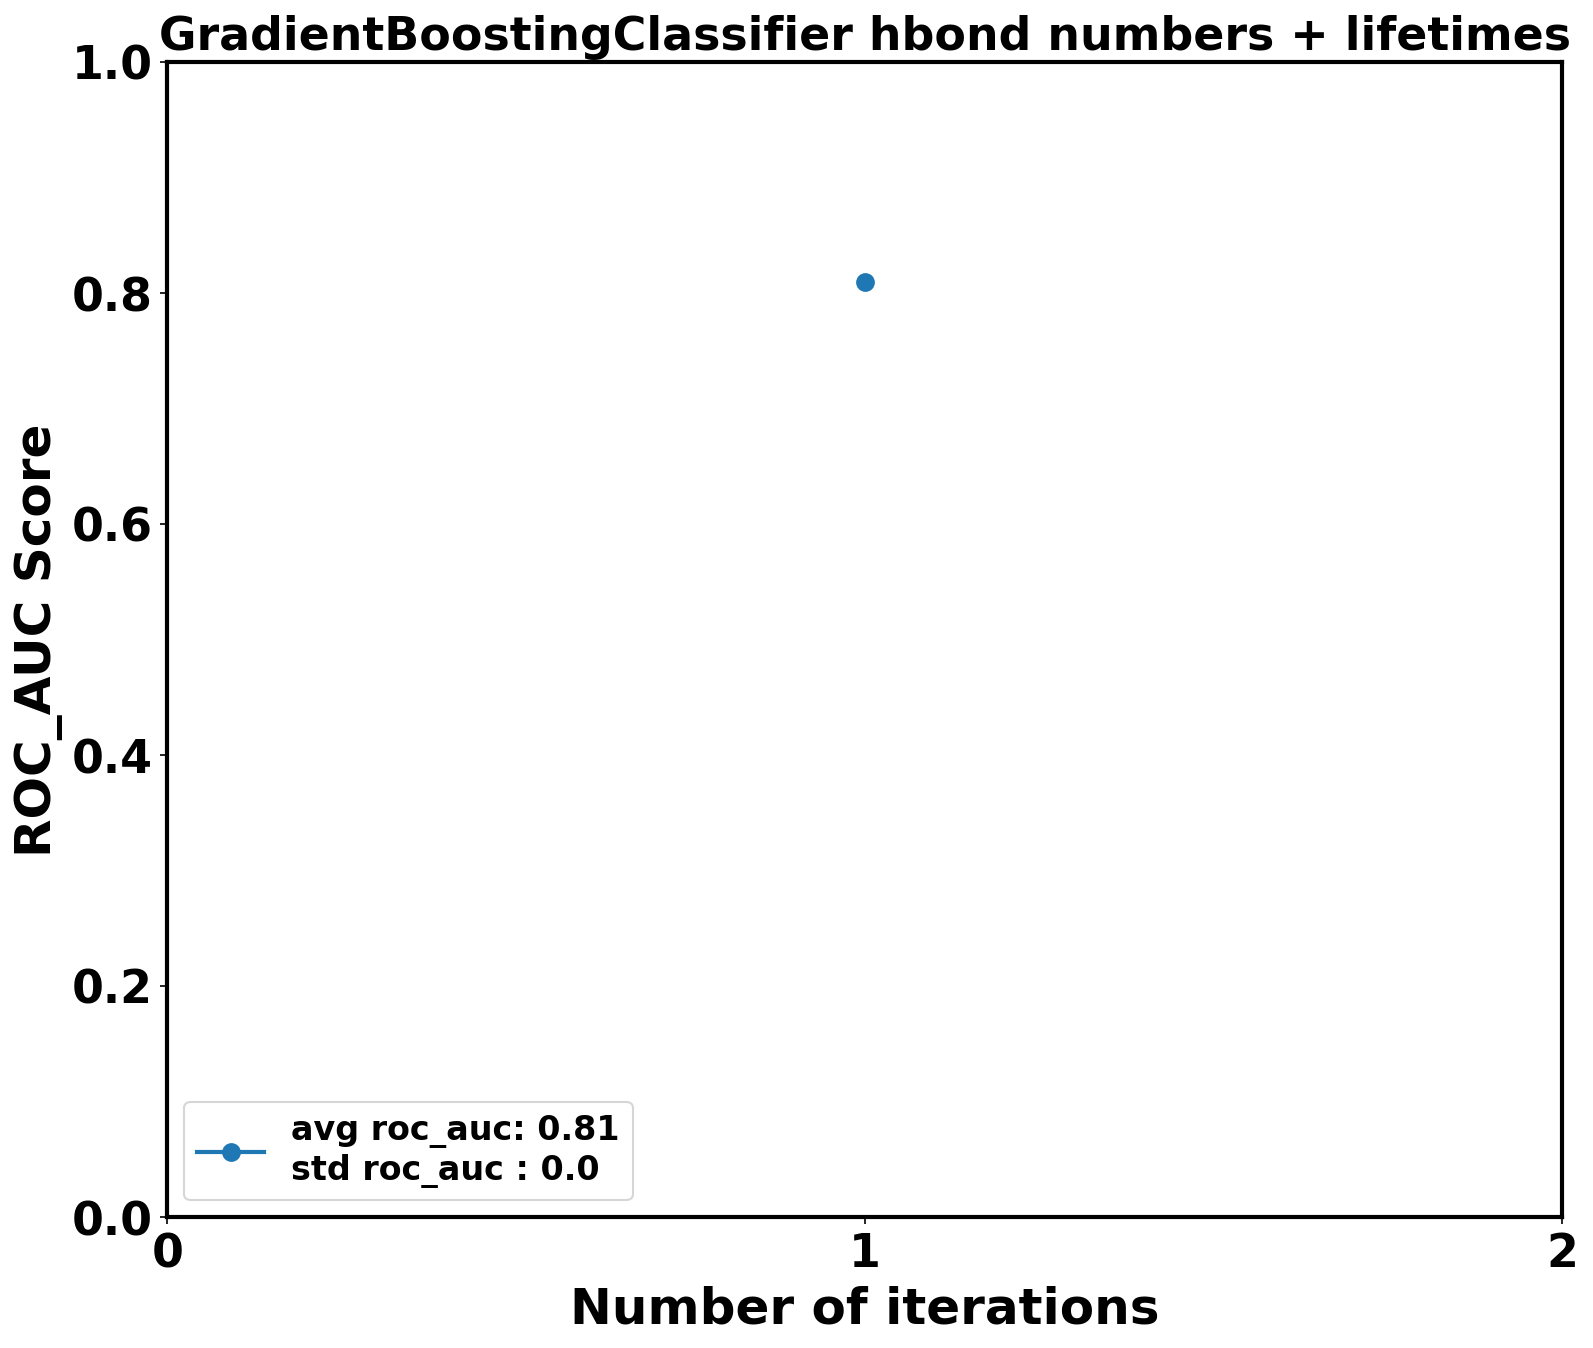

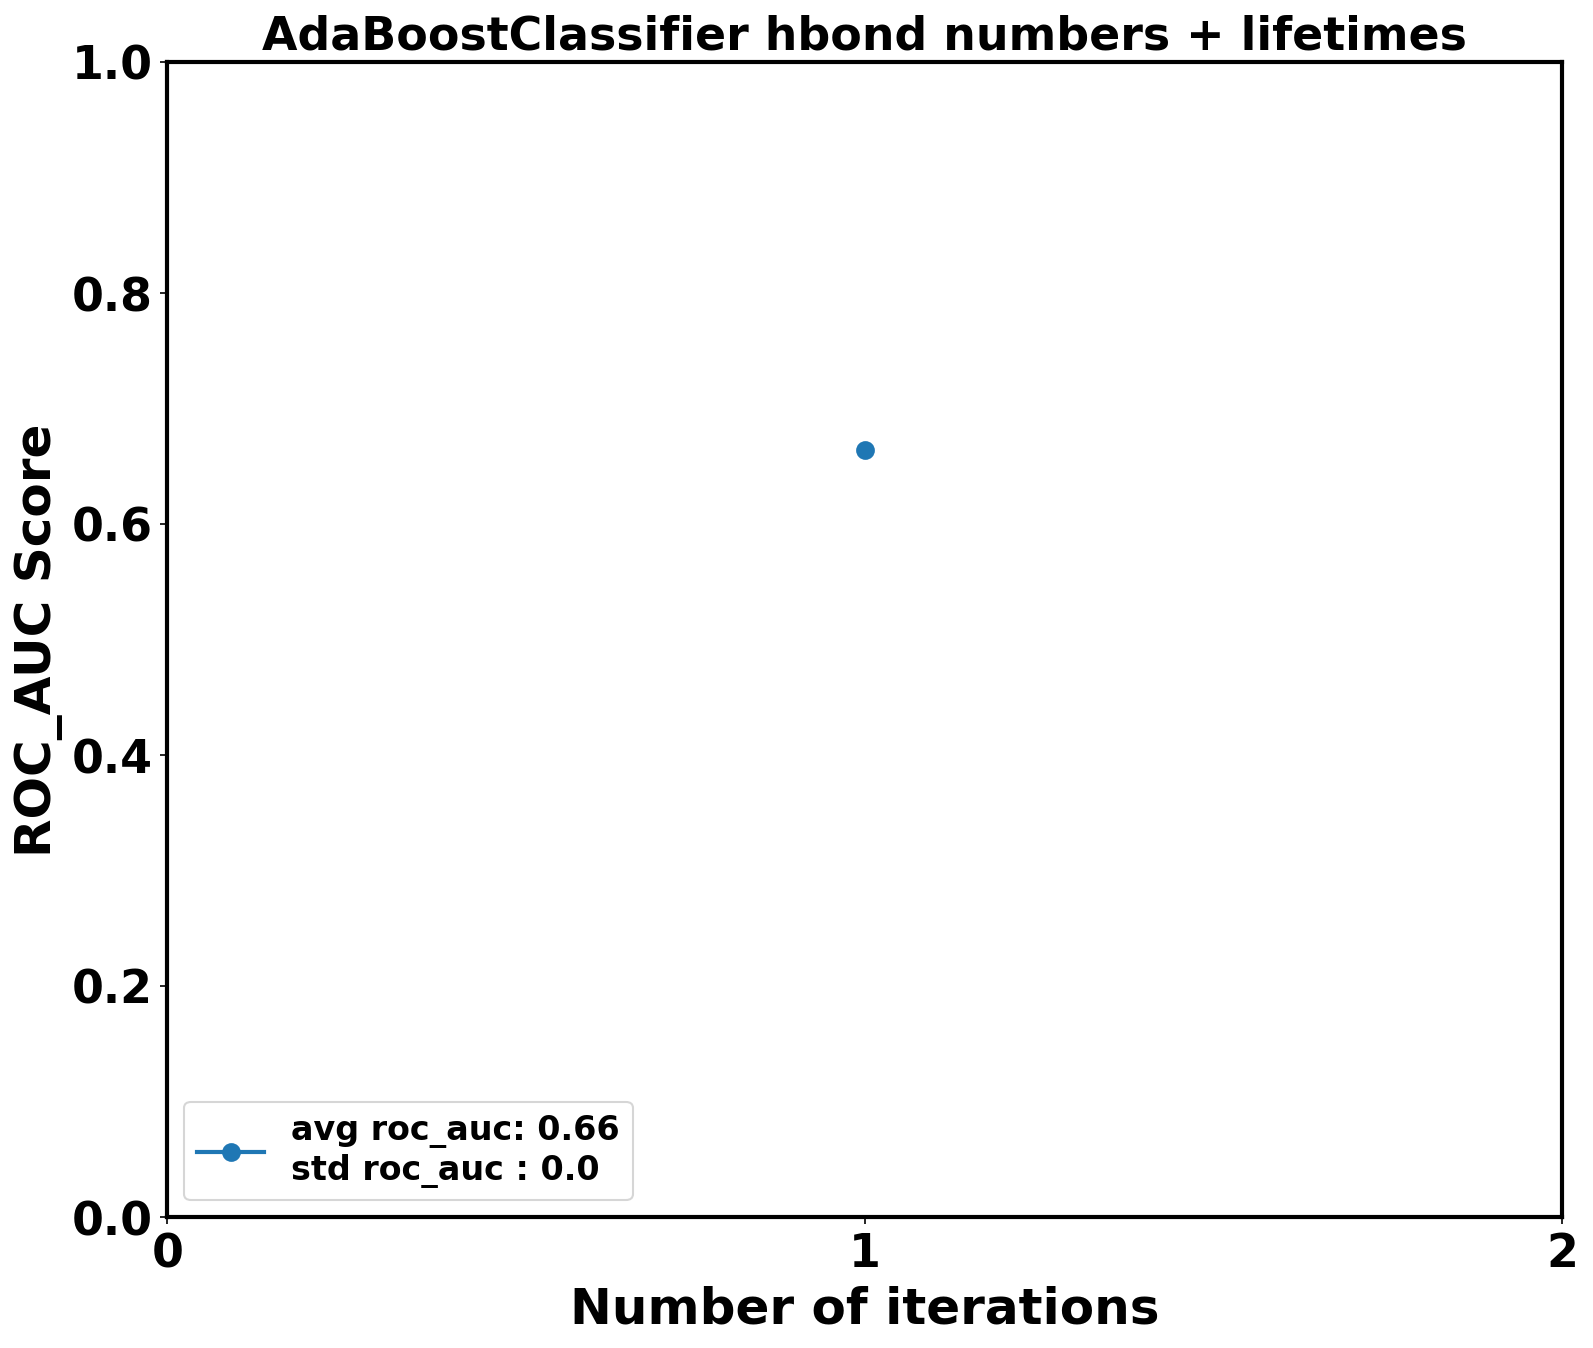

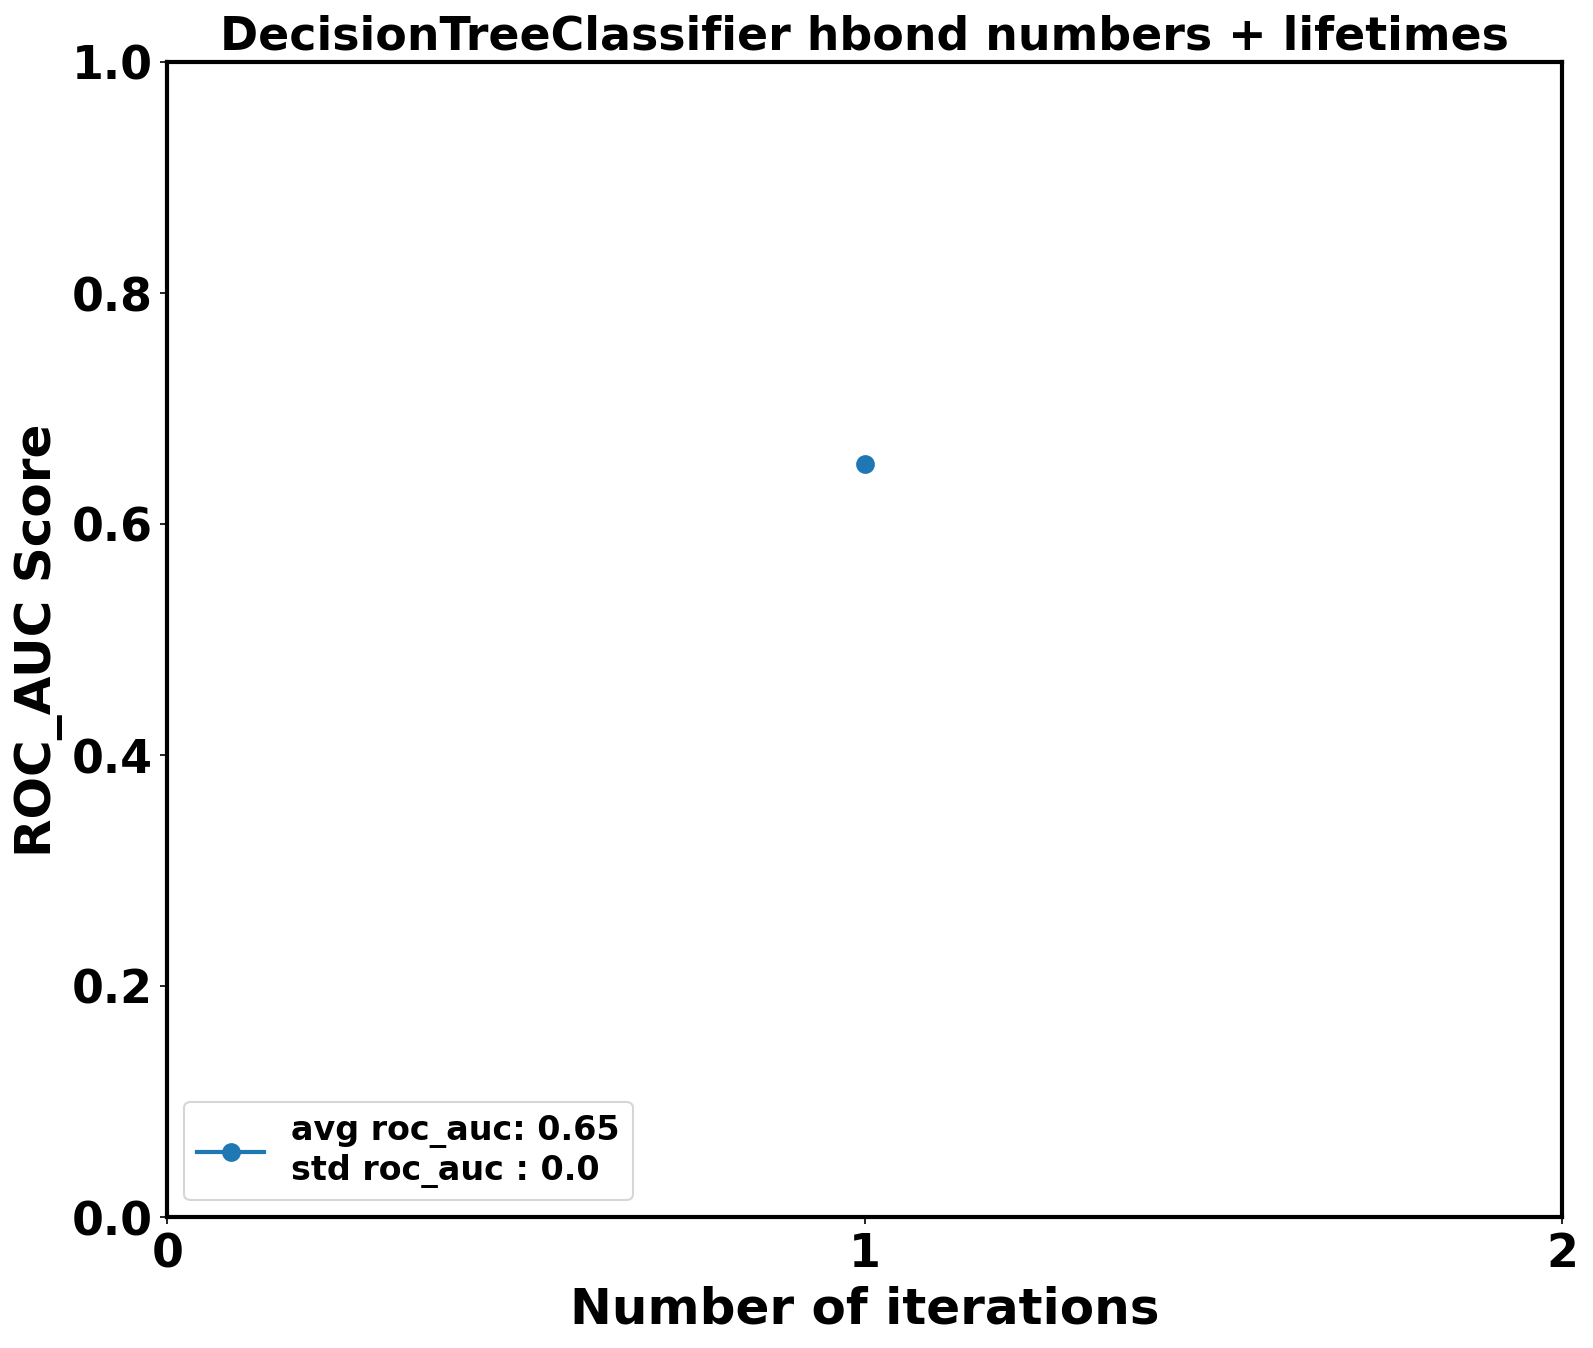

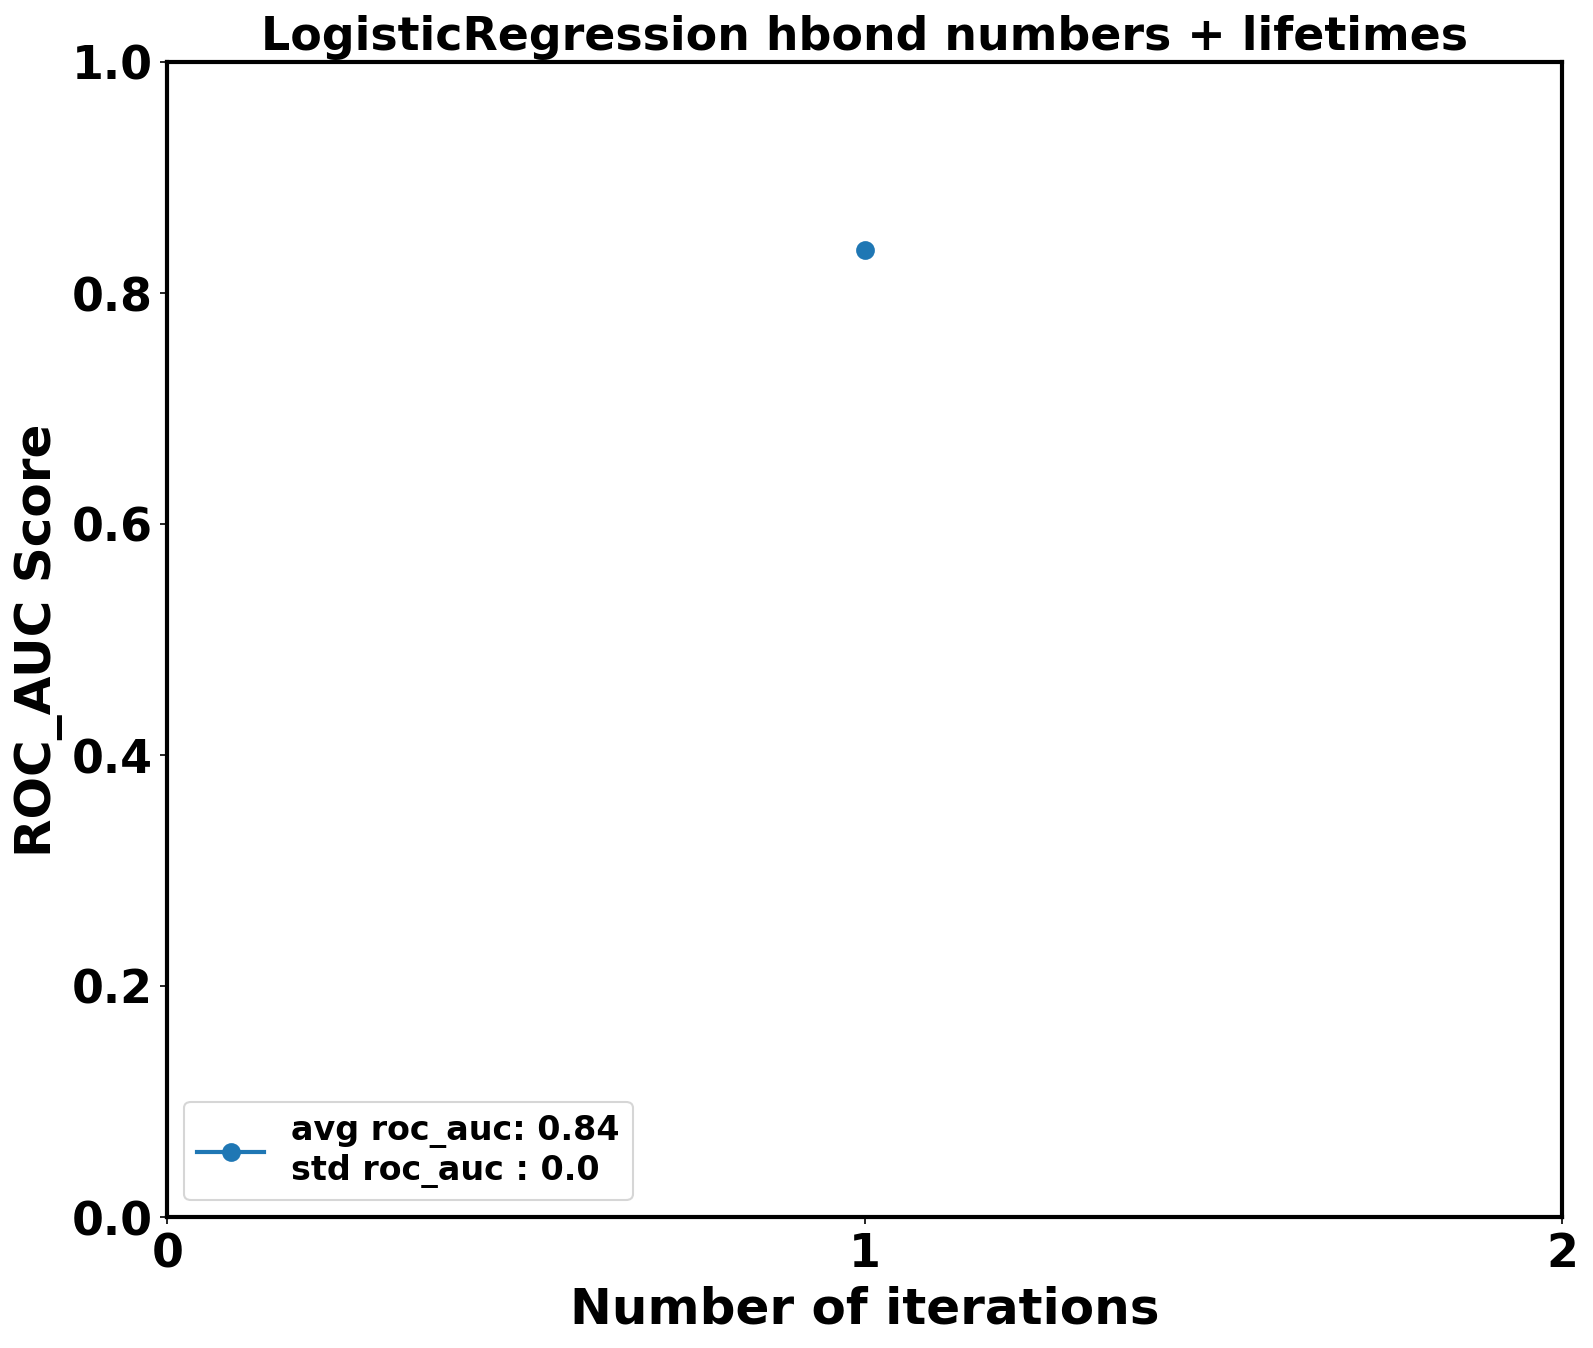

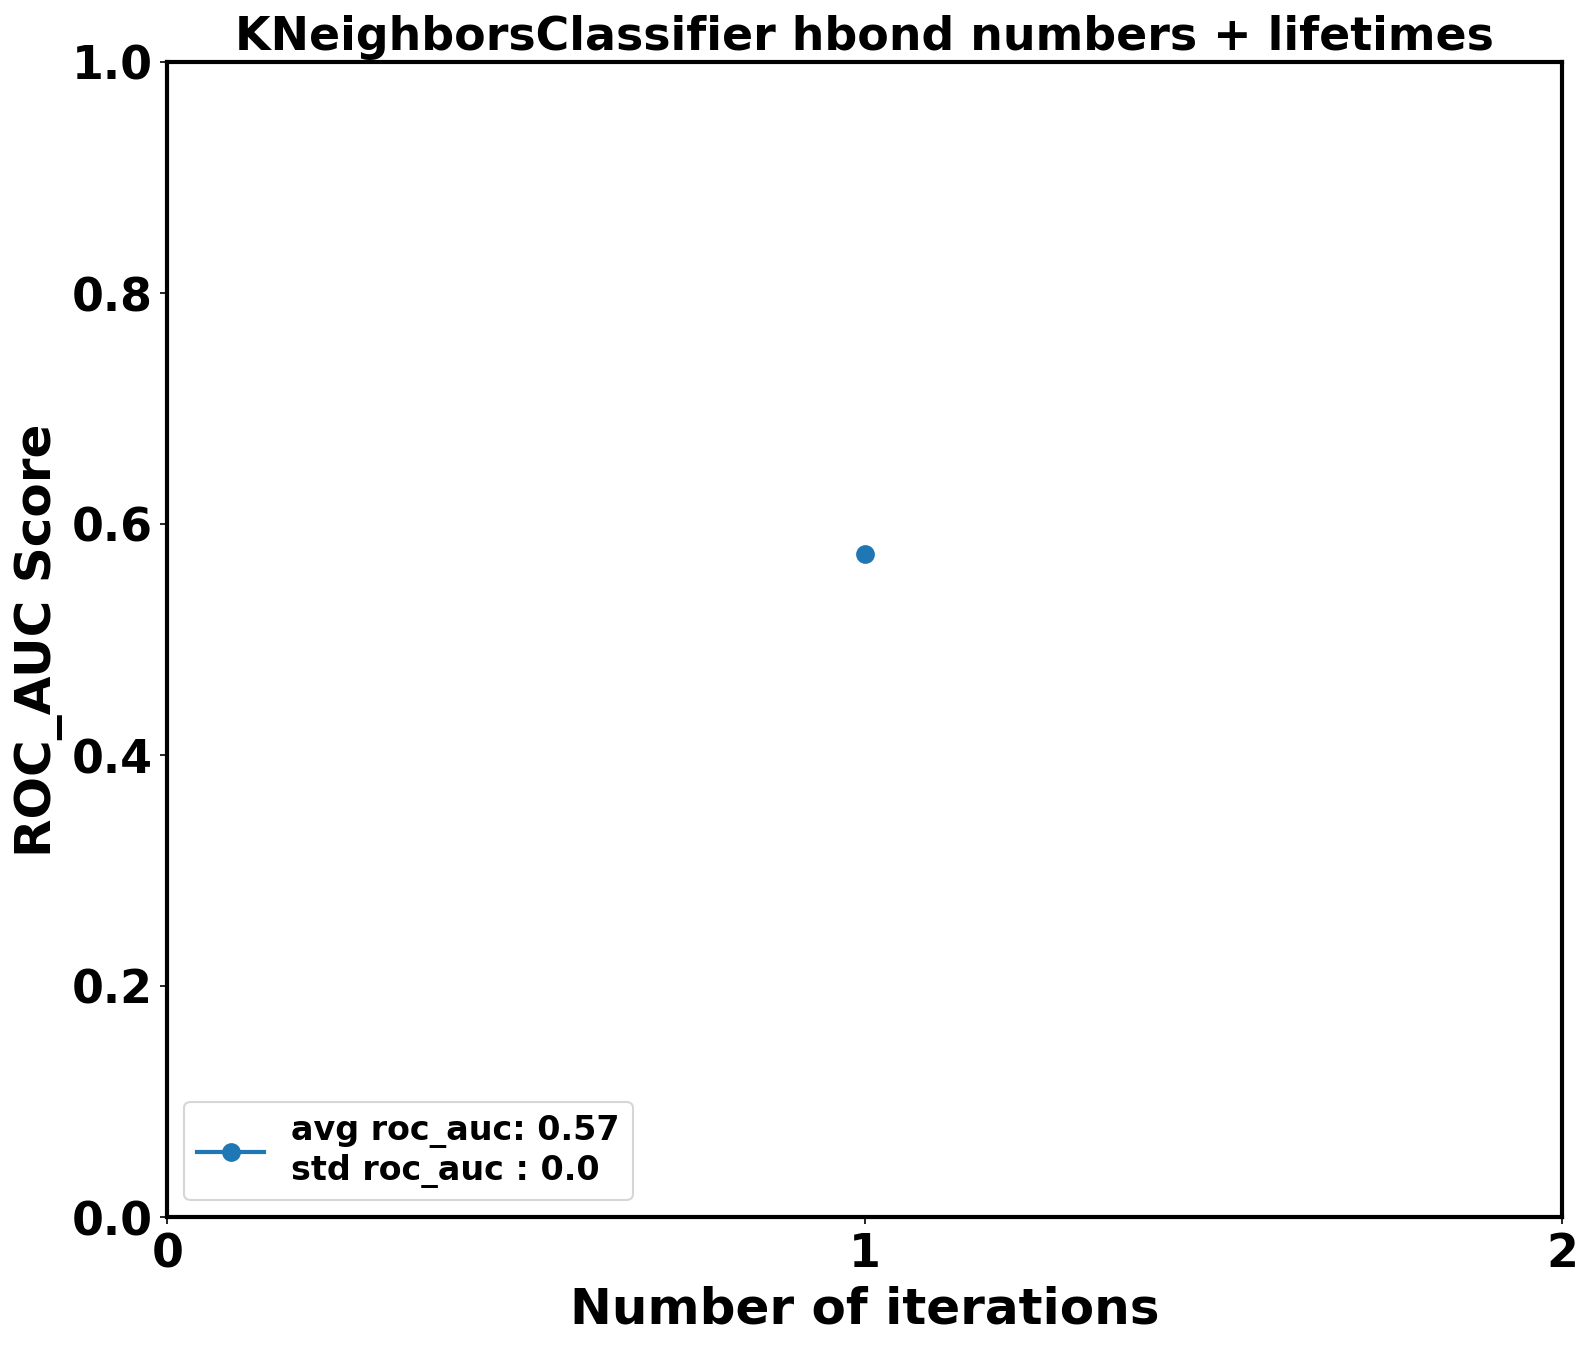

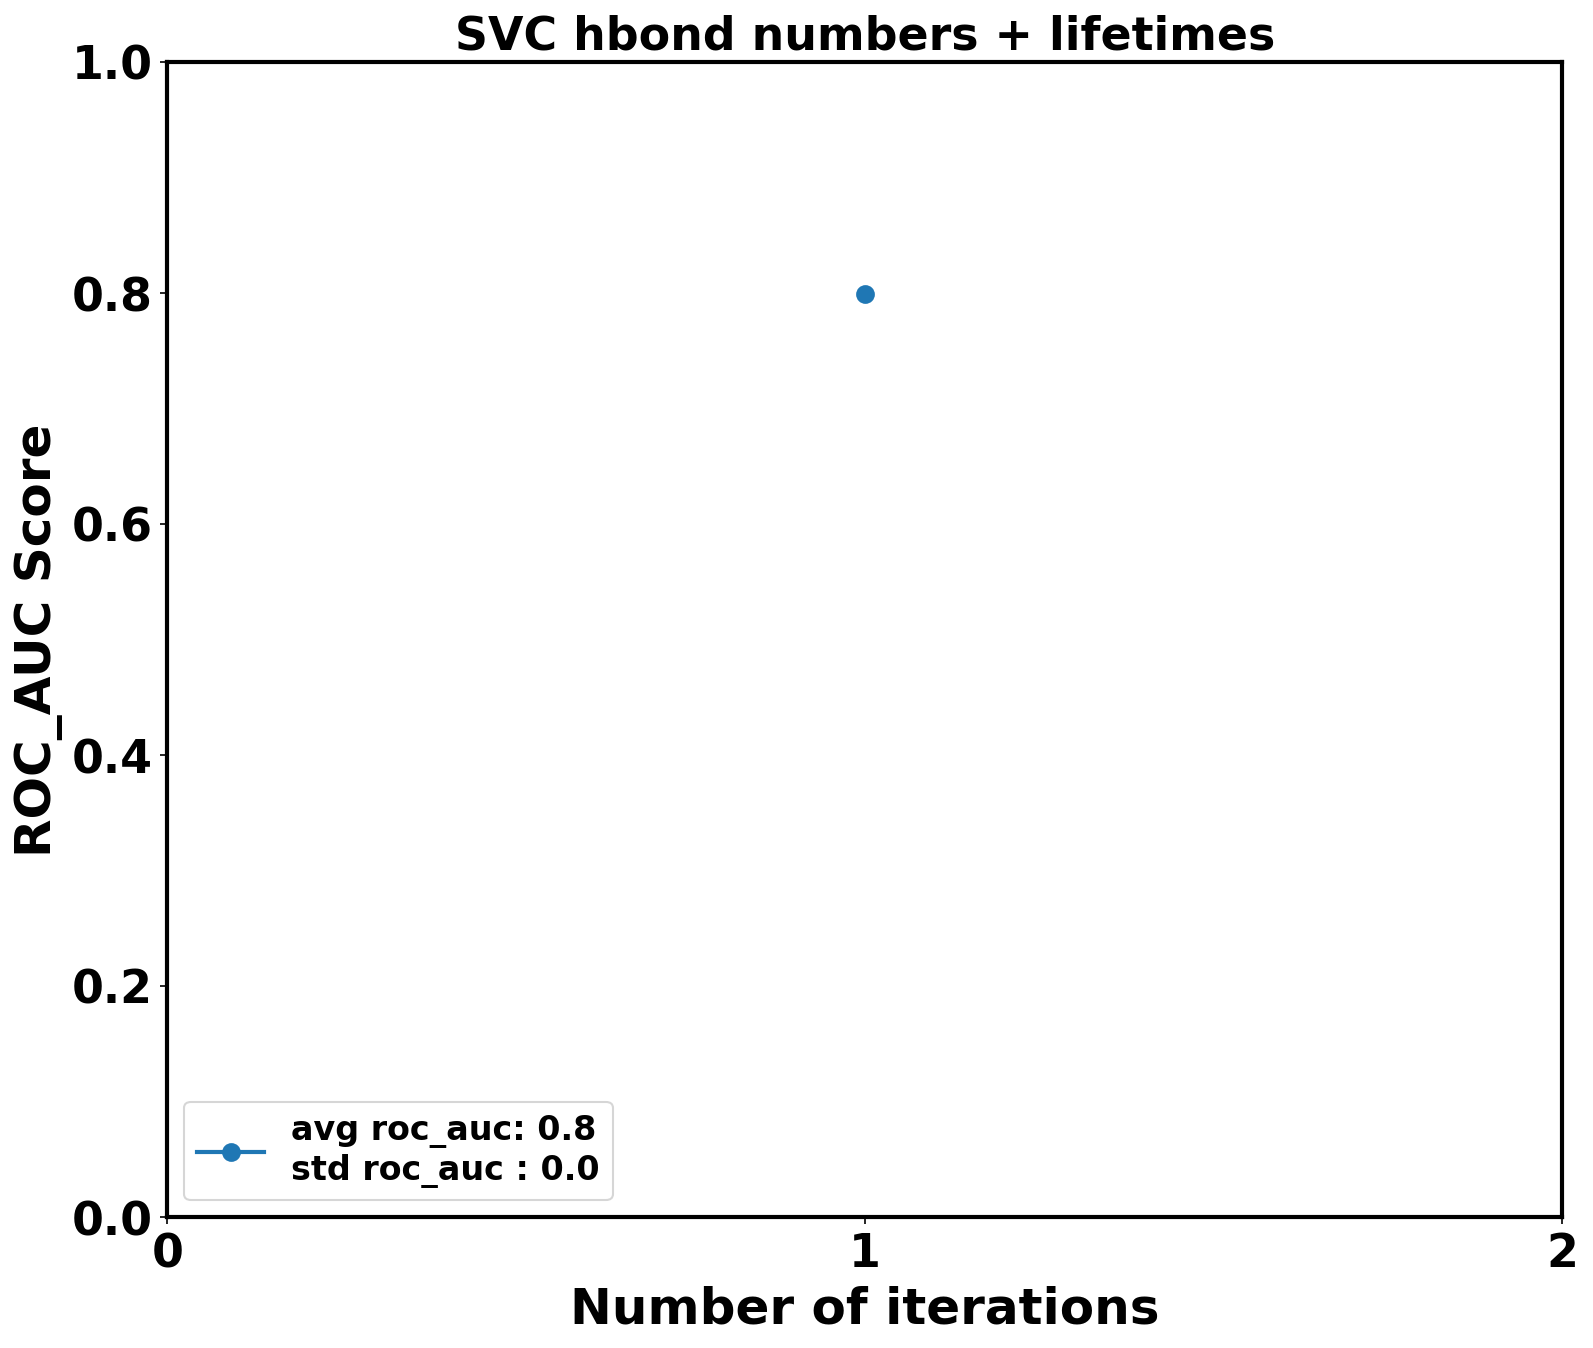

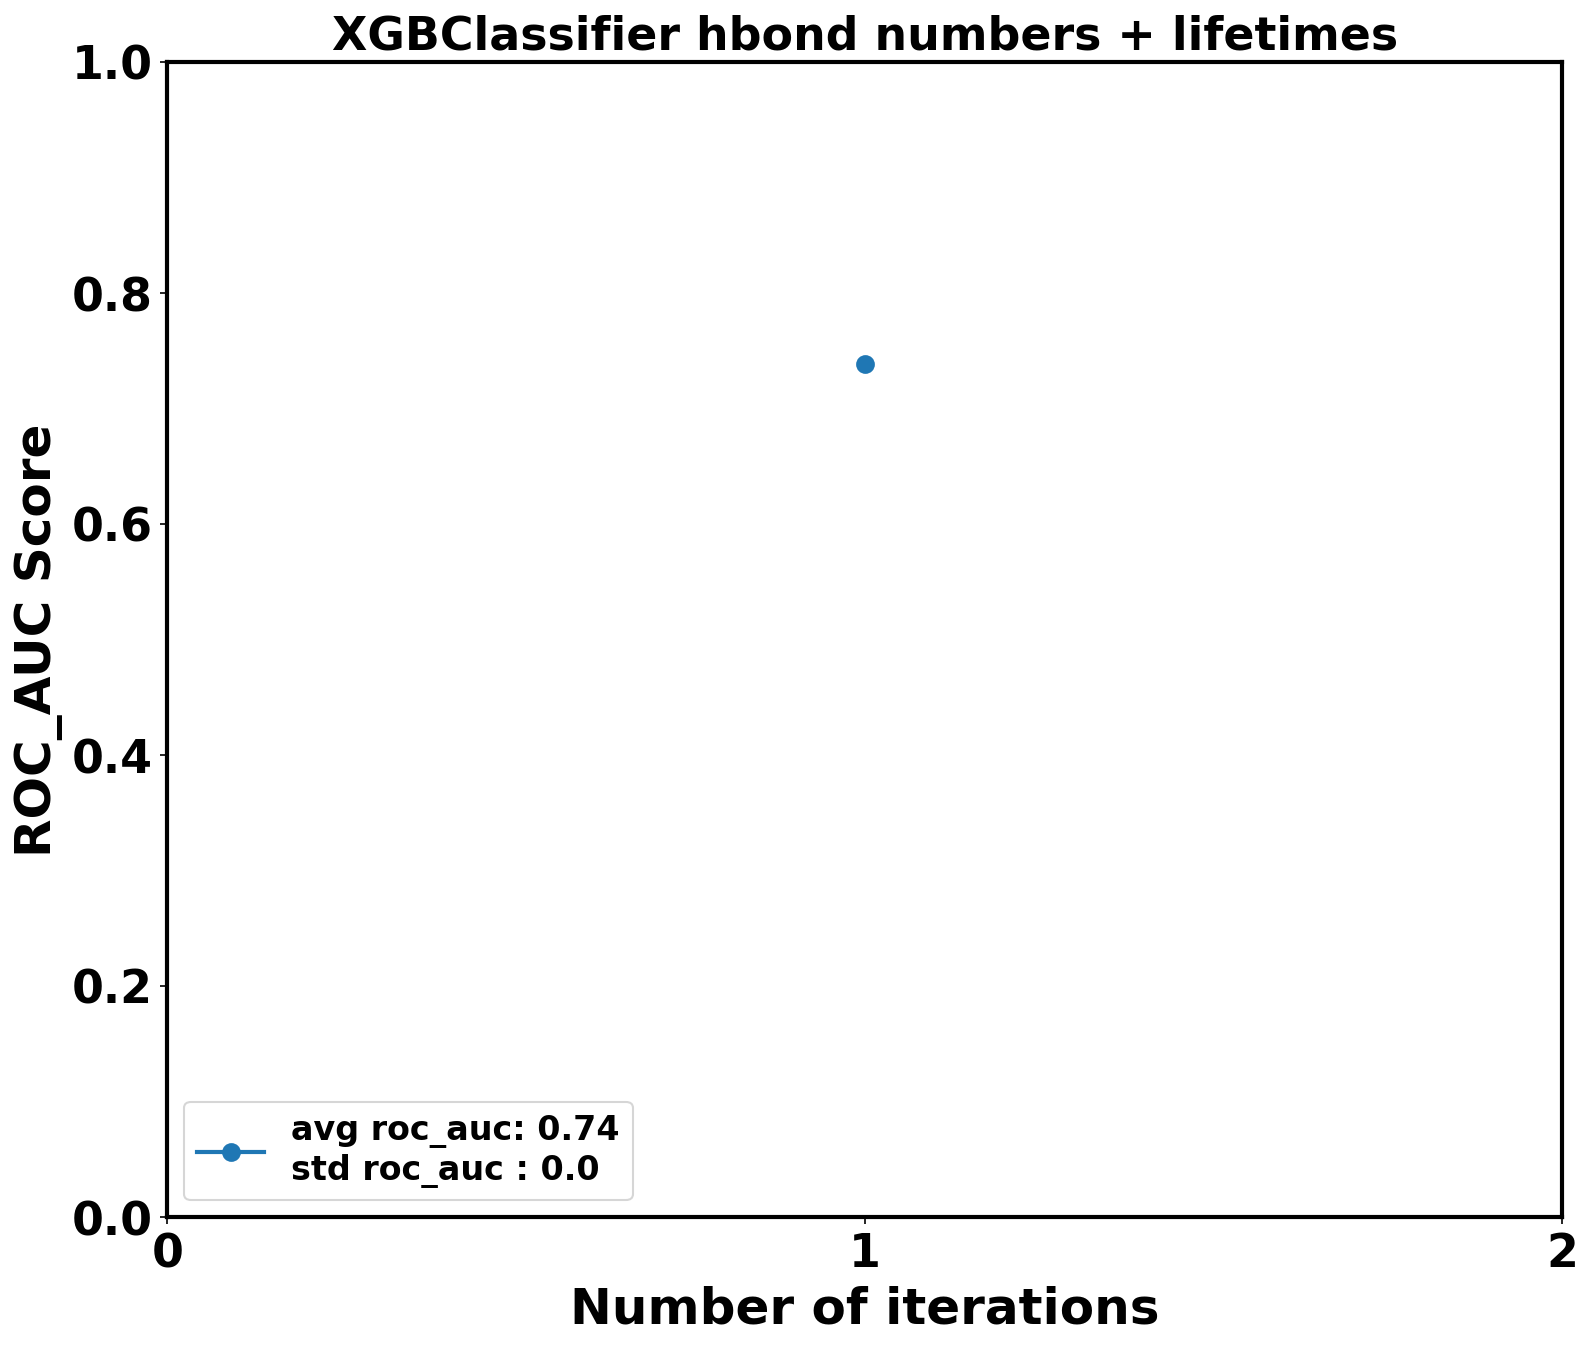

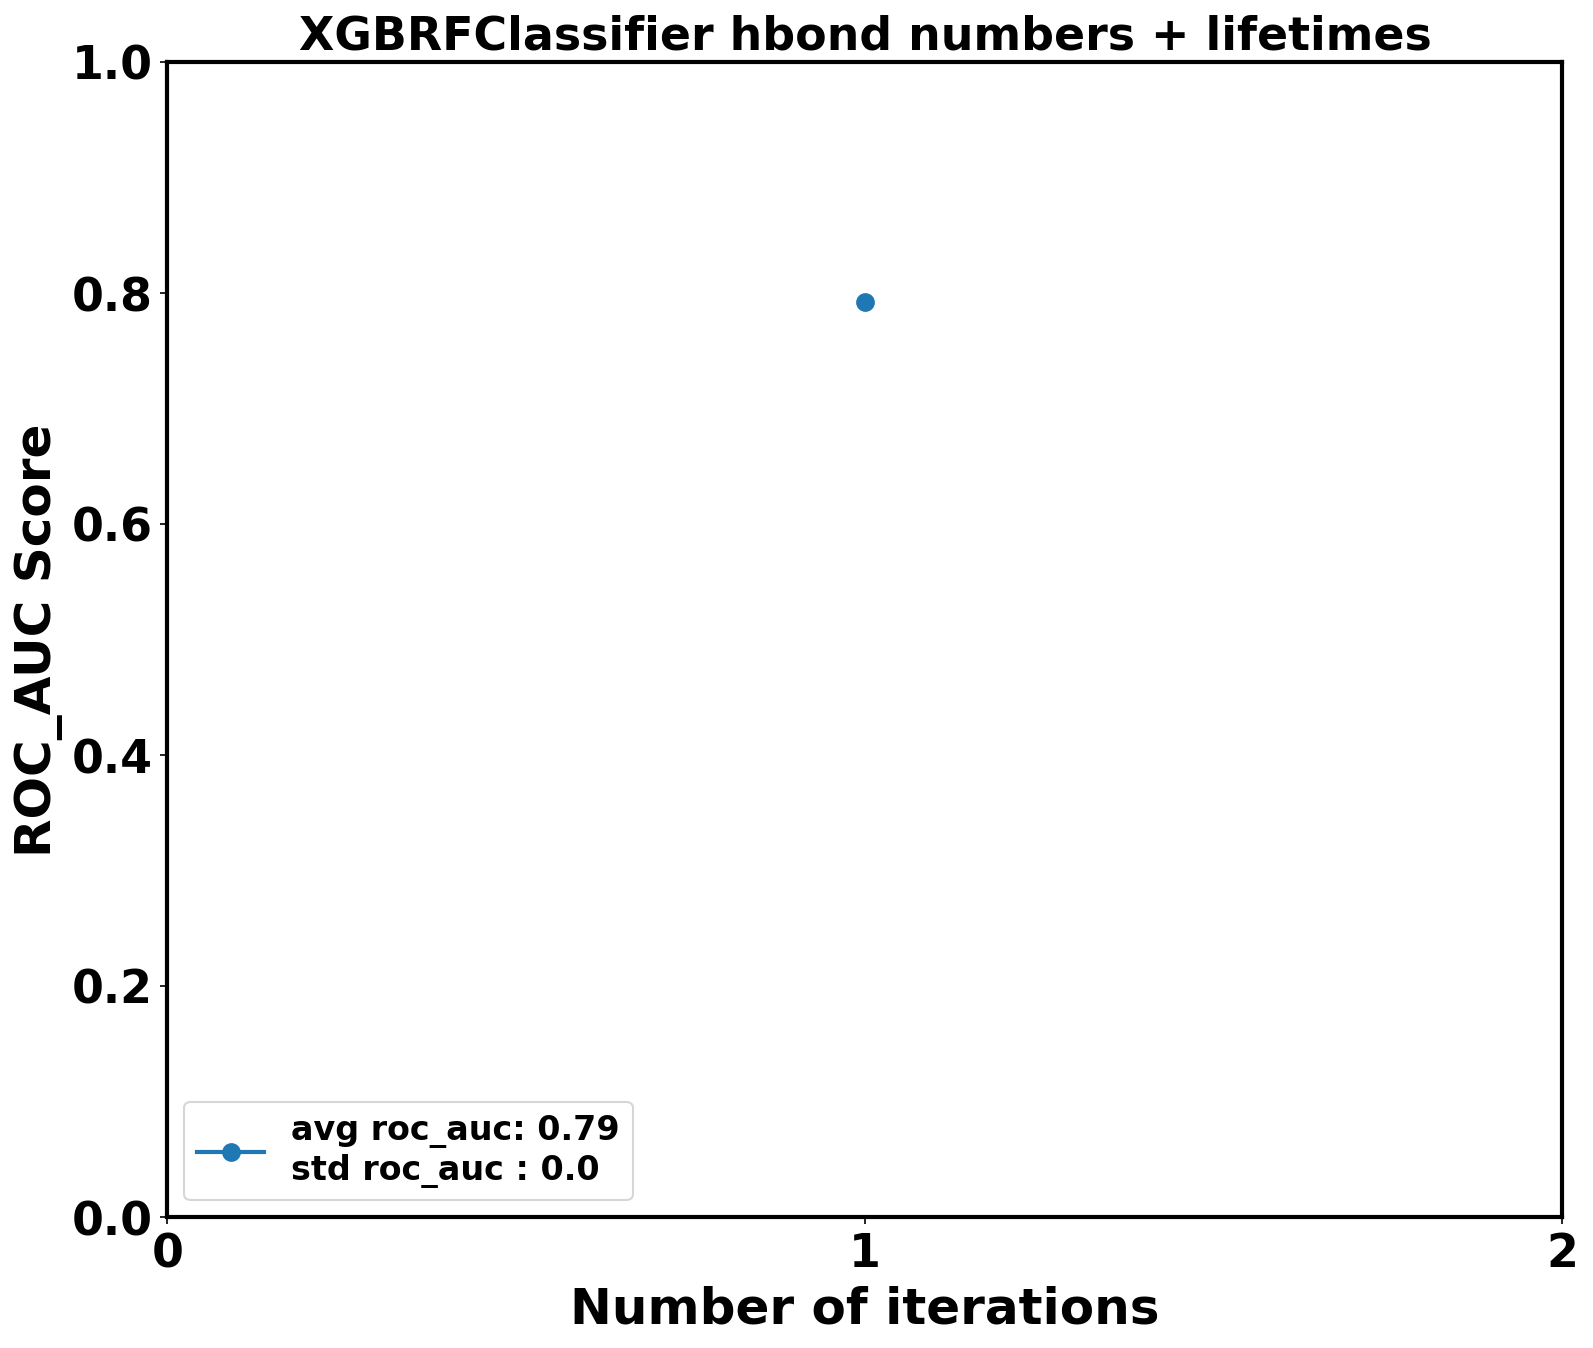

In [34]:
# Validation with lignin

plt.rcParams.update({
    "font.weight": "bold",
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    'font.size': 18,
    'axes.labelweight': 'bold',
    'figure.dpi': 150.0,
})

xdate = datetime.datetime.now().strftime("%m-%d-%Y")
rand_seed = 100
n_repeat = 1
folder_type='merged'
folder_types = ['hlife', 'hnum', 'merged']
tag = "LR"

models = {
    "RF": "RandomForestClassifier",
    "EF": "ExtraTreesClassifier",
    "GB": "GradientBoostingClassifier",
    "AB": "AdaBoostClassifier",
    "DT": "DecisionTreeClassifier",
    "LR": "LogisticRegression",
    "KNN": "KNeighborsClassifier",
    "SVC": "SVC",
    "XGB": "XGBClassifier",
    "XGBRF": "XGBRFClassifier"

}


for model_tag in models.keys():
    model = models[model_tag]
    model_type = load(f'./saved-models/{folder_type}/{model}_{folder_type}.joblib')
    model_name = model_type.__str__().split('(')[0]
    # print(f"{tag} training for {n_repeat} runs")

    dirmaker(f'./model-logs/validation/{folder_type}/{xdate}')
    file_name = open(f"./model-logs/validation/{folder_type}/{xdate}/{model_name}_{lig}_{folder_type}_{n_repeat}_{xdate}_{rand_seed}.txt", "w+")     

    X, Y = data_validate(des_df_merged, nondes_df_merged, batch_size=17)   
    validate_trained_models(model_type, X, Y,file_name=file_name, folder_type=folder_type, num=n_repeat, rand_seed=rand_seed)

## Boxplots

In [35]:
des_hlife_sum = des_df_hlife.describe()
des_hnum_sum = des_df_hnum.describe()
nondes_hlife_sum = nondes_df_hlife.describe()
nondes_hnum_sum = nondes_df_hnum.describe()

In [45]:
# des_hlife_sum
des_hnum_sum
# nondes_hlife_sum
# nondes_hnum_sum

,A-A,B-B,A-B,A-A/B-B,A-B/(A-A + B-B),output
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.0
mean,25.402362,14.040430,40.310337,3.604816,1.108419,1.0
std,24.974857,12.488954,29.826470,4.025143,0.395184,0.0
min,5.922078,3.147852,17.978022,0.202750,0.591553,1.0
25%,10.435564,5.783217,27.240759,0.640790,0.850253,1.0
50%,14.231768,10.493506,31.552448,1.972916,0.987652,1.0
75%,29.257742,16.748252,40.727273,4.262717,1.295652,1.0
max,103.439560,44.244755,148.755245,14.269438,2.261271,1.0


In [49]:
# # All tags
# taggsss = list(nondes_df_hnum.columns)
# taggsss.remove('output')
# taggsss

# # Excluding the ratios
# taggsss = list(nondes_df_hnum.columns)
# taggsss.remove('output')
# taggsss.remove('A-A/B-B')
# taggsss.remove('A-B/(A-A + B-B)')
# taggsss

# Excluding all but the ratios
taggsss = list(nondes_df_hnum.columns)
taggsss.remove('output')
taggsss.remove('A-A')
taggsss.remove('B-B')
taggsss.remove('A-B')
taggsss

['A-A/B-B', 'A-B/(A-A + B-B)']

In [38]:
def df_boxplot(df, list_of_tags):
    taggss = list_of_tags
    list_baba = []

    for i in range(len(taggss)):
        boxplot_dict = {
            'label' : taggss[i],  # hbond features
            'whislo': df[taggss[i]].loc['min'],    # Bottom whisker position
            'q1'    : df[taggss[i]].loc['25%'],    # First quartile (25th percentile)
            'med'   : df[taggss[i]].loc['50%'],    # Median         (50th percentile)
            'q3'    : df[taggss[i]].loc['75%'],    # Third quartile (75th percentile)
            'whishi': df[taggss[i]].loc['max'],    # Top whisker position
            'fliers': []        # Outliers
        }

        list_baba.append(boxplot_dict)
    
    return list_baba

In [50]:
deshnum_list = df_boxplot(des_hnum_sum, taggsss)
nondeshnum_list = df_boxplot(nondes_hnum_sum, taggsss)
deshlife_list = df_boxplot(des_hlife_sum, taggsss)
nondeshlife_list = df_boxplot(nondes_hlife_sum, taggsss)

In [46]:

def boxplotter(df_list, title_tag, fig_title, data_type='hnum'):
    xdate = datetime.datetime.now().strftime("%m-%d-%Y")

    fig_1, ax_1 = plt.subplots(1,1)
    fig_1.set_size_inches(12,10, forward=True)  

    ax_1.bxp(df_list, showfliers=False, boxprops=dict(linestyle='-', linewidth=3.5),
    flierprops=dict(linestyle='-', linewidth=5.5),
                medianprops=dict(linestyle='-', linewidth=3.5),
                whiskerprops=dict(linestyle='-', linewidth=3.5),
                capprops=dict(linestyle='-', linewidth=3.5))
    
    if data_type=='hnum':
        upper=149  #60
    elif data_type=='hlife':
        upper=5
    else:
        upper=105
        
                        
    ax_1.set_ylim(bottom=0, top=upper)
    title = title_tag
    # ax_1.set_title(f'{title_tag}', weight='bold')
    dirmaker(f'./plots/boxplots/{xdate}')
    plt.savefig(f"./plots/boxplots/{xdate}/{fig_title}_validation_{xdate}.tiff", facecolor="white", bbox_inches="tight", dpi=350)
    plt.show()

In [52]:

def boxplotter_ratios(df_list, title_tag, fig_title, data_type='hnum'):
    xdate = datetime.datetime.now().strftime("%m-%d-%Y")

    fig_1, ax_1 = plt.subplots(1,1)
    fig_1.set_size_inches(12,10, forward=True)  

    ax_1.bxp(df_list, showfliers=False, boxprops=dict(linestyle='-', linewidth=3.5),
    flierprops=dict(linestyle='-', linewidth=5.5),
                medianprops=dict(linestyle='-', linewidth=3.5),
                whiskerprops=dict(linestyle='-', linewidth=3.5),
                capprops=dict(linestyle='-', linewidth=3.5))
    
    if data_type=='hnum':
        upper=15  #24
    elif data_type=='hlife':
        upper=5  #10
    else:
        upper=105
        
                        
    ax_1.set_ylim(bottom=0, top=upper)
    title = title_tag
    # ax_1.set_title(f'{title_tag}', weight='bold')
    dirmaker(f'./plots/boxplots/{xdate}')
    plt.savefig(f"./plots/boxplots/{xdate}/{fig_title}_ratios_{xdate}.tiff", facecolor="white", bbox_inches="tight", dpi=350)
    plt.show()

In [ ]:
plt.rcParams.update({
    "font.weight": "bold",
    "xtick.labelsize": 30,
    "ytick.labelsize": 30,
    'font.size': 34,
    'axes.labelweight': 'bold',
    'figure.dpi': 350.0,
    'axes.linewidth':2.0,
})

titles = {
        'des_hnum':'DES hydrogen bond numbers per molecule',
        'nondes_hnum':'non-DES hydrogen bond numbers per molecule',
        'des_hlife':'DES hydrogen bond lifetimes per molecule',
        'nondes_hlife':'non-DES hydrogen bond lifetimes per molecule',
    }

df_lists = {
        'des_hnum':deshnum_list,
        'nondes_hnum':nondeshnum_list,
        'des_hlife':deshlife_list,
        'nondes_hlife':nondeshlife_list,
    }

for key in df_lists.keys():
    titletag = key
    dtype = titletag.split('_')[1]
    # boxplotter(df_lists[titletag], titles[titletag], titletag, data_type=dtype)
    boxplotter_ratios(df_lists[titletag], titles[titletag], titletag, data_type=dtype)

## Confusion Matrices visualization

In [54]:

def conf_matrix_plot(model, X, y, model_name, folder_type):
    '''
    This function generates confusion matrices.
    model is the saved model,
    X is the input feature,
    y is the output label,
    model_name is a tag for saving plots,
    folder_type is hlife, hnum or merged.

    '''
    class_names = ['non-DES', 'DES']
    
    titles_options = [
        (None),
        ("true"), ]

    for normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            model,
            X,
            y,
            display_labels=class_names,
            cmap=plt.cm.Blues,
            normalize=normalize,
        )

        disp.figure_.set_size_inches(14, 10)
        # disp.ax_.set_title(title, fontsize=30, weight='bold')
        disp.ax_.set_xlabel("Predicted label", weight='bold')
        disp.ax_.set_ylabel("True label", weight='bold')
        print(disp.confusion_matrix)

        if normalize=="true":
            tag = 'norm'
        elif normalize==None:
            tag = ''
        else:
            print("check normalize variable")


        plt.savefig(
            f"./plots/confusion-matrix/{folder_type}/{xdate}/{model_name}_{tag}.tiff", dpi=400, facecolor='white')

    plt.show()


#### hnum

In [ ]:
# Validation with lignin dataset

plt.rcParams.update({
    "font.weight": "bold",
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    'font.size': 32,
    'axes.labelweight': 'bold',
    'figure.dpi':400.0,
})

xdate = datetime.datetime.now().strftime("%m-%d-%Y")
rand_seed = 100
n_repeat = 1
folder_type='hnum'
# folder_types = ['hlife', 'hnum', 'merged']

models = {
    "RF": "RandomForestClassifier",
    "EF": "ExtraTreesClassifier",
    "GB": "GradientBoostingClassifier",
    "AB": "AdaBoostClassifier",
    "DT": "DecisionTreeClassifier",
    "LR": "LogisticRegression",
    "KNN": "KNeighborsClassifier",
    "SVC": "SVC",
    "XGB": "XGBClassifier",
    "XGBRF": "XGBRFClassifier"

}


for model_tag in models.keys():
    model = models[model_tag]
    model_type = load(f'./saved-models/{folder_type}/{model}_{folder_type}.joblib')
    model_name = model_type.__str__().split('(')[0]
    # print(f"{tag} training for {n_repeat} runs")

    dirmaker(f'./plots/confusion-matrix/{folder_type}/{xdate}')
    # file_name = open(f"./model-logs/validation/{folder_type}/{xdate}/{model_name}_{lig}_{folder_type}_{n_repeat}_{xdate}_{rand_seed}.txt", "w+")     

    X, Y = data_validate(des_df_hnum, nondes_df_hnum, batch_size=17)   
    conf_matrix_plot(model=model_type, X=X, y=Y, model_name=model_name, folder_type=folder_type)

### hlife

In [ ]:
# Validation with lignin dataset

plt.rcParams.update({
    "font.weight": "bold",
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    'font.size': 32,
    'axes.labelweight': 'bold',
    'figure.dpi':400.0,
})

xdate = datetime.datetime.now().strftime("%m-%d-%Y")
rand_seed = 100
n_repeat = 1
folder_type='hlife'
# folder_types = ['hlife', 'hnum', 'merged']

models = {
    "RF": "RandomForestClassifier",
    "EF": "ExtraTreesClassifier",
    "GB": "GradientBoostingClassifier",
    "AB": "AdaBoostClassifier",
    "DT": "DecisionTreeClassifier",
    "LR": "LogisticRegression",
    "KNN": "KNeighborsClassifier",
    "SVC": "SVC",
    "XGB": "XGBClassifier",
    "XGBRF": "XGBRFClassifier"

}


for model_tag in models.keys():
    model = models[model_tag]
    model_type = load(f'./saved-models/{folder_type}/{model}_{folder_type}.joblib')
    model_name = model_type.__str__().split('(')[0]
    # print(f"{tag} training for {n_repeat} runs")

    dirmaker(f'./plots/confusion-matrix/{folder_type}/{xdate}')
    # file_name = open(f"./model-logs/validation/{folder_type}/{xdate}/{model_name}_{lig}_{folder_type}_{n_repeat}_{xdate}_{rand_seed}.txt", "w+")     

    X, Y = data_validate(des_df_hlife, nondes_df_hlife, batch_size=17)   
    conf_matrix_plot(model=model_type, X=X, y=Y, model_name=model_name, folder_type=folder_type)

### merged

In [ ]:
# Validation with lignin dataset

plt.rcParams.update({
    "font.weight": "bold",
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    'font.size': 32,
    'axes.labelweight': 'bold',
    'figure.dpi':400.0,
})

xdate = datetime.datetime.now().strftime("%m-%d-%Y")
rand_seed = 100
n_repeat = 1
folder_type='merged'
# folder_types = ['hlife', 'hnum', 'merged']

models = {
    "RF": "RandomForestClassifier",
    "EF": "ExtraTreesClassifier",
    "GB": "GradientBoostingClassifier",
    "AB": "AdaBoostClassifier",
    "DT": "DecisionTreeClassifier",
    "LR": "LogisticRegression",
    "KNN": "KNeighborsClassifier",
    "SVC": "SVC",
    "XGB": "XGBClassifier",
    "XGBRF": "XGBRFClassifier"

}


for model_tag in models.keys():
    model = models[model_tag]
    model_type = load(f'./saved-models/{folder_type}/{model}_{folder_type}.joblib')
    model_name = model_type.__str__().split('(')[0]
    # print(f"{tag} training for {n_repeat} runs")

    dirmaker(f'./plots/confusion-matrix/{folder_type}/{xdate}')
    # file_name = open(f"./model-logs/validation/{folder_type}/{xdate}/{model_name}_{lig}_{folder_type}_{n_repeat}_{xdate}_{rand_seed}.txt", "w+")     

    X, Y = data_validate(des_df_merged, nondes_df_merged, batch_size=17)   
    conf_matrix_plot(model=model_type, X=X, y=Y, model_name=model_name, folder_type=folder_type)

## Pred probabilities

In [ ]:
plt.rcParams.update({
    "font.weight": "bold",
    "xtick.labelsize": 34,
    "ytick.labelsize": 34,
    'font.size': 38,
    'axes.labelweight': 'bold',
    'figure.dpi': 350.0,
    'axes.linewidth':2.0,
})


folder_types = ['hlife', 'hnum', 'merged']
# folder_types = ['merged']

for x in folder_types:
    if x=='hlife':
        X, Y = data_validate(des_df_hlife, nondes_df_hlife, batch_size=17)
    elif x=='hnum':
        X, Y = data_validate(des_df_hnum, nondes_df_hnum, batch_size=17)
    elif x=='merged':
        X, Y = data_validate(des_df_merged, nondes_df_merged, batch_size=17)
    else:
        print('There is an error in the folder_types variable')


    validation_proba_plotter(folder_type=x, overlapping=False, true_label=Y, annotate=True)

## Best parameters

In [37]:

folder_types = ['hlife', 'hnum', 'merged']
xdate = datetime.datetime.now().strftime("%m-%d-%Y")

for folder_type in folder_types:
    # folder_type = 'hlife'
    pathway = Path()
    params = {}
    
    for file in pathway.glob(f'./model-logs/gridsearch/{folder_type}/01-19-2023/*.txt'):
        model_name = str(file.stem).split('_')[0] 
        # print(model_name)
        with open(file, 'r+') as r:        
            for l_no, line in enumerate(r):
                # search string
                if 'Best params: ' in line:
                    # print(line.split(':'))
                    # print(line.strip(' \n'))
                    stripped = line.strip(' \n')
                    # print(stripped[14:-1])
                    actual_params = stripped[14:-1]
                    params[f'{model_name}'] = actual_params
                    # print(f'string found in {file} on line number {l_no}')
                    break
        


    print(pd.DataFrame.from_dict(data=params, orient='index', columns=['Best Params'])) #, columns=['Algorithm', 'Best Params']))
    df = pd.DataFrame.from_dict(data=params, orient='index', columns=['Best Params'])
    dirmaker(f'./model-logs/best-params/{folder_type}/{xdate}')
    df.to_excel(f'./model-logs/best-params/{folder_type}/{xdate}/best_params_{folder_type}_{xdate}.xlsx')



                                                                  Best Params
AdaBoostClassifier                  'learning_rate': 0.01, 'n_estimators': 80
DecisionTreeClassifier      'max_depth': 10, 'max_features': 'log2', 'min_...
ExtraTreesClassifier        'max_depth': 10, 'max_features': 'sqrt', 'min_...
GradientBoostingClassifier  'learning_rate': 0.01, 'max_depth': 4, 'max_fe...
KNeighborsClassifier        'leaf_size': 30, 'metric': 'manhattan', 'n_nei...
LogisticRegression          'max_iter': 400, 'penalty': 'none', 'solver': ...
RandomForestClassifier      'max_depth': 10, 'max_features': 'sqrt', 'min_...
SVC                         'degree': 3, 'gamma': 'scale', 'kernel': 'line...
XGBClassifier               'colsample_bytree': 0.1, 'learning_rate': 0.01...
XGBRFClassifier             'colsample_bytree': 0.4, 'learning_rate': 0.01...
                                                                  Best Params
AdaBoostClassifier                 'learning_rate': 0.01, 'n_est

## Experiment Zone